<a href="https://colab.research.google.com/github/thomazmartins23/Analise_de_Risco/blob/main/RISCOS_FUNDOS_PY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - DADOS HISTÓRICOS OTIMIZADA

## 1.1 - CONFIGURAÇÃO E IMPORTS

### 1.1.1 - IMPORTS CENTRALIZADOS

In [ ]:
# ===================================================================
# 1.1.1 - IMPORTS CENTRALIZADOS
# ===================================================================

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, Optional, Union, Any
from dataclasses import dataclass, field
import warnings
import logging

# Configurar warnings
warnings.filterwarnings('ignore')

### 1.1.2 - CONFIGURAÇÃO ESTRUTURADA

In [ ]:
# ===================================================================
# 1.1.2 - CONFIGURAÇÃO ESTRUTURADA
# ===================================================================

@dataclass
class ConfiguracaoSistema:
    """
    Configuração centralizada do sistema de análise financeira.

    Attributes:
        arquivo_cotas: Caminho para o arquivo Excel com dados das cotas
        sheet_name: Nome ou índice da planilha a ser lida
        colunas_utilizadas: Colunas do Excel a serem importadas
        linhas_pular: Número de linhas a pular no início do arquivo
        data_inicio: Data de início para análise (opcional)
        data_fim: Data de fim para análise (opcional)
        tickers_mercado: Dicionário com tickers para download
        parametros_bcb: Configurações para simulação BCB
        debug_mode: Se deve imprimir informações de debug
    """

    # Configurações do arquivo de cotas
    arquivo_cotas: str = '/content/Cotas/Relatório de Cotas e Patrimônio - Final.xlsx'
    sheet_name: Union[str, int] = 0
    colunas_utilizadas: str = "B,H"
    linhas_pular: int = 7

    # Configurações de período
    data_inicio: Optional[str] = None
    data_fim: Optional[str] = None

    # Tickers para download de dados de mercado
    tickers_mercado: Dict[str, str] = field(default_factory=lambda: {
        'dolar': 'USDBRL=X',
        'ibovespa': '^BVSP',
        'treasury': '^TNX'
    })

    # Configurações BCB (para simulação quando API não disponível)
    parametros_bcb: Dict[str, float] = field(default_factory=lambda: {
        'cdi_anual': 0.12,  # 12% a.a.
        'volatilidade_cdi': 0.0001,
        'volatilidade_selic': 0.00005,
        'seed': 42
    })

    # Configurações de sistema
    debug_mode: bool = True
    log_level: str = 'INFO'
    formato_data: str = '%d/%m/%Y'

    def __post_init__(self):
        """Validação pós-inicialização"""
        self.validar_configuracao()
        self.configurar_logging()

    def validar_configuracao(self) -> None:
        """Valida se as configurações estão corretas"""

        # Validar arquivo de cotas
        if not isinstance(self.arquivo_cotas, str) or not self.arquivo_cotas.strip():
            raise ValueError("Caminho do arquivo de cotas deve ser uma string não vazia")

        # Validar colunas
        try:
            colunas = [col.strip() for col in self.colunas_utilizadas.split(',')]
            if len(colunas) != 2:
                raise ValueError("Deve especificar exatamente 2 colunas")
        except Exception as e:
            raise ValueError(f"Formato de colunas inválido: {e}")

        # Validar parâmetros BCB
        bcb = self.parametros_bcb
        if not (0 < bcb['cdi_anual'] < 1):
            raise ValueError("CDI anual deve estar entre 0 e 1")

        # Validar datas se fornecidas
        if self.data_inicio:
            try:
                datetime.strptime(self.data_inicio, self.formato_data)
            except ValueError:
                raise ValueError(f"Data início inválida. Use formato {self.formato_data}")

        if self.data_fim:
            try:
                datetime.strptime(self.data_fim, self.formato_data)
            except ValueError:
                raise ValueError(f"Data fim inválida. Use formato {self.formato_data}")

    def configurar_logging(self) -> None:
        """Configura o sistema de logging"""
        logging.basicConfig(
            level=getattr(logging, self.log_level),
            format='%(asctime)s - %(levelname)s - %(message)s',
            datefmt='%H:%M:%S'
        )

    def obter_colunas_lista(self) -> list:
        """Retorna as colunas como lista"""
        return [col.strip() for col in self.colunas_utilizadas.split(',')]

    def arquivo_existe(self) -> bool:
        """Verifica se o arquivo de cotas existe"""
        return Path(self.arquivo_cotas).exists()

### 1.1.3 - GERENCIADOR DE CONFIGURAÇÃO

In [ ]:
# ===================================================================
# 1.1.3 - GERENCIADOR DE CONFIGURAÇÃO
# ===================================================================

class GerenciadorConfiguracao:
    """
    Gerenciador centralizado de configuração do sistema.
    Permite carregar configurações de diferentes fontes e validá-las.
    """

    def __init__(self, config: Optional[ConfiguracaoSistema] = None):
        self.config = config or ConfiguracaoSistema()
        self.logger = logging.getLogger(__name__)

    @classmethod
    def criar_configuracao_padrao(cls) -> 'GerenciadorConfiguracao':
        """Cria gerenciador com configuração padrão"""
        return cls(ConfiguracaoSistema())

    @classmethod
    def criar_configuracao_customizada(
        cls,
        arquivo_cotas: str,
        **kwargs
    ) -> 'GerenciadorConfiguracao':
        """
        Cria gerenciador com configuração customizada

        Args:
            arquivo_cotas: Caminho para arquivo de cotas
            **kwargs: Outros parâmetros de configuração
        """
        config = ConfiguracaoSistema(arquivo_cotas=arquivo_cotas, **kwargs)
        return cls(config)

    def validar_ambiente(self) -> Dict[str, bool]:
        """
        Valida se o ambiente está pronto para execução

        Returns:
            Dict com status de cada validação
        """
        status = {
            'arquivo_cotas_existe': self.config.arquivo_existe(),
            'configuracao_valida': True,
            'bibliotecas_disponiveis': True
        }

        try:
            self.config.validar_configuracao()
        except Exception as e:
            status['configuracao_valida'] = False
            self.logger.error(f"Configuração inválida: {e}")

        # Verificar bibliotecas essenciais
        try:
            import yfinance
            import pandas
            import numpy
        except ImportError as e:
            status['bibliotecas_disponiveis'] = False
            self.logger.error(f"Biblioteca não encontrada: {e}")

        return status

    def imprimir_status(self) -> None:
        """Imprime status da configuração"""
        status = self.validar_ambiente()

        print("✅ CONFIGURAÇÃO DO SISTEMA CARREGADA")
        print("=" * 50)
        print(f"📁 Arquivo: {self.config.arquivo_cotas}")
        print(f"📊 Planilha: {self.config.sheet_name}")
        print(f"📋 Colunas: {self.config.colunas_utilizadas}")
        print(f"⏭️  Pular linhas: {self.config.linhas_pular}")
        print(f"🔧 Debug: {'Ativo' if self.config.debug_mode else 'Inativo'}")

        print("\n🔍 VALIDAÇÃO DO AMBIENTE:")
        for check, passou in status.items():
            emoji = "✅" if passou else "❌"
            nome = check.replace('_', ' ').title()
            print(f"   {emoji} {nome}")

        if not all(status.values()):
            print("\n⚠️  ATENÇÃO: Alguns checks falharam. Verifique as configurações.")
        else:
            print("\n🚀 Sistema pronto para execução!")

    def obter_config(self) -> ConfiguracaoSistema:
        """Retorna a configuração atual"""
        return self.config

    def atualizar_config(self, **kwargs) -> None:
        """
        Atualiza configuração atual

        Args:
            **kwargs: Parâmetros a serem atualizados
        """
        for key, value in kwargs.items():
            if hasattr(self.config, key):
                setattr(self.config, key, value)
                self.logger.info(f"Configuração atualizada: {key} = {value}")
            else:
                self.logger.warning(f"Parâmetro desconhecido ignorado: {key}")

        # Revalidar após atualização
        self.config.validar_configuracao()

### 1.1.4 - INSTANCIAÇÃO E CONFIGURAÇÃO GLOBAL

In [ ]:
# ===================================================================
# 1.1.4 - INSTANCIAÇÃO E CONFIGURAÇÃO GLOBAL
# ===================================================================

def inicializar_sistema(
    arquivo_cotas: Optional[str] = None,
    debug: bool = True,
    **kwargs
) -> GerenciadorConfiguracao:
    """
    Função principal para inicializar o sistema de análise

    Args:
        arquivo_cotas: Caminho customizado para arquivo de cotas
        debug: Se deve ativar modo debug
        **kwargs: Outros parâmetros de configuração

    Returns:
        GerenciadorConfiguracao configurado e validado
    """

    if arquivo_cotas:
        # Configuração customizada
        gerenciador = GerenciadorConfiguracao.criar_configuracao_customizada(
            arquivo_cotas=arquivo_cotas,
            debug_mode=debug,
            **kwargs
        )
    else:
        # Configuração padrão
        gerenciador = GerenciadorConfiguracao.criar_configuracao_padrao()
        if not debug:
            gerenciador.atualizar_config(debug_mode=debug)

    # Imprimir status se debug ativo
    if gerenciador.config.debug_mode:
        gerenciador.imprimir_status()

    return gerenciador


### 1.1.5 - EXECUÇÃO E CRIAÇÃO DE VARIÁVEL GLOBAL

In [ ]:
# ===================================================================
# 1.1.5 - EXECUÇÃO E CRIAÇÃO DE VARIÁVEL GLOBAL
# ===================================================================

# Criar gerenciador global do sistema
print("🚀 Inicializando Sistema de Análise Financeira...")
gerenciador_config = inicializar_sistema()

# Extrair configuração para uso nas próximas seções
config_sistema = gerenciador_config.obter_config()

# Criar variáveis de compatibilidade com código existente
CAMINHO_ARQUIVO = config_sistema.arquivo_cotas
SHEET_NAME = config_sistema.sheet_name
COLUNAS = config_sistema.colunas_utilizadas
PULAR_LINHAS = config_sistema.linhas_pular

print("\n✅ Seção 1.1 concluída - Sistema configurado e pronto!")
print("📊 Variáveis globais criadas para compatibilidade:")
print(f"   • gerenciador_config: Gerenciador principal")
print(f"   • config_sistema: Configuração estruturada")
print(f"   • CAMINHO_ARQUIVO, SHEET_NAME, COLUNAS, PULAR_LINHAS: Variáveis legadas")

🚀 Inicializando Sistema de Análise Financeira...
✅ CONFIGURAÇÃO DO SISTEMA CARREGADA
📁 Arquivo: /content/Cotas/Relatório de Cotas e Patrimônio - Final.xlsx
📊 Planilha: 0
📋 Colunas: B,H
⏭️  Pular linhas: 7
🔧 Debug: Ativo

🔍 VALIDAÇÃO DO AMBIENTE:
   ✅ Arquivo Cotas Existe
   ✅ Configuracao Valida
   ✅ Bibliotecas Disponiveis

🚀 Sistema pronto para execução!

✅ Seção 1.1 concluída - Sistema configurado e pronto!
📊 Variáveis globais criadas para compatibilidade:
   • gerenciador_config: Gerenciador principal
   • config_sistema: Configuração estruturada
   • CAMINHO_ARQUIVO, SHEET_NAME, COLUNAS, PULAR_LINHAS: Variáveis legadas


## 1.2 - CARREGAMENTO DE COTAS

### 1.2.1 - CARREGADOR DE COTAS DO FUNDO

In [ ]:
# ===================================================================
# 1.2.1 - CARREGADOR DE COTAS DO FUNDO
# ===================================================================

from abc import ABC, abstractmethod
from typing import Dict, List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import logging

class CarregadorCotasBase(ABC):
    """Classe base abstrata para carregamento de cotas de fundos"""

    @abstractmethod
    def carregar_dados(self) -> pd.DataFrame:
        """Carrega dados de cotas do fundo"""
        pass

    @abstractmethod
    def validar_dados(self, df: pd.DataFrame) -> bool:
        """Valida se os dados carregados estão corretos"""
        pass


class CarregadorCotasExcel(CarregadorCotasBase):
    """
    Carregador especializado para arquivos Excel de cotas de fundos.
    Facilmente adaptável para diferentes fundos e formatos.
    """

    def __init__(self, gerenciador_config):
        self.config = gerenciador_config.obter_config()
        self.logger = logging.getLogger(__name__)

    def carregar_dados(self) -> pd.DataFrame:
        """
        Carrega e processa cotas do fundo a partir do Excel

        Returns:
            DataFrame com colunas: ['data', 'cota', 'retorno_cota']
        """
        try:
            self.logger.info(f"Carregando cotas de: {self.config.arquivo_cotas}")

            # Primeiro, verificar a estrutura do arquivo
            df = self._carregar_com_deteccao_automatica()

            # Processar dados
            df = self._processar_dados_brutos(df)

            # Validar resultado
            if not self.validar_dados(df):
                raise ValueError("Dados carregados não passaram na validação")

            self.logger.info(f"✅ Cotas carregadas: {len(df)} observações")
            return df

        except Exception as e:
            self.logger.error(f"Erro ao carregar cotas: {e}")
            raise

    def _carregar_com_deteccao_automatica(self) -> pd.DataFrame:
        """
        Carrega dados com detecção automática de colunas se necessário
        """
        colunas_config = self.config.obter_colunas_lista()

        # Se configurado para AUTO ou colunas não encontradas, usar detecção automática
        if colunas_config is None:
            self.logger.info("Detecção automática de colunas ativada")
            return self._deteccao_automatica_colunas()

        try:
            # Tentar carregamento com colunas especificadas
            df = pd.read_excel(
                self.config.arquivo_cotas,
                sheet_name=self.config.sheet_name,
                usecols=colunas_config,
                skiprows=self.config.linhas_pular
            )
            df.columns = ['data', 'cota']
            self.logger.info(f"✅ Colunas {colunas_config} carregadas com sucesso")
            return df

        except (ValueError, KeyError) as e:
            if "columns expected but not found" in str(e) or "not in list" in str(e):
                self.logger.warning(f"Colunas {colunas_config} não encontradas. Tentando detecção automática...")
                return self._deteccao_automatica_colunas()
            else:
                raise

    def _deteccao_automatica_colunas(self) -> pd.DataFrame:
        """
        Detecta automaticamente quais colunas contêm data e cota
        """
        # Carregar todas as colunas primeiro para análise
        df_completo = pd.read_excel(
            self.config.arquivo_cotas,
            sheet_name=self.config.sheet_name,
            skiprows=self.config.linhas_pular
        )

        self.logger.info(f"Analisando {len(df_completo.columns)} colunas disponíveis...")

        # Detectar coluna de data
        col_data = self._detectar_coluna_data(df_completo)

        # Detectar coluna de cota
        col_cota = self._detectar_coluna_cota(df_completo)

        if col_data is None or col_cota is None:
            raise ValueError(f"Não foi possível detectar colunas automaticamente. "
                           f"Data: {col_data}, Cota: {col_cota}")

        self.logger.info(f"✅ Detecção automática: Data='{col_data}', Cota='{col_cota}'")

        # Retornar apenas as colunas detectadas
        resultado = df_completo[[col_data, col_cota]].copy()
        resultado.columns = ['data', 'cota']
        return resultado

    def _detectar_coluna_data(self, df: pd.DataFrame) -> Optional[str]:
        """Detecta qual coluna contém as datas"""
        for col in df.columns:
            try:
                # Testar se consegue converter para data
                amostra = df[col].dropna().head(10)
                if len(amostra) == 0:
                    continue

                # Tentar conversão para datetime
                pd.to_datetime(amostra, dayfirst=True, errors='raise')
                return col

            except:
                # Verificar se é string que parece com data
                try:
                    amostra_str = amostra.astype(str)
                    data_pattern = amostra_str.str.match(r'^\d{2}/\d{2}/\d{4}$|\d{4}-\d{2}-\d{2}')
                    if data_pattern.sum() > len(amostra) * 0.5:  # Mais de 50% parecem datas
                        return col
                except:
                    continue
        return None

    def _detectar_coluna_cota(self, df: pd.DataFrame) -> Optional[str]:
        """Detecta qual coluna contém as cotas"""
        for col in df.columns:
            try:
                amostra = df[col].dropna().head(20)
                if len(amostra) < 5:
                    continue

                # Tentar conversão para numérico (considerando formato brasileiro)
                amostra_processada = self._processar_valores_cota(amostra)
                valores_validos = amostra_processada.dropna()

                # Verificar se são valores positivos que poderiam ser cotas
                if len(valores_validos) > len(amostra) * 0.7:  # 70% dos valores são válidos
                    if (valores_validos > 0).all() and (valores_validos < 10000).all():
                        # Verificar se há variação (não são todos iguais)
                        if valores_validos.std() > 0:
                            return col

            except:
                continue
        return None

    def _processar_dados_brutos(self, df: pd.DataFrame) -> pd.DataFrame:
        """Processa dados brutos aplicando filtros e transformações"""

        # Filtrar apenas datas válidas
        mascara_data = df['data'].astype(str).str.match(
            r'^\d{2}/\d{2}/\d{4}$|\d{4}-\d{2}-\d{2}'
        )
        df = df[mascara_data].copy()

        # Converter tipos
        df['data'] = pd.to_datetime(df['data'], dayfirst=True, errors='coerce')
        df['cota'] = self._processar_valores_cota(df['cota'])

        # Remover registros inválidos
        df = df.dropna(subset=['data', 'cota'])

        # Aplicar filtros de período se configurados
        df = self._aplicar_filtros_periodo(df)

        # Ordenar por data
        df = df.sort_values('data').reset_index(drop=True)

        # Calcular retornos logarítmicos
        df['retorno_cota'] = np.log(df['cota'] / df['cota'].shift(1))

        return df

    def _processar_valores_cota(self, serie_cota: pd.Series) -> pd.Series:
        """
        Processa valores de cota convertendo formatos brasileiros para numérico

        Args:
            serie_cota: Série com valores de cota (pode ter formato brasileiro)

        Returns:
            Série com valores numéricos
        """
        # Converter para string
        serie_str = serie_cota.astype(str)

        # Remover pontos (separador de milhares) e trocar vírgula por ponto
        serie_limpa = (serie_str
                      .str.replace('.', '', regex=False)
                      .str.replace(',', '.', regex=False))

        # Converter para numérico
        return pd.to_numeric(serie_limpa, errors='coerce')

    def _aplicar_filtros_periodo(self, df: pd.DataFrame) -> pd.DataFrame:
        """Aplica filtros de período baseados na configuração"""

        if self.config.data_inicio:
            data_inicio = pd.to_datetime(self.config.data_inicio,
                                       format=self.config.formato_data)
            df = df[df['data'] >= data_inicio]

        if self.config.data_fim:
            data_fim = pd.to_datetime(self.config.data_fim,
                                    format=self.config.formato_data)
            df = df[df['data'] <= data_fim]

        return df

    def validar_dados(self, df: pd.DataFrame) -> bool:
        """Valida se os dados carregados estão corretos"""

        if df.empty:
            self.logger.error("DataFrame vazio após carregamento")
            return False

        if len(df) < 10:
            self.logger.warning(f"Poucos dados carregados: {len(df)} observações")

        # Verificar colunas obrigatórias
        colunas_obrigatorias = ['data', 'cota', 'retorno_cota']
        if not all(col in df.columns for col in colunas_obrigatorias):
            self.logger.error(f"Colunas obrigatórias ausentes: {colunas_obrigatorias}")
            return False

        # Verificar tipos de dados
        if not pd.api.types.is_datetime64_any_dtype(df['data']):
            self.logger.error("Coluna 'data' deve ser datetime")
            return False

        if not pd.api.types.is_numeric_dtype(df['cota']):
            self.logger.error("Coluna 'cota' deve ser numérica")
            return False

        # Verificar valores
        if df['cota'].min() <= 0:
            self.logger.error("Cotas devem ser positivas")
            return False

        # Verificar ordem cronológica
        if not df['data'].is_monotonic_increasing:
            self.logger.warning("Dados não estão em ordem cronológica")

        return True

    def gerar_resumo(self, df: pd.DataFrame) -> Dict:
        """Gera resumo estatístico dos dados carregados"""

        retornos = df['retorno_cota'].dropna()

        return {
            'total_observacoes': len(df),
            'periodo_inicio': df['data'].min(),
            'periodo_fim': df['data'].max(),
            'ultima_cota': df['cota'].iloc[-1],
            'primeira_cota': df['cota'].iloc[0],
            'retorno_total': (df['cota'].iloc[-1] / df['cota'].iloc[0]) - 1,
            'retorno_medio_diario': retornos.mean(),
            'volatilidade_diaria': retornos.std(),
            'retornos_validos': len(retornos)
        }

### 1.2.2 - CARREGADOR DE DADOS DE MERCADO

In [ ]:
# ===================================================================
# 1.2.2 - CARREGADOR DE DADOS DE MERCADO
# ===================================================================

class CarregadorDadosMercado:
    """
    Carregador de dados de mercado via Yahoo Finance.
    Configurável via dicionário de tickers.
    """

    def __init__(self, gerenciador_config):
        self.config = gerenciador_config.obter_config()
        self.logger = logging.getLogger(__name__)
        self.dados_cache = {}

    def baixar_indicador(
        self,
        ticker: str,
        nome: str,
        start_date: str,
        end_date: str
    ) -> Optional[pd.DataFrame]:
        """
        Baixa dados de um indicador específico do Yahoo Finance

        Args:
            ticker: Símbolo do Yahoo Finance
            nome: Nome do indicador para a coluna
            start_date: Data de início (YYYY-MM-DD)
            end_date: Data de fim (YYYY-MM-DD)

        Returns:
            DataFrame com colunas ['data', nome, f'retorno_{nome}'] ou None se erro
        """
        try:
            self.logger.info(f"Baixando {nome} ({ticker})...")

            # Download dos dados
            dados = yf.download(
                ticker,
                start=start_date,
                end=end_date,
                progress=False,
                auto_adjust=True,
                threads=True
            )

            if dados.empty:
                self.logger.warning(f"⚠️ Sem dados para {nome}")
                return None

            # Tratar MultiIndex se necessário
            if isinstance(dados.columns, pd.MultiIndex):
                dados.columns = dados.columns.droplevel(1)

            # Usar preço de fechamento
            if 'Close' in dados.columns:
                preco = dados['Close']
            elif 'Adj Close' in dados.columns:
                preco = dados['Adj Close']
            else:
                self.logger.error(f"❌ Coluna de preço não encontrada para {nome}")
                return None

            # Criar DataFrame resultado
            resultado = pd.DataFrame({
                'data': preco.index,
                nome: preco.values
            })

            # Calcular retornos logarítmicos
            resultado[f'retorno_{nome}'] = np.log(
                resultado[nome] / resultado[nome].shift(1)
            )

            resultado = resultado.reset_index(drop=True)

            self.logger.info(f"✅ {nome}: {len(resultado)} observações")
            return resultado

        except Exception as e:
            self.logger.error(f"❌ Erro ao baixar {nome}: {e}")
            return None

    def baixar_todos_indicadores(
        self,
        start_date: str,
        end_date: str
    ) -> Dict[str, pd.DataFrame]:
        """
        Baixa todos os indicadores configurados

        Args:
            start_date: Data de início
            end_date: Data de fim

        Returns:
            Dicionário com nome_indicador -> DataFrame
        """
        indicadores = {}

        for nome, ticker in self.config.tickers_mercado.items():
            dados = self.baixar_indicador(ticker, nome, start_date, end_date)
            if dados is not None:
                indicadores[nome] = dados

        self.logger.info(f"✅ Total de indicadores baixados: {len(indicadores)}")
        return indicadores

    def obter_periodo_do_fundo(self, df_fundo: pd.DataFrame) -> Tuple[str, str]:
        """
        Extrai período de análise baseado nos dados do fundo

        Args:
            df_fundo: DataFrame com dados do fundo

        Returns:
            Tupla (start_date, end_date) no formato YYYY-MM-DD
        """
        start_date = df_fundo['data'].min().strftime('%Y-%m-%d')
        end_date = df_fundo['data'].max().strftime('%Y-%m-%d')
        return start_date, end_date

### 1.2.3 - SIMULADOR BCB (QUANDO API NÃO DISPONÍVEL)

In [ ]:
# ===================================================================
# 1.2.3 - SIMULADOR BCB (QUANDO API NÃO DISPONÍVEL)
# ===================================================================

class SimuladorBCB:
    """
    Simulador de dados BCB (CDI, SELIC) quando API não está disponível.
    Usa parâmetros configuráveis para gerar séries realistas.
    """

    def __init__(self, gerenciador_config):
        self.config = gerenciador_config.obter_config()
        self.logger = logging.getLogger(__name__)

    def simular_cdi_selic(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Simula séries de CDI e SELIC para o período especificado

        Args:
            start_date: Data de início
            end_date: Data de fim

        Returns:
            DataFrame com colunas ['data', 'retorno_cdi', 'retorno_selic']
        """
        try:
            self.logger.info("Simulando dados BCB (CDI e SELIC)...")

            # Gerar datas
            dates = pd.date_range(start=start_date, end=end_date, freq='D')

            # Configurar seed para reprodutibilidade
            np.random.seed(self.config.parametros_bcb['seed'])

            # Calcular taxas diárias
            params = self.config.parametros_bcb
            cdi_diario = (1 + params['cdi_anual']) ** (1/252) - 1

            # Adicionar ruído realista
            n_dias = len(dates)
            ruido_cdi = np.random.normal(0, params['volatilidade_cdi'], n_dias)
            ruido_selic = np.random.normal(0, params['volatilidade_selic'], n_dias)

            # Gerar séries
            cdi_retornos = cdi_diario + ruido_cdi
            selic_retornos = cdi_retornos + ruido_selic  # SELIC próxima ao CDI

            resultado = pd.DataFrame({
                'data': dates,
                'retorno_cdi': cdi_retornos,
                'retorno_selic': selic_retornos
            })

            self.logger.info(f"✅ Dados BCB simulados: {len(resultado)} observações")
            return resultado

        except Exception as e:
            self.logger.error(f"❌ Erro na simulação BCB: {e}")
            raise

    def adicionar_cupom_cambial(
        self,
        dados_bcb: pd.DataFrame,
        dados_dolar: Optional[pd.DataFrame]
    ) -> pd.DataFrame:
        """
        Adiciona cupom cambial (CDI - variação do dólar) se disponível

        Args:
            dados_bcb: DataFrame com dados BCB
            dados_dolar: DataFrame com dados do dólar (opcional)

        Returns:
            DataFrame atualizado com coluna 'retorno_cupom' se possível
        """
        if dados_dolar is None or 'retorno_dolar' not in dados_dolar.columns:
            self.logger.warning("Dados do dólar não disponíveis para cupom cambial")
            return dados_bcb

        try:
            # Merge com dados do dólar
            merged = pd.merge(dados_bcb, dados_dolar[['data', 'retorno_dolar']],
                            on='data', how='left')

            # Calcular cupom cambial
            merged['retorno_cupom'] = (merged['retorno_cdi'] -
                                     merged['retorno_dolar'].fillna(0))

            self.logger.info("✅ Cupom cambial calculado")
            return merged

        except Exception as e:
            self.logger.error(f"❌ Erro no cálculo do cupom cambial: {e}")
            return dados_bcb

### 1.2.4 - ORQUESTRADOR DE DADOS

In [ ]:
# ===================================================================
# 1.2.4 - ORQUESTRADOR DE DADOS
# ===================================================================

class OrquestradorDados:
    """
    Orquestrador principal que coordena o carregamento de todos os dados
    e cria o dataset integrado final.
    """

    def __init__(self, gerenciador_config):
        self.gerenciador_config = gerenciador_config
        self.config = gerenciador_config.obter_config()
        self.logger = logging.getLogger(__name__)

        # Inicializar componentes
        self.carregador_cotas = CarregadorCotasExcel(gerenciador_config)
        self.carregador_mercado = CarregadorDadosMercado(gerenciador_config)
        self.simulador_bcb = SimuladorBCB(gerenciador_config)

        # Armazenar dados carregados
        self.dados_fundo = None
        self.dados_mercado = {}
        self.dados_bcb = None

    def carregar_dados_completos(self) -> Dict[str, pd.DataFrame]:
        """
        Executa carregamento completo de todos os dados

        Returns:
            Dicionário com todos os dados carregados
        """
        self.logger.info("🚀 Iniciando carregamento completo de dados...")

        # 1. Carregar dados do fundo
        self.dados_fundo = self.carregador_cotas.carregar_dados()

        # 2. Obter período para outros dados
        start_date, end_date = self.carregador_mercado.obter_periodo_do_fundo(
            self.dados_fundo
        )

        # 3. Carregar dados de mercado
        self.dados_mercado = self.carregador_mercado.baixar_todos_indicadores(
            start_date, end_date
        )

        # 4. Simular dados BCB
        self.dados_bcb = self.simulador_bcb.simular_cdi_selic(start_date, end_date)

        # 5. Adicionar cupom cambial se dólar disponível
        if 'dolar' in self.dados_mercado:
            self.dados_bcb = self.simulador_bcb.adicionar_cupom_cambial(
                self.dados_bcb, self.dados_mercado['dolar']
            )

        self.logger.info("✅ Carregamento completo finalizado!")

        return {
            'fundo': self.dados_fundo,
            'mercado': self.dados_mercado,
            'bcb': self.dados_bcb
        }

    def gerar_relatorio_carregamento(self) -> None:
        """Gera relatório detalhado do carregamento"""

        print("\n" + "="*60)
        print("📊 RELATÓRIO DE CARREGAMENTO DE DADOS")
        print("="*60)

        if self.dados_fundo is not None:
            resumo = self.carregador_cotas.gerar_resumo(self.dados_fundo)
            print("\n🏦 DADOS DO FUNDO:")
            print(f"   • Observações: {resumo['total_observacoes']}")
            print(f"   • Período: {resumo['periodo_inicio'].strftime('%d/%m/%Y')} "
                  f"a {resumo['periodo_fim'].strftime('%d/%m/%Y')}")
            print(f"   • Última cota: R$ {resumo['ultima_cota']:.4f}")
            print(f"   • Retorno total: {resumo['retorno_total']:.2%}")

        if self.dados_mercado:
            print(f"\n📈 DADOS DE MERCADO ({len(self.dados_mercado)} indicadores):")
            for nome, df in self.dados_mercado.items():
                print(f"   • {nome.upper()}: {len(df)} observações")

        if self.dados_bcb is not None:
            print(f"\n🏛️ DADOS BCB (SIMULADOS): {len(self.dados_bcb)} observações")
            if 'retorno_cupom' in self.dados_bcb.columns:
                print("   • Cupom cambial: ✅ Calculado")

### 1.2.5 - UTILITÁRIOS DE DIAGNÓSTICO

In [ ]:
# ===================================================================
# 1.2.5 - UTILITÁRIOS DE DIAGNÓSTICO
# ===================================================================

def diagnosticar_arquivo_excel(caminho_arquivo: str, sheet_name: Union[str, int] = 0, max_rows: int = 10):
    """
    Função utilitária para diagnosticar a estrutura de um arquivo Excel
    """
    try:
        print(f"🔍 DIAGNÓSTICO DO ARQUIVO: {caminho_arquivo}")
        print("="*60)

        # Carregar primeiras linhas sem pular nada
        df_raw = pd.read_excel(caminho_arquivo, sheet_name=sheet_name, nrows=max_rows)

        print(f"📊 Planilha analisada: {sheet_name}")
        print(f"📏 Dimensões: {df_raw.shape[0]} linhas x {df_raw.shape[1]} colunas")
        print(f"📋 Colunas disponíveis: {list(df_raw.columns)}")

        print(f"\n📖 Primeiras {min(max_rows, len(df_raw))} linhas:")
        print(df_raw.to_string())

        print(f"\n🔤 Tipos de dados:")
        for col in df_raw.columns:
            tipo = str(df_raw[col].dtype)
            exemplos = df_raw[col].dropna().head(3).tolist()
            print(f"   {col}: {tipo} | Exemplos: {exemplos}")

        # Tentar detectar automaticamente data e cota
        print(f"\n🤖 DETECÇÃO AUTOMÁTICA:")

        possivel_data = None
        possivel_cota = None

        for col in df_raw.columns:
            amostra = df_raw[col].dropna()
            if len(amostra) == 0:
                continue

            # Verificar se parece com data
            try:
                pd.to_datetime(amostra.head(5), dayfirst=True)
                possivel_data = col
                print(f"   📅 Possível coluna de DATA: '{col}'")
            except:
                pass

            # Verificar se parece com valor numérico (cota)
            try:
                # Converter considerando formato brasileiro
                amostra_str = amostra.astype(str)
                amostra_num = pd.to_numeric(
                    amostra_str.str.replace('.', '').str.replace(',', '.'),
                    errors='coerce'
                )
                valores_validos = amostra_num.dropna()

                if len(valores_validos) > len(amostra) * 0.5:  # Mais de 50% válidos
                    if (valores_validos > 0).all() and (valores_validos < 10000).all():
                        possivel_cota = col
                        print(f"   💰 Possível coluna de COTA: '{col}'")
            except:
                pass

        if possivel_data and possivel_cota:
            print(f"\n✅ SUGESTÃO DE CONFIGURAÇÃO:")
            print(f"   colunas_utilizadas = '{possivel_data},{possivel_cota}'")
            print(f"   (ou usar detecção automática)")
        else:
            print(f"\n⚠️ Não foi possível detectar colunas automaticamente")
            print(f"   Verifique manualmente as colunas acima")

    except Exception as e:
        print(f"❌ Erro no diagnóstico: {e}")

### 1.2.6 - EXECUÇÃO E CRIAÇÃO DE VARIÁVEIS GLOBAIS

In [ ]:
# ===================================================================
# 1.2.6 - EXECUÇÃO E CRIAÇÃO DE VARIÁVEIS GLOBAIS
# ===================================================================

def executar_carregamento_dados(gerenciador_config) -> Tuple[pd.DataFrame, Dict]:
    """
    Função principal para executar carregamento de dados

    Args:
        gerenciador_config: Gerenciador de configuração da seção 1.1

    Returns:
        Tupla (dados_fundo, dados_completos)
    """

    try:
        # Criar orquestrador
        orquestrador = OrquestradorDados(gerenciador_config)

        # Carregar todos os dados
        dados_completos = orquestrador.carregar_dados_completos()

        # Gerar relatório
        orquestrador.gerar_relatorio_carregamento()

        # Retornar dados principais
        return dados_completos['fundo'], dados_completos

    except Exception as e:
        print(f"\n❌ ERRO NO CARREGAMENTO: {e}")
        print("\n🔍 Executando diagnóstico automático do arquivo...")

        config = gerenciador_config.obter_config()
        diagnosticar_arquivo_excel(
            config.arquivo_cotas,
            config.sheet_name,
            max_rows=15
        )

        print(f"\n💡 SOLUÇÕES POSSÍVEIS:")
        print(f"1. Verificar se o arquivo existe: {config.arquivo_cotas}")
        print(f"2. Verificar se a planilha '{config.sheet_name}' está correta")
        print(f"3. Ajustar colunas_utilizadas na configuração")
        print(f"4. Ajustar linhas_pular se necessário")
        print(f"5. Usar detecção automática (será tentada automaticamente)")

        raise


def executar_carregamento_robusto(
    arquivo_cotas: Optional[str] = None,
    debug: bool = True
) -> Tuple[pd.DataFrame, Dict]:
    """
    Versão robusta que tenta múltiplas estratégias de carregamento

    Args:
        arquivo_cotas: Caminho customizado (opcional)
        debug: Se deve mostrar diagnósticos

    Returns:
        Tupla (dados_fundo, dados_completos)
    """

    print("🛡️ Executando carregamento robusto com fallbacks...")

    estrategias = [
        # Estratégia 1: Configuração padrão
        lambda: inicializar_sistema(arquivo_cotas, debug),

        # Estratégia 2: Detecção automática forçada
        lambda: inicializar_sistema(
            arquivo_cotas, debug,
            colunas_utilizadas="AUTO"  # Sinal especial
        ),

        # Estratégia 3: Sem pular linhas
        lambda: inicializar_sistema(
            arquivo_cotas, debug,
            linhas_pular=0
        ),

        # Estratégia 4: Planilha diferente
        lambda: inicializar_sistema(
            arquivo_cotas, debug,
            sheet_name=1
        )
    ]

    for i, estrategia in enumerate(estrategias, 1):
        try:
            print(f"\n🔄 Tentativa {i}/4...")
            gerenciador = estrategia()
            return executar_carregamento_dados(gerenciador)

        except Exception as e:
            print(f"❌ Tentativa {i} falhou: {e}")
            if i == len(estrategias):
                print("\n💀 Todas as estratégias falharam!")
                raise
            continue


# ===================================================================
# EXECUÇÃO DA SEÇÃO 1.2
# ===================================================================

print("🚀 Executando Seção 1.2 - Carregamento de Dados...")

try:
    # Primeiro, tentar execução normal
    df_fundo, dados_todos = executar_carregamento_dados(gerenciador_config)

except Exception as e:
    print(f"\n⚠️ Carregamento normal falhou. Tentando modo robusto...")

    # Usar versão robusta com múltiplas estratégias
    df_fundo, dados_todos = executar_carregamento_robusto(
        arquivo_cotas=config_sistema.arquivo_cotas,
        debug=config_sistema.debug_mode
    )

# Criar variáveis globais para compatibilidade
df = df_fundo  # Compatibilidade com código existente
dados_mercado = dados_todos['mercado']
dados_bcb = dados_todos['bcb']

print("\n✅ Seção 1.2 concluída!")
print("📊 Variáveis globais criadas:")
print("   • df: DataFrame principal do fundo")
print("   • df_fundo: Mesmo que df (mais explicativo)")
print("   • dados_mercado: Dicionário com dados de mercado")
print("   • dados_bcb: DataFrame com dados BCB simulados")
print("   • dados_todos: Dicionário completo com todos os dados")

# Função adicional para diagnóstico manual se necessário
def diagnosticar_arquivo():
    """Função helper para diagnóstico manual"""
    return diagnosticar_arquivo_excel(
        config_sistema.arquivo_cotas,
        config_sistema.sheet_name
    )

print("\n🔧 Para diagnóstico manual, execute: diagnosticar_arquivo()")

🚀 Executando Seção 1.2 - Carregamento de Dados...

📊 RELATÓRIO DE CARREGAMENTO DE DADOS

🏦 DADOS DO FUNDO:
   • Observações: 143
   • Período: 02/12/2024 a 30/06/2025
   • Última cota: R$ 813.5264
   • Retorno total: 35.70%

📈 DADOS DE MERCADO (3 indicadores):
   • DOLAR: 147 observações
   • IBOVESPA: 140 observações
   • TREASURY: 142 observações

🏛️ DADOS BCB (SIMULADOS): 211 observações
   • Cupom cambial: ✅ Calculado

✅ Seção 1.2 concluída!
📊 Variáveis globais criadas:
   • df: DataFrame principal do fundo
   • df_fundo: Mesmo que df (mais explicativo)
   • dados_mercado: Dicionário com dados de mercado
   • dados_bcb: DataFrame com dados BCB simulados
   • dados_todos: Dicionário completo com todos os dados

🔧 Para diagnóstico manual, execute: diagnosticar_arquivo()


## 1.3 - DADOS DE MERCADO

### 1.3.1 - INTEGRADOR DE DADOS

In [ ]:
# ===================================================================
# 1.3.1 - INTEGRADOR DE DADOS
# ===================================================================

from typing import Dict, List, Optional, Tuple, Union, Any
import pandas as pd
import numpy as np
import logging
from datetime import datetime, timedelta
from dataclasses import dataclass
import warnings

@dataclass
class ParametrosIntegracao:
    """
    Parâmetros para configurar a integração de dados
    """
    # Estratégia de merge
    estrategia_merge: str = 'left'  # 'left', 'inner', 'outer'

    # Tratamento de dados faltantes
    preencher_na_method: str = 'ffill'  # 'ffill', 'bfill', 'interpolate', 'drop'
    max_dias_gap: int = 5  # Máximo de dias consecutivos com dados faltantes

    # Filtros de qualidade
    min_observacoes: int = 50  # Mínimo de observações válidas
    outlier_threshold: float = 5.0  # Threshold para detecção de outliers (desvios padrão)

    # Transformações
    calcular_cupom_cambial: bool = True
    calcular_metricas_rolling: bool = True
    janela_volatilidade: int = 21  # Janela para volatilidade móvel

    # Debug
    verbose: bool = True


class IntegradorDados:
    """
    Classe responsável por integrar todos os dados em um dataset unificado
    """

    def __init__(self, parametros: Optional[ParametrosIntegracao] = None):
        self.parametros = parametros or ParametrosIntegracao()
        self.logger = logging.getLogger(__name__)

        # Armazenar dados processados
        self.dataset_base = None
        self.dataset_final = None
        self.metadados = {}

    def integrar_dados_completos(
        self,
        dados_fundo: pd.DataFrame,
        dados_mercado: Dict[str, pd.DataFrame],
        dados_bcb: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Integra todos os dados em um dataset unificado

        Args:
            dados_fundo: DataFrame com dados do fundo
            dados_mercado: Dicionário com dados de mercado
            dados_bcb: DataFrame com dados BCB

        Returns:
            DataFrame integrado e limpo
        """

        if self.parametros.verbose:
            self.logger.info("🔗 Iniciando integração de dados...")

        # 1. Preparar dataset base com dados do fundo
        self.dataset_base = self._preparar_dataset_base(dados_fundo)

        # 2. Integrar dados de mercado
        self.dataset_base = self._integrar_dados_mercado(self.dataset_base, dados_mercado)

        # 3. Integrar dados BCB
        self.dataset_base = self._integrar_dados_bcb(self.dataset_base, dados_bcb)

        # 4. Aplicar transformações e limpeza
        self.dataset_final = self._aplicar_transformacoes(self.dataset_base)

        # 5. Validar e gerar metadados
        self._validar_dataset_final()
        self._gerar_metadados()

        if self.parametros.verbose:
            self._imprimir_resumo_integracao()

        return self.dataset_final

    def _preparar_dataset_base(self, dados_fundo: pd.DataFrame) -> pd.DataFrame:
        """Prepara dataset base a partir dos dados do fundo"""

        # Garantir que temos as colunas essenciais
        colunas_obrigatorias = ['data', 'retorno_cota']
        for col in colunas_obrigatorias:
            if col not in dados_fundo.columns:
                raise ValueError(f"Coluna obrigatória '{col}' não encontrada nos dados do fundo")

        # Criar cópia e ordenar por data
        dataset = dados_fundo[['data', 'retorno_cota']].copy()
        dataset = dataset.sort_values('data').reset_index(drop=True)

        # Remover dados duplicados por data (manter o último)
        dataset = dataset.drop_duplicates(subset=['data'], keep='last')

        self.logger.info(f"✅ Dataset base preparado: {len(dataset)} observações")
        return dataset

    def _integrar_dados_mercado(
        self,
        dataset: pd.DataFrame,
        dados_mercado: Dict[str, pd.DataFrame]
    ) -> pd.DataFrame:
        """Integra dados de mercado ao dataset"""

        for nome_indicador, df_indicador in dados_mercado.items():
            if df_indicador is None or df_indicador.empty:
                self.logger.warning(f"⚠️ Dados de {nome_indicador} estão vazios")
                continue

            try:
                # Preparar dados do indicador
                colunas_merge = ['data']
                nome_retorno = f'retorno_{nome_indicador}'

                if nome_retorno in df_indicador.columns:
                    colunas_merge.append(nome_retorno)
                elif nome_indicador in df_indicador.columns:
                    # Se não tiver retorno, tentar criar
                    df_temp = df_indicador.copy()
                    if pd.api.types.is_numeric_dtype(df_temp[nome_indicador]):
                        df_temp[nome_retorno] = np.log(
                            df_temp[nome_indicador] / df_temp[nome_indicador].shift(1)
                        )
                        colunas_merge.append(nome_retorno)

                if len(colunas_merge) > 1:
                    dataset = pd.merge(
                        dataset,
                        df_indicador[colunas_merge],
                        on='data',
                        how=self.parametros.estrategia_merge
                    )
                    self.logger.info(f"✅ {nome_indicador} integrado")
                else:
                    self.logger.warning(f"⚠️ {nome_indicador}: coluna de retorno não encontrada")

            except Exception as e:
                self.logger.error(f"❌ Erro ao integrar {nome_indicador}: {e}")

        return dataset

    def _integrar_dados_bcb(
        self,
        dataset: pd.DataFrame,
        dados_bcb: pd.DataFrame
    ) -> pd.DataFrame:
        """Integra dados BCB (CDI, SELIC, cupom) ao dataset"""

        if dados_bcb is None or dados_bcb.empty:
            self.logger.warning("⚠️ Dados BCB não disponíveis")
            return dataset

        try:
            # Colunas BCB disponíveis
            colunas_bcb = ['data']
            colunas_disponveis = ['retorno_cdi', 'retorno_selic', 'retorno_cupom']

            for col in colunas_disponveis:
                if col in dados_bcb.columns:
                    colunas_bcb.append(col)

            if len(colunas_bcb) > 1:
                dataset = pd.merge(
                    dataset,
                    dados_bcb[colunas_bcb],
                    on='data',
                    how=self.parametros.estrategia_merge
                )
                self.logger.info(f"✅ Dados BCB integrados: {colunas_bcb[1:]}")
            else:
                self.logger.warning("⚠️ Nenhuma coluna BCB válida encontrada")

        except Exception as e:
            self.logger.error(f"❌ Erro ao integrar dados BCB: {e}")

        return dataset

    def _aplicar_transformacoes(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """Aplica transformações e limpeza ao dataset"""

        # 1. Tratar dados faltantes
        dataset = self._tratar_dados_faltantes(dataset)

        # 2. Detectar e tratar outliers
        dataset = self._tratar_outliers(dataset)

        # 3. Calcular métricas derivadas
        if self.parametros.calcular_cupom_cambial:
            dataset = self._calcular_cupom_cambial(dataset)

        if self.parametros.calcular_metricas_rolling:
            dataset = self._calcular_metricas_rolling(dataset)

        # 4. Limpeza final
        dataset = self._limpeza_final(dataset)

        return dataset

    def _tratar_dados_faltantes(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """Trata dados faltantes de acordo com a estratégia configurada"""

        colunas_numericas = dataset.select_dtypes(include=[np.number]).columns
        colunas_numericas = [col for col in colunas_numericas if col != 'data']

        # Contar dados faltantes antes
        na_antes = dataset[colunas_numericas].isna().sum().sum()

        if self.parametros.preencher_na_method == 'ffill':
            dataset[colunas_numericas] = dataset[colunas_numericas].fillna(method='ffill')
        elif self.parametros.preencher_na_method == 'bfill':
            dataset[colunas_numericas] = dataset[colunas_numericas].fillna(method='bfill')
        elif self.parametros.preencher_na_method == 'interpolate':
            dataset[colunas_numericas] = dataset[colunas_numericas].interpolate()
        elif self.parametros.preencher_na_method == 'drop':
            dataset = dataset.dropna(subset=colunas_numericas)

        # Remover linhas com muitos dados faltantes consecutivos
        dataset = self._remover_gaps_longos(dataset, colunas_numericas)

        na_depois = dataset[colunas_numericas].isna().sum().sum()

        if na_antes > 0:
            self.logger.info(f"📊 Dados faltantes: {na_antes} → {na_depois}")

        return dataset

    def _remover_gaps_longos(self, dataset: pd.DataFrame, colunas: List[str]) -> pd.DataFrame:
        """Remove períodos com muitos dados faltantes consecutivos"""

        for col in colunas:
            if col not in dataset.columns:
                continue

            # Encontrar sequências de NaN
            is_na = dataset[col].isna()
            grupos = (is_na != is_na.shift()).cumsum()

            # Identificar grupos de NaN longos
            for grupo in grupos.unique():
                mask_grupo = grupos == grupo
                if is_na[mask_grupo].iloc[0] and mask_grupo.sum() > self.parametros.max_dias_gap:
                    # Marcar para remoção
                    dataset.loc[mask_grupo, col] = np.nan

        return dataset

    def _tratar_outliers(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """Detecta e trata outliers em colunas de retorno"""

        colunas_retorno = [col for col in dataset.columns if col.startswith('retorno_')]

        for col in colunas_retorno:
            serie = dataset[col].dropna()
            if len(serie) < 10:
                continue

            # Detectar outliers usando Z-score
            z_scores = np.abs((serie - serie.mean()) / serie.std())
            outliers_mask = z_scores > self.parametros.outlier_threshold

            if outliers_mask.sum() > 0:
                # Substituir outliers por NaN para posterior interpolação
                dataset.loc[dataset[col].index[serie.index[outliers_mask]], col] = np.nan
                self.logger.info(f"📊 {col}: {outliers_mask.sum()} outliers detectados e tratados")

        return dataset

    def _calcular_cupom_cambial(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """Calcula cupom cambial se CDI e dólar disponíveis"""

        if 'retorno_cdi' in dataset.columns and 'retorno_dolar' in dataset.columns:
            dataset['retorno_cupom'] = dataset['retorno_cdi'] - dataset['retorno_dolar']
            self.logger.info("✅ Cupom cambial calculado")

        return dataset

    def _calcular_metricas_rolling(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """Calcula métricas móveis para análise"""

        colunas_retorno = [col for col in dataset.columns if col.startswith('retorno_')]
        janela = self.parametros.janela_volatilidade

        for col in colunas_retorno:
            if dataset[col].notna().sum() < janela:
                continue

            # Volatilidade móvel
            nome_vol = f'vol_{col.replace("retorno_", "")}_21d'
            dataset[nome_vol] = dataset[col].rolling(window=janela).std() * np.sqrt(252)

            # Média móvel de retornos
            nome_media = f'media_{col.replace("retorno_", "")}_21d'
            dataset[nome_media] = dataset[col].rolling(window=janela).mean() * 252

        self.logger.info(f"✅ Métricas rolling calculadas (janela: {janela} dias)")
        return dataset

    def _limpeza_final(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """Aplica limpeza final ao dataset"""

        # Remover linhas completamente vazias
        dataset = dataset.dropna(how='all')

        # Verificar número mínimo de observações
        if len(dataset) < self.parametros.min_observacoes:
            raise ValueError(f"Dataset final tem apenas {len(dataset)} observações. "
                           f"Mínimo requerido: {self.parametros.min_observacoes}")

        # Resetar índice
        dataset = dataset.reset_index(drop=True)

        # Ordenar colunas logicamente
        dataset = self._ordenar_colunas(dataset)

        return dataset

    def _ordenar_colunas(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """Ordena colunas de forma lógica"""

        colunas_ordenadas = ['data']

        # Retornos principais
        principais = ['retorno_cota', 'retorno_ibovespa', 'retorno_dolar',
                     'retorno_cdi', 'retorno_selic', 'retorno_cupom']
        for col in principais:
            if col in dataset.columns:
                colunas_ordenadas.append(col)

        # Outros retornos
        outros_retornos = [col for col in dataset.columns
                          if col.startswith('retorno_') and col not in colunas_ordenadas]
        colunas_ordenadas.extend(sorted(outros_retornos))

        # Métricas rolling
        metricas = [col for col in dataset.columns
                   if any(col.startswith(prefix) for prefix in ['vol_', 'media_', 'beta_'])]
        colunas_ordenadas.extend(sorted(metricas))

        # Outras colunas
        outras = [col for col in dataset.columns if col not in colunas_ordenadas]
        colunas_ordenadas.extend(sorted(outras))

        return dataset[colunas_ordenadas]

    def _validar_dataset_final(self) -> None:
        """Valida a qualidade do dataset final"""

        if self.dataset_final is None or self.dataset_final.empty:
            raise ValueError("Dataset final está vazio")

        # Verificar coluna de data
        if 'data' not in self.dataset_final.columns:
            raise ValueError("Coluna 'data' não encontrada")

        # Verificar se há pelo menos retorno da cota
        if 'retorno_cota' not in self.dataset_final.columns:
            raise ValueError("Coluna 'retorno_cota' não encontrada")

        # Verificar qualidade dos dados
        retorno_cota = self.dataset_final['retorno_cota'].dropna()
        if len(retorno_cota) < self.parametros.min_observacoes:
            raise ValueError(f"Retornos válidos insuficientes: {len(retorno_cota)}")

        self.logger.info("✅ Dataset final validado com sucesso")

    def _gerar_metadados(self) -> None:
        """Gera metadados sobre o dataset final"""

        colunas_retorno = [col for col in self.dataset_final.columns if col.startswith('retorno_')]

        self.metadados = {
            'timestamp_criacao': datetime.now(),
            'total_observacoes': len(self.dataset_final),
            'periodo_inicio': self.dataset_final['data'].min(),
            'periodo_fim': self.dataset_final['data'].max(),
            'total_colunas': len(self.dataset_final.columns),
            'colunas_retorno': len(colunas_retorno),
            'colunas_disponveis': list(self.dataset_final.columns),
            'dados_faltantes': self.dataset_final.isna().sum().sum(),
            'completude': 1 - (self.dataset_final.isna().sum().sum() /
                              (len(self.dataset_final) * len(self.dataset_final.columns))),
            'parametros_utilizados': self.parametros
        }

    def _imprimir_resumo_integracao(self) -> None:
        """Imprime resumo da integração realizada"""

        print("\n" + "="*60)
        print("🔗 RESUMO DA INTEGRAÇÃO DE DADOS")
        print("="*60)

        meta = self.metadados
        print(f"📊 Observações finais: {meta['total_observacoes']}")
        print(f"📅 Período: {meta['periodo_inicio'].strftime('%d/%m/%Y')} "
              f"a {meta['periodo_fim'].strftime('%d/%m/%Y')}")
        print(f"📋 Total de colunas: {meta['total_colunas']}")
        print(f"🎯 Colunas de retorno: {meta['colunas_retorno']}")
        print(f"📈 Completude: {meta['completude']:.1%}")

        print(f"\n📋 COLUNAS DISPONÍVEIS:")
        colunas_retorno = [col for col in meta['colunas_disponveis'] if col.startswith('retorno_')]
        outras_colunas = [col for col in meta['colunas_disponveis'] if not col.startswith('retorno_') and col != 'data']

        print(f"   🎯 Retornos ({len(colunas_retorno)}):")
        for col in colunas_retorno:
            nome_ativo = col.replace('retorno_', '').upper()
            dados_validos = self.dataset_final[col].notna().sum()
            print(f"      • {nome_ativo}: {dados_validos} obs válidas")

        if outras_colunas:
            print(f"   📊 Outras métricas ({len(outras_colunas)}):")
            for col in outras_colunas[:10]:  # Mostrar só as primeiras 10
                print(f"      • {col}")
            if len(outras_colunas) > 10:
                print(f"      • ... e mais {len(outras_colunas) - 10}")

### 1.3.2 - VALIDADOR DE QUALIDADE

In [ ]:
# ===================================================================
# 1.3.2 - VALIDADOR DE QUALIDADE
# ===================================================================

class ValidadorQualidade:
    """
    Classe para validação detalhada da qualidade dos dados integrados
    """

    def __init__(self, dataset: pd.DataFrame):
        self.dataset = dataset
        self.logger = logging.getLogger(__name__)
        self.relatorio_qualidade = {}

    def executar_validacao_completa(self) -> Dict[str, Any]:
        """Executa validação completa de qualidade"""

        self.logger.info("🔍 Iniciando validação de qualidade...")

        self.relatorio_qualidade = {
            'timestamp': datetime.now(),
            'validacoes': {
                'estrutura': self._validar_estrutura(),
                'completude': self._validar_completude(),
                'consistencia': self._validar_consistencia(),
                'outliers': self._detectar_outliers(),
                'correlacoes': self._analisar_correlacoes(),
                'estacionariedade': self._testar_estacionariedade()
            },
            'score_qualidade': 0,
            'recomendacoes': []
        }

        # Calcular score geral
        self._calcular_score_qualidade()

        # Gerar recomendações
        self._gerar_recomendacoes()

        return self.relatorio_qualidade

    def _validar_estrutura(self) -> Dict[str, Any]:
        """Valida estrutura básica do dataset"""

        validacao = {
            'tem_coluna_data': 'data' in self.dataset.columns,
            'tem_retorno_cota': 'retorno_cota' in self.dataset.columns,
            'tipos_corretos': True,
            'ordem_cronologica': False,
            'sem_duplicatas': False
        }

        # Verificar tipos
        if validacao['tem_coluna_data']:
            validacao['tipos_corretos'] = pd.api.types.is_datetime64_any_dtype(self.dataset['data'])

        # Verificar ordem cronológica
        if validacao['tem_coluna_data']:
            validacao['ordem_cronologica'] = self.dataset['data'].is_monotonic_increasing

        # Verificar duplicatas por data
        if validacao['tem_coluna_data']:
            validacao['sem_duplicatas'] = not self.dataset['data'].duplicated().any()

        return validacao

    def _validar_completude(self) -> Dict[str, Any]:
        """Analisa completude dos dados"""

        total_celulas = len(self.dataset) * len(self.dataset.columns)
        celulas_preenchidas = total_celulas - self.dataset.isna().sum().sum()

        completude_geral = celulas_preenchidas / total_celulas

        # Completude por coluna
        completude_colunas = {}
        for col in self.dataset.columns:
            if col != 'data':
                completude_colunas[col] = self.dataset[col].notna().sum() / len(self.dataset)

        return {
            'completude_geral': completude_geral,
            'completude_por_coluna': completude_colunas,
            'colunas_completas': sum(1 for v in completude_colunas.values() if v > 0.95),
            'colunas_incompletas': sum(1 for v in completude_colunas.values() if v < 0.8)
        }

    def _validar_consistencia(self) -> Dict[str, Any]:
        """Valida consistência dos dados"""

        inconsistencias = []

        # Verificar retornos extremos
        colunas_retorno = [col for col in self.dataset.columns if col.startswith('retorno_')]
        for col in colunas_retorno:
            serie = self.dataset[col].dropna()
            if len(serie) > 0:
                q99 = serie.quantile(0.99)
                q01 = serie.quantile(0.01)
                if abs(q99) > 0.5 or abs(q01) > 0.5:  # Retornos > 50% em um dia
                    inconsistencias.append(f"{col}: retornos extremos detectados")

        return {
            'inconsistencias_encontradas': len(inconsistencias),
            'detalhes': inconsistencias,
            'consistente': len(inconsistencias) == 0
        }

    def _detectar_outliers(self) -> Dict[str, Any]:
        """Detecta outliers usando múltiplos métodos"""

        outliers_por_coluna = {}

        colunas_numericas = self.dataset.select_dtypes(include=[np.number]).columns
        colunas_numericas = [col for col in colunas_numericas if col != 'data']

        for col in colunas_numericas:
            serie = self.dataset[col].dropna()
            if len(serie) < 10:
                continue

            # Z-score
            z_scores = np.abs((serie - serie.mean()) / serie.std())
            outliers_zscore = (z_scores > 3).sum()

            # IQR
            Q1 = serie.quantile(0.25)
            Q3 = serie.quantile(0.75)
            IQR = Q3 - Q1
            outliers_iqr = ((serie < Q1 - 1.5*IQR) | (serie > Q3 + 1.5*IQR)).sum()

            outliers_por_coluna[col] = {
                'zscore': outliers_zscore,
                'iqr': outliers_iqr,
                'percentual': max(outliers_zscore, outliers_iqr) / len(serie)
            }

        return outliers_por_coluna

    def _analisar_correlacoes(self) -> Dict[str, Any]:
        """Analisa correlações entre variáveis"""

        colunas_retorno = [col for col in self.dataset.columns if col.startswith('retorno_')]

        if len(colunas_retorno) < 2:
            return {'correlacoes_calculadas': False}

        # Calcular matriz de correlação
        corr_matrix = self.dataset[colunas_retorno].corr()

        # Encontrar correlações altas (>0.8) que podem indicar multicolinearidade
        correlacoes_altas = []
        for i in range(len(colunas_retorno)):
            for j in range(i+1, len(colunas_retorno)):
                corr_value = corr_matrix.iloc[i, j]
                if abs(corr_value) > 0.8:
                    correlacoes_altas.append({
                        'var1': colunas_retorno[i],
                        'var2': colunas_retorno[j],
                        'correlacao': corr_value
                    })

        return {
            'correlacoes_calculadas': True,
            'matriz_correlacao': corr_matrix,
            'correlacoes_altas': correlacoes_altas,
            'multicolinearidade_detectada': len(correlacoes_altas) > 0
        }

    def _testar_estacionariedade(self) -> Dict[str, Any]:
        """Testa estacionariedade das séries de retorno"""

        # Teste simples de estacionariedade (sem dependências externas)
        resultados = {}

        colunas_retorno = [col for col in self.dataset.columns if col.startswith('retorno_')]

        for col in colunas_retorno:
            serie = self.dataset[col].dropna()
            if len(serie) < 50:
                continue

            # Teste simples: média móvel deve ser estável
            janela = min(21, len(serie) // 3)
            media_movel = serie.rolling(window=janela).mean()

            # Calcular variabilidade da média móvel
            variabilidade = media_movel.std() / serie.std() if serie.std() > 0 else 0

            # Série é "estacionária" se variabilidade da média móvel é baixa
            estacionaria = variabilidade < 0.5

            resultados[col] = {
                'aparentemente_estacionaria': estacionaria,
                'variabilidade_media': variabilidade
            }

        return resultados

    def _calcular_score_qualidade(self) -> None:
        """Calcula score geral de qualidade (0-100)"""

        score = 0
        validacoes = self.relatorio_qualidade['validacoes']

        # Estrutura (20 pontos)
        estrutura = validacoes['estrutura']
        if estrutura['tem_coluna_data'] and estrutura['tem_retorno_cota']:
            score += 10
        if estrutura['tipos_corretos'] and estrutura['ordem_cronologica']:
            score += 5
        if estrutura['sem_duplicatas']:
            score += 5

        # Completude (30 pontos)
        completude = validacoes['completude']
        score += completude['completude_geral'] * 30

        # Consistência (20 pontos)
        consistencia = validacoes['consistencia']
        if consistencia['consistente']:
            score += 20
        else:
            score += max(0, 20 - consistencia['inconsistencias_encontradas'] * 5)

        # Outliers (15 pontos)
        outliers = validacoes['outliers']
        outliers_totais = sum(max(v['zscore'], v['iqr']) for v in outliers.values() if isinstance(v, dict))
        total_obs = len(self.dataset)
        score += max(0, 15 - (outliers_totais / total_obs) * 100)

        # Correlações (15 pontos)
        correlacoes = validacoes['correlacoes']
        if correlacoes.get('correlacoes_calculadas'):
            if not correlacoes.get('multicolinearidade_detectada'):
                score += 15
            else:
                score += max(0, 15 - len(correlacoes['correlacoes_altas']) * 3)
        else:
            score += 10  # Pontuação parcial se não há dados suficientes

        self.relatorio_qualidade['score_qualidade'] = min(100, max(0, score))

    def _gerar_recomendacoes(self) -> None:
        """Gera recomendações baseadas na validação"""

        recomendacoes = []
        validacoes = self.relatorio_qualidade['validacoes']

        # Recomendações de estrutura
        if not validacoes['estrutura']['ordem_cronologica']:
            recomendacoes.append("🔧 Ordenar dados por data crescente")

        if validacoes['estrutura']['sem_duplicatas'] is False:
            recomendacoes.append("🔧 Remover datas duplicadas")

        # Recomendações de completude
        completude = validacoes['completude']
        if completude['completude_geral'] < 0.8:
            recomendacoes.append("📊 Melhorar completude dos dados (< 80%)")

        if completude['colunas_incompletas'] > 0:
            recomendacoes.append(f"📊 {completude['colunas_incompletas']} colunas com < 80% de dados")

        # Recomendações de outliers
        outliers = validacoes['outliers']
        colunas_com_outliers = [col for col, info in outliers.items()
                               if isinstance(info, dict) and info['percentual'] > 0.05]
        if colunas_com_outliers:
            recomendacoes.append(f"⚠️ Investigar outliers em: {', '.join(colunas_com_outliers)}")

        # Recomendações de correlação
        correlacoes = validacoes['correlacoes']
        if correlacoes.get('multicolinearidade_detectada'):
            recomendacoes.append("🔗 Atenção: multicolinearidade detectada entre variáveis")

        self.relatorio_qualidade['recomendacoes'] = recomendacoes

    def imprimir_relatorio_qualidade(self) -> None:
        """Imprime relatório detalhado de qualidade"""

        if not self.relatorio_qualidade:
            print("❌ Execute a validação primeiro")
            return

        score = self.relatorio_qualidade['score_qualidade']

        print("\n" + "="*60)
        print("🔍 RELATÓRIO DE QUALIDADE DOS DADOS")
        print("="*60)

        # Score geral
        if score >= 90:
            status = "🟢 EXCELENTE"
        elif score >= 80:
            status = "🟡 BOA"
        elif score >= 70:
            status = "🟠 ACEITÁVEL"
        else:
            status = "🔴 CRÍTICA"

        print(f"📊 SCORE DE QUALIDADE: {score:.1f}/100 - {status}")

        # Detalhes por categoria
        validacoes = self.relatorio_qualidade['validacoes']

        print(f"\n📋 ESTRUTURA:")
        estrutura = validacoes['estrutura']
        for check, passou in estrutura.items():
            emoji = "✅" if passou else "❌"
            nome = check.replace('_', ' ').title()
            print(f"   {emoji} {nome}")

        print(f"\n📊 COMPLETUDE:")
        completude = validacoes['completude']
        print(f"   • Geral: {completude['completude_geral']:.1%}")
        print(f"   • Colunas completas (>95%): {completude['colunas_completas']}")
        print(f"   • Colunas incompletas (<80%): {completude['colunas_incompletas']}")

        # Recomendações
        if self.relatorio_qualidade['recomendacoes']:
            print(f"\n💡 RECOMENDAÇÕES:")
            for rec in self.relatorio_qualidade['recomendacoes']:
                print(f"   {rec}")

        print("="*60)

### 1.3.3 - EXECUÇÃO E CRIAÇÃO DE VARIÁVEIS GLOBAIS

In [ ]:
# ===================================================================
# 1.3.3 - EXECUÇÃO E CRIAÇÃO DE VARIÁVEIS GLOBAIS
# ===================================================================

def executar_integracao_dados(
    dados_fundo: pd.DataFrame,
    dados_mercado: Dict[str, pd.DataFrame],
    dados_bcb: pd.DataFrame,
    parametros: Optional[ParametrosIntegracao] = None
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Função principal para executar integração de dados

    Args:
        dados_fundo: DataFrame com dados do fundo
        dados_mercado: Dicionário com dados de mercado
        dados_bcb: DataFrame com dados BCB
        parametros: Parâmetros de integração (opcional)

    Returns:
        Tupla (dataset_final, metadados)
    """

    # Criar integrador
    integrador = IntegradorDados(parametros)

    # Executar integração
    dataset_final = integrador.integrar_dados_completos(
        dados_fundo, dados_mercado, dados_bcb
    )

    # Validar qualidade
    validador = ValidadorQualidade(dataset_final)
    relatorio_qualidade = validador.executar_validacao_completa()
    validador.imprimir_relatorio_qualidade()

    # Retornar dataset e metadados consolidados
    metadados = {
        **integrador.metadados,
        'qualidade': relatorio_qualidade
    }

    return dataset_final, metadados


def criar_dataset_customizado(
    dados_fundo: pd.DataFrame,
    dados_mercado: Dict[str, pd.DataFrame],
    dados_bcb: pd.DataFrame,
    estrategia_merge: str = 'left',
    tratar_outliers: bool = True,
    calcular_metricas: bool = True
) -> pd.DataFrame:
    """
    Versão simplificada para criação rápida de dataset customizado

    Args:
        dados_fundo: Dados do fundo
        dados_mercado: Dados de mercado
        dados_bcb: Dados BCB
        estrategia_merge: Estratégia de merge ('left', 'inner', 'outer')
        tratar_outliers: Se deve tratar outliers
        calcular_metricas: Se deve calcular métricas rolling

    Returns:
        Dataset integrado
    """

    parametros = ParametrosIntegracao(
        estrategia_merge=estrategia_merge,
        outlier_threshold=5.0 if tratar_outliers else float('inf'),
        calcular_metricas_rolling=calcular_metricas,
        verbose=False
    )

    integrador = IntegradorDados(parametros)
    return integrador.integrar_dados_completos(dados_fundo, dados_mercado, dados_bcb)


# ===================================================================
# EXECUÇÃO DA SEÇÃO 1.3
# ===================================================================

print("🚀 Executando Seção 1.3 - Dataset Integrado e Transformações...")

# Executar integração usando dados da seção 1.2
dataset_final, metadados_integracao = executar_integracao_dados(
    df_fundo,
    dados_mercado,
    dados_bcb
)

# Criar variáveis globais para compatibilidade com seções posteriores
dataset_integrado = dataset_final  # Nome mais descritivo
df_completo = dataset_final        # Compatibilidade

print("\n✅ Seção 1.3 concluída!")
print("📊 Variáveis globais criadas:")
print("   • dataset_final: Dataset principal integrado")
print("   • dataset_integrado: Mesmo que dataset_final (nome descritivo)")
print("   • df_completo: Compatibilidade com código existente")
print("   • metadados_integracao: Metadados e relatório de qualidade")

# Função para reprocessamento se necessário
def reprocessar_dataset(**kwargs):
    """Função helper para reprocessar dataset com parâmetros diferentes"""
    global dataset_final, metadados_integracao

    parametros_custom = ParametrosIntegracao(**kwargs)
    dataset_final, metadados_integracao = executar_integracao_dados(
        df_fundo, dados_mercado, dados_bcb, parametros_custom
    )
    return dataset_final

print("\n🔧 Para reprocessar com parâmetros diferentes:")
print("   dataset_novo = reprocessar_dataset(estrategia_merge='inner', outlier_threshold=3.0)")

🚀 Executando Seção 1.3 - Dataset Integrado e Transformações...

🔗 RESUMO DA INTEGRAÇÃO DE DADOS
📊 Observações finais: 143
📅 Período: 02/12/2024 a 30/06/2025
📋 Total de colunas: 22
🎯 Colunas de retorno: 7
📈 Completude: 90.6%

📋 COLUNAS DISPONÍVEIS:
   🎯 Retornos (7):
      • COTA: 142 obs válidas
      • IBOVESPA: 142 obs válidas
      • DOLAR: 142 obs válidas
      • CDI: 143 obs válidas
      • SELIC: 143 obs válidas
      • CUPOM: 142 obs válidas
      • TREASURY: 142 obs válidas
   📊 Outras métricas (14):
      • media_cdi_21d
      • media_cota_21d
      • media_cupom_21d
      • media_dolar_21d
      • media_ibovespa_21d
      • media_selic_21d
      • media_treasury_21d
      • vol_cdi_21d
      • vol_cota_21d
      • vol_cupom_21d
      • ... e mais 4

🔍 RELATÓRIO DE QUALIDADE DOS DADOS
📊 SCORE DE QUALIDADE: 76.2/100 - 🟠 ACEITÁVEL

📋 ESTRUTURA:
   ✅ Tem Coluna Data
   ✅ Tem Retorno Cota
   ✅ Tipos Corretos
   ✅ Ordem Cronologica
   ✅ Sem Duplicatas

📊 COMPLETUDE:
   • Geral: 90.

## 1.4 - SIMULAÇÃO BCB

### 1.4.1 - VALIDADOR DE INTEGRIDADE DO SISTEMA

In [ ]:
# ===================================================================
# 1.4.1 - VALIDADOR DE INTEGRIDADE DO SISTEMA
# ===================================================================

from typing import Dict, List, Optional, Tuple, Union, Any
import pandas as pd
import numpy as np
import logging
from datetime import datetime, timedelta
from dataclasses import dataclass, field
import warnings
import sys
import traceback

@dataclass
class StatusSistema:
    """
    Estrutura para armazenar status completo do sistema
    """
    # Status geral
    sistema_inicializado: bool = False
    todas_secoes_ok: bool = False
    pronto_para_secao_2: bool = False

    # Status por seção
    secao_1_1_ok: bool = False  # Configuração
    secao_1_2_ok: bool = False  # Carregamento
    secao_1_3_ok: bool = False  # Integração
    secao_1_4_ok: bool = False  # Validação

    # Contadores
    total_observacoes: int = 0
    total_variaveis: int = 0
    periodo_dias: int = 0

    # Qualidade
    score_qualidade: float = 0.0
    completude_dados: float = 0.0

    # Timestamp
    timestamp_validacao: datetime = field(default_factory=datetime.now)

    def __post_init__(self):
        """Calcula status consolidado"""
        self.todas_secoes_ok = all([
            self.secao_1_1_ok,
            self.secao_1_2_ok,
            self.secao_1_3_ok,
            self.secao_1_4_ok
        ])

        self.sistema_inicializado = self.todas_secoes_ok
        self.pronto_para_secao_2 = (
            self.sistema_inicializado and
            self.total_observacoes >= 50 and
            self.score_qualidade >= 70
        )


class ValidadorIntegridade:
    """
    Validador principal de integridade do sistema completo
    """

    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.status = StatusSistema()
        self.problemas_encontrados = []
        self.variaveis_validadas = {}

    def executar_validacao_completa(self) -> StatusSistema:
        """
        Executa validação completa de todas as seções

        Returns:
            StatusSistema com resultado completo
        """

        self.logger.info("🔍 Iniciando validação completa do sistema...")

        try:
            # Validar cada seção
            self.status.secao_1_1_ok = self._validar_secao_1_1()
            self.status.secao_1_2_ok = self._validar_secao_1_2()
            self.status.secao_1_3_ok = self._validar_secao_1_3()
            self.status.secao_1_4_ok = True  # Esta seção

            # Validar variáveis globais críticas
            self._validar_variaveis_globais()

            # Calcular métricas finais
            self._calcular_metricas_sistema()

            # Atualizar status consolidado
            self.status.__post_init__()

            self.logger.info("✅ Validação completa finalizada")

        except Exception as e:
            self.logger.error(f"❌ Erro na validação: {e}")
            self.problemas_encontrados.append(f"Erro geral: {e}")

        return self.status

    def _validar_secao_1_1(self) -> bool:
        """Valida se seção 1.1 foi executada corretamente"""

        try:
            # Verificar se gerenciador de configuração existe
            if 'gerenciador_config' not in globals():
                self.problemas_encontrados.append("Seção 1.1: gerenciador_config não encontrado")
                return False

            # Verificar se configuração está válida
            gerenciador = globals()['gerenciador_config']
            config = gerenciador.obter_config()

            if not config.arquivo_cotas:
                self.problemas_encontrados.append("Seção 1.1: arquivo_cotas não configurado")
                return False

            # Verificar variáveis de compatibilidade
            vars_compatibilidade = ['CAMINHO_ARQUIVO', 'SHEET_NAME', 'COLUNAS', 'PULAR_LINHAS']
            for var in vars_compatibilidade:
                if var not in globals():
                    self.problemas_encontrados.append(f"Seção 1.1: variável {var} não encontrada")
                    return False

            self.variaveis_validadas['secao_1_1'] = {
                'gerenciador_config': gerenciador,
                'config_sistema': config,
                'variaveis_compatibilidade': vars_compatibilidade
            }

            return True

        except Exception as e:
            self.problemas_encontrados.append(f"Seção 1.1: {e}")
            return False

    def _validar_secao_1_2(self) -> bool:
        """Valida se seção 1.2 foi executada corretamente"""

        try:
            # Verificar DataFrames principais
            vars_obrigatorias = ['df', 'df_fundo', 'dados_mercado', 'dados_bcb', 'dados_todos']

            for var in vars_obrigatorias:
                if var not in globals():
                    self.problemas_encontrados.append(f"Seção 1.2: variável {var} não encontrada")
                    return False

            # Validar DataFrame do fundo
            df_fundo = globals()['df_fundo']
            if not isinstance(df_fundo, pd.DataFrame) or df_fundo.empty:
                self.problemas_encontrados.append("Seção 1.2: df_fundo inválido ou vazio")
                return False

            # Verificar colunas essenciais
            colunas_essenciais = ['data', 'retorno_cota']
            for col in colunas_essenciais:
                if col not in df_fundo.columns:
                    self.problemas_encontrados.append(f"Seção 1.2: coluna {col} não encontrada em df_fundo")
                    return False

            # Validar dados de mercado
            dados_mercado = globals()['dados_mercado']
            if not isinstance(dados_mercado, dict):
                self.problemas_encontrados.append("Seção 1.2: dados_mercado deve ser dicionário")
                return False

            # Validar dados BCB
            dados_bcb = globals()['dados_bcb']
            if not isinstance(dados_bcb, pd.DataFrame):
                self.problemas_encontrados.append("Seção 1.2: dados_bcb deve ser DataFrame")
                return False

            self.variaveis_validadas['secao_1_2'] = {
                'df_fundo': df_fundo,
                'dados_mercado': dados_mercado,
                'dados_bcb': dados_bcb,
                'num_indicadores_mercado': len(dados_mercado),
                'obs_fundo': len(df_fundo),
                'obs_bcb': len(dados_bcb)
            }

            return True

        except Exception as e:
            self.problemas_encontrados.append(f"Seção 1.2: {e}")
            return False

    def _validar_secao_1_3(self) -> bool:
        """Valida se seção 1.3 foi executada corretamente"""

        try:
            # Verificar datasets integrados
            vars_obrigatorias = ['dataset_final', 'dataset_integrado', 'df_completo', 'metadados_integracao']

            for var in vars_obrigatorias:
                if var not in globals():
                    self.problemas_encontrados.append(f"Seção 1.3: variável {var} não encontrada")
                    return False

            # Validar dataset final
            dataset_final = globals()['dataset_final']
            if not isinstance(dataset_final, pd.DataFrame) or dataset_final.empty:
                self.problemas_encontrados.append("Seção 1.3: dataset_final inválido ou vazio")
                return False

            # Verificar colunas de retorno
            colunas_retorno = [col for col in dataset_final.columns if col.startswith('retorno_')]
            if len(colunas_retorno) < 2:
                self.problemas_encontrados.append("Seção 1.3: dataset_final tem poucas colunas de retorno")
                return False

            # Verificar metadados
            metadados = globals()['metadados_integracao']
            if not isinstance(metadados, dict) or 'score_qualidade' not in metadados.get('qualidade', {}):
                self.problemas_encontrados.append("Seção 1.3: metadados_integracao incompletos")
                return False

            self.variaveis_validadas['secao_1_3'] = {
                'dataset_final': dataset_final,
                'metadados_integracao': metadados,
                'num_colunas_retorno': len(colunas_retorno),
                'obs_finais': len(dataset_final),
                'score_qualidade': metadados['qualidade']['score_qualidade']
            }

            return True

        except Exception as e:
            self.problemas_encontrados.append(f"Seção 1.3: {e}")
            return False

    def _validar_variaveis_globais(self) -> None:
        """Valida consistência entre variáveis globais"""

        try:
            # Verificar se df e df_fundo são o mesmo objeto
            if 'df' in globals() and 'df_fundo' in globals():
                df = globals()['df']
                df_fundo = globals()['df_fundo']

                if not df.equals(df_fundo):
                    self.problemas_encontrados.append("Inconsistência: df != df_fundo")

            # Verificar se datasets integrados são consistentes
            vars_dataset = ['dataset_final', 'dataset_integrado', 'df_completo']
            datasets = {var: globals().get(var) for var in vars_dataset if var in globals()}

            if len(datasets) > 1:
                primeiro = next(iter(datasets.values()))
                for nome, dataset in datasets.items():
                    if not dataset.equals(primeiro):
                        self.problemas_encontrados.append(f"Inconsistência: {nome} diferente dos outros datasets")

        except Exception as e:
            self.problemas_encontrados.append(f"Validação de consistência: {e}")

    def _calcular_metricas_sistema(self) -> None:
        """Calcula métricas finais do sistema"""

        try:
            if 'dataset_final' in globals():
                dataset = globals()['dataset_final']
                self.status.total_observacoes = len(dataset)
                self.status.total_variaveis = len(dataset.columns)

                if 'data' in dataset.columns:
                    periodo = dataset['data'].max() - dataset['data'].min()
                    self.status.periodo_dias = periodo.days

            if 'metadados_integracao' in globals():
                metadados = globals()['metadados_integracao']
                qualidade = metadados.get('qualidade', {})
                self.status.score_qualidade = qualidade.get('score_qualidade', 0)
                self.status.completude_dados = metadados.get('completude', 0)

        except Exception as e:
            self.logger.error(f"Erro ao calcular métricas: {e}")

    def gerar_relatorio_validacao(self) -> None:
        """Gera relatório detalhado da validação"""

        print("\n" + "="*70)
        print("🔍 RELATÓRIO DE VALIDAÇÃO DO SISTEMA - SEÇÃO 1")
        print("="*70)

        # Status geral
        status_emoji = "✅" if self.status.sistema_inicializado else "❌"
        print(f"\n🎯 STATUS GERAL: {status_emoji} {'SISTEMA OK' if self.status.sistema_inicializado else 'PROBLEMAS DETECTADOS'}")

        # Status por seção
        print(f"\n📋 STATUS POR SEÇÃO:")
        secoes = [
            ("1.1 - Configuração", self.status.secao_1_1_ok),
            ("1.2 - Carregamento", self.status.secao_1_2_ok),
            ("1.3 - Integração", self.status.secao_1_3_ok),
            ("1.4 - Validação", self.status.secao_1_4_ok)
        ]

        for nome, ok in secoes:
            emoji = "✅" if ok else "❌"
            print(f"   {emoji} {nome}")

        # Métricas do sistema
        print(f"\n📊 MÉTRICAS DO SISTEMA:")
        print(f"   • Observações finais: {self.status.total_observacoes:,}")
        print(f"   • Variáveis disponíveis: {self.status.total_variaveis}")
        print(f"   • Período de análise: {self.status.periodo_dias} dias")
        print(f"   • Score de qualidade: {self.status.score_qualidade:.1f}/100")
        print(f"   • Completude dos dados: {self.status.completude_dados:.1%}")

        # Prontidão para seção 2
        pronto_emoji = "🚀" if self.status.pronto_para_secao_2 else "⚠️"
        status_secao_2 = "PRONTO" if self.status.pronto_para_secao_2 else "NÃO PRONTO"
        print(f"\n🎯 PRONTIDÃO PARA SEÇÃO 2: {pronto_emoji} {status_secao_2}")

        # Problemas encontrados
        if self.problemas_encontrados:
            print(f"\n❌ PROBLEMAS DETECTADOS ({len(self.problemas_encontrados)}):")
            for i, problema in enumerate(self.problemas_encontrados, 1):
                print(f"   {i}. {problema}")

        # Variáveis disponíveis
        print(f"\n📦 VARIÁVEIS GLOBAIS VALIDADAS:")
        for secao, vars_info in self.variaveis_validadas.items():
            print(f"   🔹 {secao.replace('_', '.')}:")
            for var_nome in vars_info.keys():
                if not var_nome.startswith('num_') and not var_nome.startswith('obs_'):
                    print(f"      • {var_nome}")

        print("="*70)

### 1.4.2 - CONSOLIDADOR DE VARIÁVEIS GLOBAIS

In [ ]:
# ===================================================================
# 1.4.2 - CONSOLIDADOR DE VARIÁVEIS GLOBAIS
# ===================================================================

class ConsolidadorVariaveis:
    """
    Consolida e organiza todas as variáveis globais para uso na seção 2
    """

    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.variaveis_consolidadas = {}

    def consolidar_variaveis_secao_1(self) -> Dict[str, Any]:
        """
        Consolida todas as variáveis da seção 1 em estrutura organizada

        Returns:
            Dicionário com variáveis organizadas por categoria
        """

        self.logger.info("📦 Consolidando variáveis globais...")

        self.variaveis_consolidadas = {
            'configuracao': self._consolidar_configuracao(),
            'dados_brutos': self._consolidar_dados_brutos(),
            'dados_processados': self._consolidar_dados_processados(),
            'metadados': self._consolidar_metadados(),
            'utilitarios': self._consolidar_utilitarios()
        }

        return self.variaveis_consolidadas

    def _consolidar_configuracao(self) -> Dict[str, Any]:
        """Consolida variáveis de configuração"""

        config = {}

        # Configuração principal
        if 'gerenciador_config' in globals():
            config['gerenciador'] = globals()['gerenciador_config']
            config['config_objeto'] = globals()['gerenciador_config'].obter_config()

        # Variáveis de compatibilidade
        vars_compat = ['CAMINHO_ARQUIVO', 'SHEET_NAME', 'COLUNAS', 'PULAR_LINHAS']
        config['compatibilidade'] = {
            var: globals().get(var) for var in vars_compat if var in globals()
        }

        return config

    def _consolidar_dados_brutos(self) -> Dict[str, Any]:
        """Consolida dados brutos carregados"""

        dados = {}

        # Dados principais
        if 'df_fundo' in globals():
            dados['fundo'] = globals()['df_fundo']

        if 'dados_mercado' in globals():
            dados['mercado'] = globals()['dados_mercado']

        if 'dados_bcb' in globals():
            dados['bcb'] = globals()['dados_bcb']

        if 'dados_todos' in globals():
            dados['todos'] = globals()['dados_todos']

        # Variáveis de compatibilidade
        if 'df' in globals():
            dados['df_compatibilidade'] = globals()['df']

        return dados

    def _consolidar_dados_processados(self) -> Dict[str, Any]:
        """Consolida dados processados e integrados"""

        processados = {}

        # Dataset principal
        vars_dataset = ['dataset_final', 'dataset_integrado', 'df_completo']
        for var in vars_dataset:
            if var in globals():
                processados[var] = globals()[var]
                break  # São todos o mesmo, pegar apenas um

        # Metadados de integração
        if 'metadados_integracao' in globals():
            processados['metadados'] = globals()['metadados_integracao']

        return processados

    def _consolidar_metadados(self) -> Dict[str, Any]:
        """Consolida todos os metadados gerados"""

        metadados = {
            'timestamp_consolidacao': datetime.now(),
            'versao_sistema': '1.4.0'
        }

        # Metadados de integração
        if 'metadados_integracao' in globals():
            metadados['integracao'] = globals()['metadados_integracao']

        # Adicionar metadados calculados
        if 'dataset_final' in globals():
            dataset = globals()['dataset_final']
            metadados['dataset_final'] = {
                'shape': dataset.shape,
                'colunas': list(dataset.columns),
                'colunas_retorno': [col for col in dataset.columns if col.startswith('retorno_')],
                'periodo': {
                    'inicio': dataset['data'].min() if 'data' in dataset.columns else None,
                    'fim': dataset['data'].max() if 'data' in dataset.columns else None
                },
                'estatisticas_basicas': {
                    col: {
                        'count': dataset[col].count(),
                        'mean': dataset[col].mean() if pd.api.types.is_numeric_dtype(dataset[col]) else None,
                        'std': dataset[col].std() if pd.api.types.is_numeric_dtype(dataset[col]) else None
                    }
                    for col in dataset.columns if col.startswith('retorno_')
                }
            }

        return metadados

    def _consolidar_utilitarios(self) -> Dict[str, Any]:
        """Consolida funções utilitárias disponíveis"""

        utilitarios = {}

        # Funções de diagnóstico
        if 'diagnosticar_arquivo' in globals():
            utilitarios['diagnosticar_arquivo'] = globals()['diagnosticar_arquivo']

        if 'reprocessar_dataset' in globals():
            utilitarios['reprocessar_dataset'] = globals()['reprocessar_dataset']

        # Funções de carregamento robusto
        if 'executar_carregamento_robusto' in globals():
            utilitarios['carregamento_robusto'] = globals()['executar_carregamento_robusto']

        return utilitarios

    def criar_variaveis_compatibilidade_secao_2(self) -> None:
        """Cria variáveis específicas para compatibilidade com seção 2"""

        # Garantir que dataset_final está disponível globalmente
        if 'dataset_final' in self.variaveis_consolidadas['dados_processados']:
            globals()['dataset_final'] = self.variaveis_consolidadas['dados_processados']['dataset_final']

        # Criar variáveis específicas que a seção 2 espera
        if 'dataset_final' in globals():
            dataset = globals()['dataset_final']

            # DataFrame principal (várias nomenclaturas)
            globals()['df_final'] = dataset
            globals()['dados_integrados'] = dataset

            # Metadados para seção 2
            globals()['periodo_analise'] = {
                'inicio': dataset['data'].min() if 'data' in dataset.columns else None,
                'fim': dataset['data'].max() if 'data' in dataset.columns else None,
                'total_dias': len(dataset)
            }

            # Lista de fatores disponíveis
            globals()['fatores_disponivel'] = [
                col.replace('retorno_', '')
                for col in dataset.columns
                if col.startswith('retorno_') and col != 'retorno_cota'
            ]

        self.logger.info("✅ Variáveis de compatibilidade para seção 2 criadas")

    def imprimir_inventario_variaveis(self) -> None:
        """Imprime inventário completo de variáveis disponíveis"""

        print("\n" + "="*60)
        print("📦 INVENTÁRIO DE VARIÁVEIS GLOBAIS")
        print("="*60)

        for categoria, vars_dict in self.variaveis_consolidadas.items():
            print(f"\n🔹 {categoria.upper().replace('_', ' ')}:")

            for nome, valor in vars_dict.items():
                if isinstance(valor, pd.DataFrame):
                    print(f"   • {nome}: DataFrame {valor.shape}")
                elif isinstance(valor, dict):
                    if nome == 'mercado':
                        print(f"   • {nome}: {len(valor)} indicadores")
                    else:
                        print(f"   • {nome}: Dict com {len(valor)} itens")
                elif callable(valor):
                    print(f"   • {nome}: Função")
                else:
                    print(f"   • {nome}: {type(valor).__name__}")

        print("\n🎯 VARIÁVEIS CRÍTICAS PARA SEÇÃO 2:")
        vars_criticas = ['dataset_final', 'df_final', 'fatores_disponivel', 'periodo_analise']
        for var in vars_criticas:
            status = "✅" if var in globals() else "❌"
            print(f"   {status} {var}")

        print("="*60)

### 1.4.3 - RELATÓRIOS FINAIS E DIAGNÓSTICOS

In [ ]:
# ===================================================================
# 1.4.3 - RELATÓRIOS FINAIS E DIAGNÓSTICOS
# ===================================================================

class GeradorRelatoriosFinais:
    """
    Gerador de relatórios finais consolidados da seção 1
    """

    def __init__(self, status_sistema: StatusSistema, variaveis_consolidadas: Dict[str, Any]):
        self.status = status_sistema
        self.variaveis = variaveis_consolidadas
        self.logger = logging.getLogger(__name__)

    def gerar_relatorio_executivo(self) -> None:
        """Gera relatório executivo consolidado"""

        print("\n" + "="*80)
        print("📊 RELATÓRIO EXECUTIVO - SEÇÃO 1 COMPLETA")
        print("="*80)

        # Status geral
        if self.status.pronto_para_secao_2:
            status_geral = "🟢 SISTEMA PRONTO PARA PRODUÇÃO"
        elif self.status.sistema_inicializado:
            status_geral = "🟡 SISTEMA FUNCIONAL COM RESSALVAS"
        else:
            status_geral = "🔴 SISTEMA COM PROBLEMAS CRÍTICOS"

        print(f"\n🎯 STATUS: {status_geral}")

        # Resumo executivo
        print(f"\n📋 RESUMO EXECUTIVO:")
        print(f"   • Período analisado: {self.status.periodo_dias} dias")
        print(f"   • Observações processadas: {self.status.total_observacoes:,}")
        print(f"   • Variáveis disponíveis: {self.status.total_variaveis}")
        print(f"   • Score de qualidade: {self.status.score_qualidade:.1f}/100")

        # Dados disponíveis
        if 'dados_processados' in self.variaveis:
            dataset = next(iter(self.variaveis['dados_processados'].values()))
            if isinstance(dataset, pd.DataFrame):
                colunas_retorno = [col for col in dataset.columns if col.startswith('retorno_')]
                print(f"   • Fatores de risco: {len(colunas_retorno) - 1}")  # Excluir retorno_cota

        # Recomendações
        print(f"\n🚀 PRÓXIMOS PASSOS:")
        if self.status.pronto_para_secao_2:
            print("   1. ✅ Proceder para Seção 2 - Modelagem Econométrica")
            print("   2. 🔧 Configurar parâmetros de modelagem")
            print("   3. 📊 Executar análises de regressão")
        else:
            print("   1. 🔴 CRÍTICO: Resolver problemas identificados")
            print("   2. 🔧 Re-executar validação após correções")
            print("   3. ⚠️ Não proceder para Seção 2 até resolver problemas")

        print("="*80)

    def gerar_relatorio_tecnico(self) -> None:
        """Gera relatório técnico detalhado"""

        print("\n" + "="*80)
        print("🔧 RELATÓRIO TÉCNICO DETALHADO")
        print("="*80)

        # Configuração utilizada
        if 'configuracao' in self.variaveis:
            config_obj = self.variaveis['configuracao'].get('config_objeto')
            if config_obj:
                print(f"\n⚙️ CONFIGURAÇÃO:")
                print(f"   • Arquivo fonte: {config_obj.arquivo_cotas}")
                print(f"   • Planilha: {config_obj.sheet_name}")
                print(f"   • Colunas: {config_obj.colunas_utilizadas}")
                print(f"   • Linhas puladas: {config_obj.linhas_pular}")
                print(f"   • Tickers mercado: {len(config_obj.tickers_mercado)}")

        # Dados carregados
        if 'dados_brutos' in self.variaveis:
            dados_brutos = self.variaveis['dados_brutos']
            print(f"\n📥 DADOS CARREGADOS:")

            if 'fundo' in dados_brutos and isinstance(dados_brutos['fundo'], pd.DataFrame):
                df_fundo = dados_brutos['fundo']
                print(f"   • Fundo: {len(df_fundo)} observações")
                if 'data' in df_fundo.columns:
                    print(f"     - Período: {df_fundo['data'].min().strftime('%d/%m/%Y')} a {df_fundo['data'].max().strftime('%d/%m/%Y')}")

            if 'mercado' in dados_brutos and isinstance(dados_brutos['mercado'], dict):
                mercado = dados_brutos['mercado']
                print(f"   • Mercado: {len(mercado)} indicadores")
                for nome, df_indicador in mercado.items():
                    if isinstance(df_indicador, pd.DataFrame):
                        print(f"     - {nome}: {len(df_indicador)} observações")

            if 'bcb' in dados_brutos and isinstance(dados_brutos['bcb'], pd.DataFrame):
                bcb = dados_brutos['bcb']
                print(f"   • BCB: {len(bcb)} observações (simulado)")

        # Processamento realizado
        if 'dados_processados' in self.variaveis:
            metadados = self.variaveis['dados_processados'].get('metadados', {})
            if 'qualidade' in metadados:
                qualidade = metadados['qualidade']
                print(f"\n🔍 QUALIDADE DOS DADOS:")
                print(f"   • Score geral: {qualidade.get('score_qualidade', 0):.1f}/100")

                validacoes = qualidade.get('validacoes', {})
                if 'completude' in validacoes:
                    comp = validacoes['completude']
                    print(f"   • Completude: {comp.get('completude_geral', 0):.1%}")
                    print(f"   • Colunas completas: {comp.get('colunas_completas', 0)}")
                    print(f"   • Colunas incompletas: {comp.get('colunas_incompletas', 0)}")

        # Variáveis geradas
        print(f"\n📦 VARIÁVEIS DISPONÍVEIS:")
        total_vars = sum(len(vars_dict) for vars_dict in self.variaveis.values())
        print(f"   • Total de variáveis: {total_vars}")
        for categoria, vars_dict in self.variaveis.items():
            print(f"   • {categoria}: {len(vars_dict)} itens")

        print("="*80)

    def gerar_relatorio_dataset_final(self) -> None:
        """Gera relatório específico do dataset final"""

        dataset = None
        if 'dados_processados' in self.variaveis:
            dataset = next(iter(self.variaveis['dados_processados'].values()))

        if not isinstance(dataset, pd.DataFrame):
            print("❌ Dataset final não disponível para relatório")
            return

        print("\n" + "="*80)
        print("📊 RELATÓRIO DO DATASET FINAL")
        print("="*80)

        # Informações básicas
        print(f"\n📏 DIMENSÕES:")
        print(f"   • Observações: {len(dataset):,}")
        print(f"   • Variáveis: {len(dataset.columns)}")
        print(f"   • Período: {dataset['data'].min().strftime('%d/%m/%Y')} a {dataset['data'].max().strftime('%d/%m/%Y')}" if 'data' in dataset.columns else "   • Período: Não disponível")

        # Variáveis de retorno
        colunas_retorno = [col for col in dataset.columns if col.startswith('retorno_')]
        print(f"\n🎯 VARIÁVEIS DE RETORNO ({len(colunas_retorno)}):")

        for col in sorted(colunas_retorno):
            nome_ativo = col.replace('retorno_', '').upper()
            serie = dataset[col].dropna()

            if len(serie) > 0:
                print(f"   • {nome_ativo}:")
                print(f"     - Observações válidas: {len(serie):,}")
                print(f"     - Média: {serie.mean():.6f}")
                print(f"     - Volatilidade: {serie.std():.6f}")
                print(f"     - Min/Max: {serie.min():.6f} / {serie.max():.6f}")

        # Outras variáveis
        outras_vars = [col for col in dataset.columns if not col.startswith('retorno_') and col != 'data']
        if outras_vars:
            print(f"\n📊 OUTRAS VARIÁVEIS ({len(outras_vars)}):")
            for var in sorted(outras_vars)[:10]:  # Mostrar apenas as primeiras 10
                print(f"   • {var}")
            if len(outras_vars) > 10:
                print(f"   • ... e mais {len(outras_vars) - 10} variáveis")

        # Matriz de correlação resumida
        if len(colunas_retorno) > 1:
            corr_matrix = dataset[colunas_retorno].corr()
            print(f"\n🔗 CORRELAÇÕES PRINCIPAIS:")

            # Encontrar correlações mais altas com retorno_cota
            if 'retorno_cota' in corr_matrix.columns:
                corr_cota = corr_matrix['retorno_cota'].drop('retorno_cota').abs().sort_values(ascending=False)
                print(f"   Correlações com retorno da cota:")
                for var, corr in corr_cota.head(5).items():
                    nome = var.replace('retorno_', '').upper()
                    print(f"   • {nome}: {corr:.3f}")

        print("="*80)

### 1.4.4 - FUNÇÕES DE DIAGNÓSTICO E TROUBLESHOOTING

In [ ]:
# ===================================================================
# 1.4.4 - FUNÇÕES DE DIAGNÓSTICO E TROUBLESHOOTING
# ===================================================================

def executar_diagnostico_completo() -> None:
    """
    Executa diagnóstico completo do sistema para troubleshooting
    """

    print("🔍 EXECUTANDO DIAGNÓSTICO COMPLETO DO SISTEMA...")
    print("="*70)

    # 1. Verificar imports e dependências
    print("\n📚 VERIFICAÇÃO DE DEPENDÊNCIAS:")
    dependencias = ['pandas', 'numpy', 'yfinance', 'datetime', 'logging']

    for dep in dependencias:
        try:
            __import__(dep)
            print(f"   ✅ {dep}")
        except ImportError:
            print(f"   ❌ {dep} - NÃO ENCONTRADO")

    # 2. Verificar variáveis globais críticas
    print(f"\n📦 VERIFICAÇÃO DE VARIÁVEIS GLOBAIS:")
    vars_criticas = [
        'gerenciador_config', 'config_sistema',
        'df', 'df_fundo', 'dados_mercado', 'dados_bcb',
        'dataset_final', 'metadados_integracao'
    ]

    for var in vars_criticas:
        if var in globals():
            valor = globals()[var]
            if isinstance(valor, pd.DataFrame):
                status = f"DataFrame {valor.shape}"
            elif isinstance(valor, dict):
                status = f"Dict com {len(valor)} itens"
            else:
                status = f"{type(valor).__name__}"
            print(f"   ✅ {var}: {status}")
        else:
            print(f"   ❌ {var}: NÃO ENCONTRADA")

    # 3. Verificar integridade dos dados
    print(f"\n🔍 VERIFICAÇÃO DE INTEGRIDADE:")

    if 'dataset_final' in globals():
        dataset = globals()['dataset_final']
        print(f"   ✅ dataset_final: {len(dataset)} obs, {len(dataset.columns)} cols")

        # Verificar dados faltantes
        na_total = dataset.isna().sum().sum()
        print(f"   📊 Dados faltantes: {na_total}")

        # Verificar colunas essenciais
        if 'retorno_cota' in dataset.columns:
            ret_cota = dataset['retorno_cota'].dropna()
            print(f"   📈 retorno_cota: {len(ret_cota)} obs válidas")
        else:
            print(f"   ❌ retorno_cota: NÃO ENCONTRADA")

    # 4. Verificar funções utilitárias
    print(f"\n🛠️ VERIFICAÇÃO DE UTILITÁRIOS:")
    funcoes_util = ['diagnosticar_arquivo', 'reprocessar_dataset', 'executar_carregamento_robusto']

    for func in funcoes_util:
        if func in globals() and callable(globals()[func]):
            print(f"   ✅ {func}: Disponível")
        else:
            print(f"   ❌ {func}: NÃO DISPONÍVEL")

    print("="*70)


def resolver_problemas_comuns() -> None:
    """
    Função para resolver problemas comuns automaticamente
    """

    print("🔧 TENTANDO RESOLVER PROBLEMAS COMUNS...")

    problemas_resolvidos = []

    # 1. Recriar variáveis de compatibilidade se ausentes
    if 'dataset_final' in globals() and 'df_completo' not in globals():
        globals()['df_completo'] = globals()['dataset_final']
        globals()['dataset_integrado'] = globals()['dataset_final']
        problemas_resolvidos.append("Variáveis de compatibilidade recriadas")

    # 2. Recriar df se ausente mas df_fundo existe
    if 'df_fundo' in globals() and 'df' not in globals():
        globals()['df'] = globals()['df_fundo']
        problemas_resolvidos.append("Variável 'df' recriada")

    # 3. Recriar fatores_disponivel se ausente
    if 'dataset_final' in globals() and 'fatores_disponivel' not in globals():
        dataset = globals()['dataset_final']
        globals()['fatores_disponivel'] = [
            col.replace('retorno_', '')
            for col in dataset.columns
            if col.startswith('retorno_') and col != 'retorno_cota'
        ]
        problemas_resolvidos.append("Lista de fatores disponíveis recriada")

    # 4. Recriar período_analise se ausente
    if 'dataset_final' in globals() and 'periodo_analise' not in globals():
        dataset = globals()['dataset_final']
        if 'data' in dataset.columns:
            globals()['periodo_analise'] = {
                'inicio': dataset['data'].min(),
                'fim': dataset['data'].max(),
                'total_dias': len(dataset)
            }
            problemas_resolvidos.append("Informações de período recriadas")

    if problemas_resolvidos:
        print("✅ PROBLEMAS RESOLVIDOS:")
        for problema in problemas_resolvidos:
            print(f"   • {problema}")
    else:
        print("ℹ️ Nenhum problema comum detectado para resolução automática")


def verificar_prontidao_secao_2() -> bool:
    """
    Verifica se o sistema está pronto para executar seção 2

    Returns:
        True se pronto, False caso contrário
    """

    print("🎯 VERIFICANDO PRONTIDÃO PARA SEÇÃO 2...")

    requisitos = {
        'dataset_final_existe': 'dataset_final' in globals(),
        'dataset_nao_vazio': False,
        'tem_retorno_cota': False,
        'tem_fatores_risco': False,
        'observacoes_suficientes': False,
        'qualidade_aceitavel': False
    }

    if requisitos['dataset_final_existe']:
        dataset = globals()['dataset_final']
        requisitos['dataset_nao_vazio'] = not dataset.empty
        requisitos['tem_retorno_cota'] = 'retorno_cota' in dataset.columns

        colunas_retorno = [col for col in dataset.columns if col.startswith('retorno_')]
        requisitos['tem_fatores_risco'] = len(colunas_retorno) >= 2
        requisitos['observacoes_suficientes'] = len(dataset) >= 50

        if 'metadados_integracao' in globals():
            qualidade = globals()['metadados_integracao'].get('qualidade', {})
            score = qualidade.get('score_qualidade', 0)
            requisitos['qualidade_aceitavel'] = score >= 70

    # Imprimir resultados
    print("\n📋 REQUISITOS PARA SEÇÃO 2:")
    for req_nome, req_ok in requisitos.items():
        emoji = "✅" if req_ok else "❌"
        nome_legivel = req_nome.replace('_', ' ').title()
        print(f"   {emoji} {nome_legivel}")

    pronto = all(requisitos.values())

    if pronto:
        print("\n🚀 SISTEMA PRONTO PARA SEÇÃO 2!")
    else:
        print("\n⚠️ SISTEMA NÃO ESTÁ PRONTO. Resolva os problemas acima primeiro.")

    return pronto

### 1.4.5 - PREPARAÇÃO PARA SEÇÃO 2

In [ ]:
# ===================================================================
# 1.4.5 - PREPARAÇÃO PARA SEÇÃO 2
# ===================================================================

def preparar_ambiente_secao_2() -> Dict[str, Any]:
    """
    Prepara ambiente otimizado para execução da seção 2

    Returns:
        Dicionário com configurações para seção 2
    """

    print("🚀 PREPARANDO AMBIENTE PARA SEÇÃO 2...")

    configuracao_secao_2 = {
        'timestamp_preparacao': datetime.now(),
        'dataset_principal': None,
        'variaveis_dependentes': [],
        'variaveis_independentes': [],
        'parametros_recomendados': {},
        'warnings': []
    }

    # 1. Configurar dataset principal
    if 'dataset_final' in globals():
        dataset = globals()['dataset_final']
        configuracao_secao_2['dataset_principal'] = dataset

        # Identificar variáveis
        colunas_retorno = [col for col in dataset.columns if col.startswith('retorno_')]

        if 'retorno_cota' in colunas_retorno:
            configuracao_secao_2['variaveis_dependentes'] = ['retorno_cota']
            configuracao_secao_2['variaveis_independentes'] = [
                col for col in colunas_retorno if col != 'retorno_cota'
            ]

        # Parâmetros recomendados baseados nos dados
        obs_total = len(dataset)
        num_fatores = len(configuracao_secao_2['variaveis_independentes'])

        configuracao_secao_2['parametros_recomendados'] = {
            'janela_rolling': min(60, obs_total // 4),
            'min_observacoes_regressao': max(30, num_fatores * 5),
            'outlier_threshold': 3.0,
            'nivel_confianca': 0.95,
            'max_lags_garch': min(5, obs_total // 50),
            'periodo_backtesting': min(252, obs_total // 3)  # 1 ano ou 1/3 dos dados
        }

        # Warnings baseados na qualidade dos dados
        if 'metadados_integracao' in globals():
            qualidade = globals()['metadados_integracao'].get('qualidade', {})
            score = qualidade.get('score_qualidade', 0)

            if score < 85:
                configuracao_secao_2['warnings'].append(
                    f"Score de qualidade baixo ({score:.1f}/100). Considere revisar dados."
                )

            validacoes = qualidade.get('validacoes', {})
            if validacoes.get('correlacoes', {}).get('multicolinearidade_detectada'):
                configuracao_secao_2['warnings'].append(
                    "Multicolinearidade detectada. Considere regularização ou seleção de variáveis."
                )

    # 2. Criar funções helper para seção 2
    def obter_dataset_limpo():
        """Retorna dataset limpo para modelagem"""
        if configuracao_secao_2['dataset_principal'] is not None:
            return configuracao_secao_2['dataset_principal'].dropna()
        return None

    def obter_variavel_dependente():
        """Retorna série da variável dependente"""
        dataset = obter_dataset_limpo()
        if dataset is not None and configuracao_secao_2['variaveis_dependentes']:
            var_dep = configuracao_secao_2['variaveis_dependentes'][0]
            return dataset[var_dep]
        return None

    def obter_variaveis_independentes():
        """Retorna DataFrame com variáveis independentes"""
        dataset = obter_dataset_limpo()
        if dataset is not None and configuracao_secao_2['variaveis_independentes']:
            return dataset[configuracao_secao_2['variaveis_independentes']]
        return None

    # Adicionar functions ao globals para seção 2
    globals()['obter_dataset_limpo'] = obter_dataset_limpo
    globals()['obter_variavel_dependente'] = obter_variavel_dependente
    globals()['obter_variaveis_independentes'] = obter_variaveis_independentes
    globals()['configuracao_secao_2'] = configuracao_secao_2

    # 3. Imprimir resumo da preparação
    print("✅ AMBIENTE PREPARADO PARA SEÇÃO 2")
    print(f"   • Dataset: {len(configuracao_secao_2['dataset_principal']) if configuracao_secao_2['dataset_principal'] is not None else 0} observações")
    print(f"   • Variável dependente: {len(configuracao_secao_2['variaveis_dependentes'])} definida")
    print(f"   • Variáveis independentes: {len(configuracao_secao_2['variaveis_independentes'])} disponíveis")
    print(f"   • Funções helper: 3 criadas")

    if configuracao_secao_2['warnings']:
        print(f"\n⚠️ AVISOS:")
        for warning in configuracao_secao_2['warnings']:
            print(f"   • {warning}")

    return configuracao_secao_2

### 1.4.6 - EXECUÇÃO E FINALIZAÇÃO DA SEÇÃO 1

In [ ]:
# ===================================================================
# 1.4.6 - EXECUÇÃO E FINALIZAÇÃO DA SEÇÃO 1
# ===================================================================

def finalizar_secao_1() -> StatusSistema:
    """
    Função principal que finaliza a seção 1 completamente

    Returns:
        StatusSistema com resultado final
    """

    print("\n" + "🏁" + " FINALIZANDO SEÇÃO 1 " + "🏁")
    print("="*70)

    # 1. Executar validação completa
    print("🔍 ETAPA 1: Validação de Integridade...")
    validador = ValidadorIntegridade()
    status_final = validador.executar_validacao_completa()
    validador.gerar_relatorio_validacao()

    # 2. Consolidar variáveis
    print("\n📦 ETAPA 2: Consolidação de Variáveis...")
    consolidador = ConsolidadorVariaveis()
    variaveis_consolidadas = consolidador.consolidar_variaveis_secao_1()
    consolidador.criar_variaveis_compatibilidade_secao_2()

    # 3. Gerar relatórios finais
    print("\n📊 ETAPA 3: Relatórios Finais...")
    gerador_relatorios = GeradorRelatoriosFinais(status_final, variaveis_consolidadas)
    gerador_relatorios.gerar_relatorio_executivo()
    gerador_relatorios.gerar_relatorio_tecnico()
    gerador_relatorios.gerar_relatorio_dataset_final()

    # 4. Preparar para seção 2
    if status_final.pronto_para_secao_2:
        print("\n🚀 ETAPA 4: Preparação para Seção 2...")
        config_secao_2 = preparar_ambiente_secao_2()
    else:
        print("\n⚠️ ETAPA 4: Sistema não está pronto para Seção 2")
        print("Resolva os problemas identificados antes de continuar")

    # 5. Criar checkpoint final
    print("\n💾 ETAPA 5: Criação de Checkpoint...")
    checkpoint_secao_1 = {
        'timestamp': datetime.now(),
        'status': status_final,
        'variaveis': variaveis_consolidadas,
        'pronto_secao_2': status_final.pronto_para_secao_2
    }

    globals()['checkpoint_secao_1'] = checkpoint_secao_1

    print("✅ SEÇÃO 1 FINALIZADA COM SUCESSO!")
    print("="*70)

    return status_final


# ===================================================================
# EXECUÇÃO DA SEÇÃO 1.4
# ===================================================================

print("🚀 Executando Seção 1.4 - Validação e Finalização...")

# Executar finalização completa da seção 1
status_final_secao_1 = finalizar_secao_1()

# Executar diagnóstico se houver problemas
if not status_final_secao_1.pronto_para_secao_2:
    print("\n🔧 EXECUTANDO DIAGNÓSTICO ADICIONAL...")
    executar_diagnostico_completo()
    print("\n🛠️ TENTANDO RESOLVER PROBLEMAS...")
    resolver_problemas_comuns()

# Verificação final de prontidão
print("\n🎯 VERIFICAÇÃO FINAL DE PRONTIDÃO:")
sistema_pronto = verificar_prontidao_secao_2()

# Variáveis globais finais
globals()['status_secao_1'] = status_final_secao_1
globals()['sistema_pronto_secao_2'] = sistema_pronto

print("\n✅ Seção 1.4 concluída!")
print("📊 Variáveis globais finais criadas:")
print("   • status_secao_1: Status completo da seção 1")
print("   • sistema_pronto_secao_2: Booleano de prontidão")
print("   • checkpoint_secao_1: Checkpoint completo para recuperação")
print("   • configuracao_secao_2: Configurações otimizadas para seção 2")
print("   • Funções helper: obter_dataset_limpo(), obter_variavel_dependente(), etc.")

if sistema_pronto:
    print("\n🎉 PARABÉNS! SISTEMA TOTALMENTE PRONTO PARA A SEÇÃO 2!")
    print("🚀 Pode proceder com segurança para a modelagem econométrica.")
else:
    print("\n⚠️ ATENÇÃO: Resolva os problemas identificados antes de continuar.")

print("\n🔧 Para diagnóstico manual adicional:")
print("   • executar_diagnostico_completo()")
print("   • resolver_problemas_comuns()")
print("   • verificar_prontidao_secao_2()")

🚀 Executando Seção 1.4 - Validação e Finalização...

🏁 FINALIZANDO SEÇÃO 1 🏁
🔍 ETAPA 1: Validação de Integridade...

🔍 RELATÓRIO DE VALIDAÇÃO DO SISTEMA - SEÇÃO 1

🎯 STATUS GERAL: ✅ SISTEMA OK

📋 STATUS POR SEÇÃO:
   ✅ 1.1 - Configuração
   ✅ 1.2 - Carregamento
   ✅ 1.3 - Integração
   ✅ 1.4 - Validação

📊 MÉTRICAS DO SISTEMA:
   • Observações finais: 143
   • Variáveis disponíveis: 22
   • Período de análise: 210 dias
   • Score de qualidade: 76.2/100
   • Completude dos dados: 90.6%

🎯 PRONTIDÃO PARA SEÇÃO 2: 🚀 PRONTO

📦 VARIÁVEIS GLOBAIS VALIDADAS:
   🔹 secao.1.1:
      • gerenciador_config
      • config_sistema
      • variaveis_compatibilidade
   🔹 secao.1.2:
      • df_fundo
      • dados_mercado
      • dados_bcb
   🔹 secao.1.3:
      • dataset_final
      • metadados_integracao
      • score_qualidade

📦 ETAPA 2: Consolidação de Variáveis...

📊 ETAPA 3: Relatórios Finais...

📊 RELATÓRIO EXECUTIVO - SEÇÃO 1 COMPLETA

🎯 STATUS: 🟢 SISTEMA PRONTO PARA PRODUÇÃO

📋 RESUMO EXECUTIVO:

# 2 - REGRESSÕES

## 2.0 - CORREÇÃO RÁPIDA

In [ ]:
# ===================================================================
# CORREÇÃO RÁPIDA: Adicionar métodos ausentes à classe AnalisadorRegressao
# ===================================================================

# 1. Primeiro, vamos adicionar os métodos ausentes à classe existente
def patch_analisador_regressao():
    """Adiciona métodos ausentes à classe AnalisadorRegressao"""

    # Método para executar metodologia
    def _executar_metodologia(self, dados, metodologia):
        y = dados.iloc[:, 0]
        x = dados.iloc[:, 1]

        metodologias_dispatch = {
            'ols_classico': self._ols_classico,
            'ols_robusto': self._ols_robusto,
            'ols_hac': self._ols_hac,
            'huber': self._regressao_huber,
            'quantilica': self._regressao_quantilica,
            'newey_west': self._newey_west,
            'bootstrap': self._bootstrap_regression
        }

        if metodologia not in metodologias_dispatch:
            return self._resultado_erro(metodologia, f"Metodologia {metodologia} não implementada")

        try:
            return metodologias_dispatch[metodologia](y, x)
        except Exception as e:
            return self._resultado_erro(metodologia, str(e))

    # Método para seleção do melhor modelo
    def _selecionar_melhor_modelo(self, resultados_fator):
        metodologias = resultados_fator.get('metodologias', {})

        modelos_validos = {
            nome: resultado for nome, resultado in metodologias.items()
            if resultado.get('sucesso', False)
        }

        if not modelos_validos:
            return None

        scores = {}
        for nome, modelo in modelos_validos.items():
            score = self._calcular_score_modelo(modelo)
            scores[nome] = score

        if self.parametros.criterio_selecao == 'aic':
            melhor_nome = min(scores, key=lambda k: modelos_validos[k].get('aic', np.inf))
        elif self.parametros.criterio_selecao == 'bic':
            melhor_nome = min(scores, key=lambda k: modelos_validos[k].get('bic', np.inf))
        elif self.parametros.criterio_selecao == 'r2_adj':
            melhor_nome = max(scores, key=lambda k: modelos_validos[k].get('r_squared_adj',
                                                                           modelos_validos[k].get('r_squared', -np.inf)))
        else:
            melhor_nome = max(scores, key=lambda k: scores[k])

        melhor_modelo = modelos_validos[melhor_nome].copy()
        melhor_modelo['score_robusto'] = scores[melhor_nome]
        melhor_modelo['criterio_selecao'] = self.parametros.criterio_selecao

        return melhor_modelo

    # Método para calcular score do modelo
    def _calcular_score_modelo(self, modelo):
        score = 0.0

        r_squared = modelo.get('r_squared', 0)
        if not np.isnan(r_squared) and r_squared > 0:
            score += min(r_squared * 25, 25)

        beta_pval = modelo.get('beta_pval', 1)
        if not np.isnan(beta_pval):
            if beta_pval <= 0.01:
                score += 30
            elif beta_pval <= 0.05:
                score += 25
            elif beta_pval <= 0.10:
                score += 15

        beta_se = modelo.get('beta_se', np.inf)
        if not np.isnan(beta_se) and beta_se > 0:
            precision = 1 / beta_se
            score += min(precision * 2, 20)

        metodologia = modelo.get('metodologia', '')
        if any(termo in metodologia.lower() for termo in ['robusto', 'hac', 'newey', 'huber']):
            score += 15
        elif 'bootstrap' in metodologia.lower():
            score += 12
        elif 'quantilica' in metodologia.lower():
            score += 10
        else:
            score += 5

        n_obs = modelo.get('observacoes', 0)
        if n_obs >= 100:
            score += 10
        elif n_obs >= 50:
            score += 7
        elif n_obs >= 30:
            score += 5

        return min(score, 100)

    # Metodologias de regressão
    def _ols_classico(self, y, x):
        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()

            return {
                'metodologia': 'OLS Clássico',
                'modelo': modelo,
                'alpha': float(modelo.params[0]),
                'beta': float(modelo.params[1]),
                'alpha_se': float(modelo.bse[0]),
                'beta_se': float(modelo.bse[1]),
                'alpha_pval': float(modelo.pvalues[0]),
                'beta_pval': float(modelo.pvalues[1]),
                'r_squared': float(modelo.rsquared),
                'r_squared_adj': float(modelo.rsquared_adj),
                'aic': float(modelo.aic),
                'bic': float(modelo.bic),
                'observacoes': int(modelo.nobs),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'sucesso': True
            }
        except Exception as e:
            return self._resultado_erro('OLS Clássico', str(e))

    def _ols_robusto(self, y, x):
        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()
            modelo_robusto = modelo.get_robustcov_results(cov_type='HC3')

            return {
                'metodologia': 'OLS Robusto (White)',
                'modelo': modelo_robusto,
                'alpha': float(modelo_robusto.params[0]),
                'beta': float(modelo_robusto.params[1]),
                'alpha_se': float(modelo_robusto.bse[0]),
                'beta_se': float(modelo_robusto.bse[1]),
                'alpha_pval': float(modelo_robusto.pvalues[0]),
                'beta_pval': float(modelo_robusto.pvalues[1]),
                'r_squared': float(modelo_robusto.rsquared),
                'r_squared_adj': float(modelo_robusto.rsquared_adj),
                'aic': float(modelo.aic),
                'bic': float(modelo.bic),
                'observacoes': int(modelo_robusto.nobs),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'sucesso': True
            }
        except Exception as e:
            return self._resultado_erro('OLS Robusto', str(e))

    def _ols_hac(self, y, x):
        try:
            return self._ols_robusto(y, x)  # Fallback simplificado
        except Exception as e:
            return self._resultado_erro('OLS HAC', str(e))

    def _regressao_huber(self, y, x):
        try:
            return self._ols_robusto(y, x)  # Fallback simplificado
        except Exception as e:
            return self._resultado_erro('Huber Robusto', str(e))

    def _regressao_quantilica(self, y, x):
        try:
            return self._ols_classico(y, x)  # Fallback simplificado
        except Exception as e:
            return self._resultado_erro('Quantílica', str(e))

    def _newey_west(self, y, x):
        try:
            return self._ols_robusto(y, x)  # Fallback simplificado
        except Exception as e:
            return self._resultado_erro('Newey-West', str(e))

    def _bootstrap_regression(self, y, x):
        try:
            return self._ols_classico(y, x)  # Fallback simplificado
        except Exception as e:
            return self._resultado_erro('Bootstrap', str(e))

    def _resultado_erro(self, metodologia, erro_msg):
        return {
            'metodologia': metodologia,
            'sucesso': False,
            'erro': erro_msg,
            'alpha': np.nan,
            'beta': np.nan,
            'alpha_se': np.nan,
            'beta_se': np.nan,
            'alpha_pval': np.nan,
            'beta_pval': np.nan,
            'r_squared': np.nan,
            'observacoes': 0
        }

    # Validação cruzada simplificada
    def _executar_validacao_cruzada(self, dados):
        try:
            n = len(dados)
            n_teste = int(n * self.parametros.proporcao_teste)

            if n_teste < 10:
                return {'erro': 'Dados insuficientes para validação cruzada'}

            dados_treino = dados.iloc[:-n_teste]
            dados_teste = dados.iloc[-n_teste:]

            y_treino = dados_treino.iloc[:, 0]
            x_treino = dados_treino.iloc[:, 1]
            X_treino = sm.add_constant(x_treino)

            modelo_treino = sm.OLS(y_treino, X_treino).fit()

            y_teste = dados_teste.iloc[:, 0]
            x_teste = dados_teste.iloc[:, 1]
            X_teste = sm.add_constant(x_teste)

            y_pred = modelo_treino.predict(X_teste)

            mse_oos = float(np.mean((y_teste - y_pred) ** 2))
            r2_oos = float(1 - (np.sum((y_teste - y_pred) ** 2) / np.sum((y_teste - np.mean(y_teste)) ** 2)))

            return {
                'n_treino': len(dados_treino),
                'n_teste': len(dados_teste),
                'r2_in_sample': float(modelo_treino.rsquared),
                'r2_out_of_sample': r2_oos,
                'mse_out_of_sample': mse_oos,
                'sucesso': True
            }
        except Exception as e:
            return {'sucesso': False, 'erro': str(e)}

    # Diagnósticos simplificados
    def _gerar_diagnosticos_fator(self, dados, nome_fator):
        if not self.parametros.gerar_diagnosticos:
            return {'diagnosticos_desabilitados': True}

        return {
            'fator': nome_fator,
            'observacoes': len(dados),
            'diagnosticos_simplificados': True
        }

    def _criar_ranking_fatores(self):
        ranking = []

        for nome_fator, melhor_modelo in self.melhores_modelos.items():
            if melhor_modelo is None:
                continue

            score = melhor_modelo.get('score_robusto', 0)
            r_squared = melhor_modelo.get('r_squared', 0)
            beta_pval = melhor_modelo.get('beta_pval', 1)
            metodologia = melhor_modelo.get('metodologia', '')

            ranking.append({
                'fator': nome_fator,
                'score_robusto': score,
                'r_squared': r_squared,
                'beta_pval': beta_pval,
                'metodologia': metodologia,
                'significativo': beta_pval <= 0.05 if not np.isnan(beta_pval) else False
            })

        self.ranking_fatores = sorted(ranking, key=lambda x: x['score_robusto'], reverse=True)

    def _gerar_diagnosticos_gerais(self):
        total_fatores = len(self.fatores_disponivel)
        modelos_sucesso = len([m for m in self.melhores_modelos.values() if m is not None])

        fatores_significativos = len([
            f for f in self.ranking_fatores
            if f['significativo']
        ])

        self.diagnosticos_gerais = {
            'total_fatores_analisados': total_fatores,
            'modelos_bem_sucedidos': modelos_sucesso,
            'taxa_sucesso': modelos_sucesso / total_fatores if total_fatores > 0 else 0,
            'fatores_significativos': fatores_significativos,
            'taxa_significancia': fatores_significativos / total_fatores if total_fatores > 0 else 0,
            'timestamp': datetime.now()
        }

    def _imprimir_resumo_final(self):
        print("\n" + "="*70)
        print("📊 RESUMO FINAL DA ANÁLISE DE REGRESSÃO")
        print("="*70)

        diag = self.diagnosticos_gerais

        print(f"📈 RESULTADOS GERAIS:")
        print(f"   • Fatores analisados: {diag['total_fatores_analisados']}")
        print(f"   • Modelos bem-sucedidos: {diag['modelos_bem_sucedidos']}")
        print(f"   • Taxa de sucesso: {diag['taxa_sucesso']:.1%}")
        print(f"   • Fatores significativos: {diag['fatores_significativos']}")

        if self.ranking_fatores:
            print(f"\n🏆 TOP 5 FATORES:")
            for i, fator in enumerate(self.ranking_fatores[:5], 1):
                emoji = "⭐" if fator['significativo'] else "○"
                print(f"   {i}. {emoji} {fator['fator'].upper()}: "
                      f"Score={fator['score_robusto']:.1f}, "
                      f"R²={fator['r_squared']:.3f}")

        print("="*70)

    # Aplicar os métodos à classe
    AnalisadorRegressao._executar_metodologia = _executar_metodologia
    AnalisadorRegressao._selecionar_melhor_modelo = _selecionar_melhor_modelo
    AnalisadorRegressao._calcular_score_modelo = _calcular_score_modelo
    AnalisadorRegressao._ols_classico = _ols_classico
    AnalisadorRegressao._ols_robusto = _ols_robusto
    AnalisadorRegressao._ols_hac = _ols_hac
    AnalisadorRegressao._regressao_huber = _regressao_huber
    AnalisadorRegressao._regressao_quantilica = _regressao_quantilica
    AnalisadorRegressao._newey_west = _newey_west
    AnalisadorRegressao._bootstrap_regression = _bootstrap_regression
    AnalisadorRegressao._resultado_erro = _resultado_erro
    AnalisadorRegressao._executar_validacao_cruzada = _executar_validacao_cruzada
    AnalisadorRegressao._gerar_diagnosticos_fator = _gerar_diagnosticos_fator
    AnalisadorRegressao._criar_ranking_fatores = _criar_ranking_fatores
    AnalisadorRegressao._gerar_diagnosticos_gerais = _gerar_diagnosticos_gerais
    AnalisadorRegressao._imprimir_resumo_final = _imprimir_resumo_final

    print("✅ Métodos ausentes adicionados à classe AnalisadorRegressao")

# Execute o patch
patch_analisador_regressao()

print("🔧 Correção aplicada! Agora pode executar a seção 2.1 sem erros.")

✅ Métodos ausentes adicionados à classe AnalisadorRegressao
🔧 Correção aplicada! Agora pode executar a seção 2.1 sem erros.


## 2.1 - REGRESSÕES ROBUSTAS

### 2.1.1 - IMPORTS E CONFIGURAÇÃO

In [ ]:
# ===================================================================
# 2.1.1 - IMPORTS E CONFIGURAÇÃO
# ===================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
import scipy.stats as stats
from scipy.optimize import minimize
import warnings
import logging
from typing import Dict, List, Optional, Tuple, Union, Any
from dataclasses import dataclass, field
from datetime import datetime

# Configurar warnings
warnings.filterwarnings('ignore')

# Imports com fallbacks para compatibilidade
try:
    from statsmodels.stats.diagnostic import het_breuschpagan, het_white
    DIAGNOSTIC_TESTS_AVAILABLE = True
except ImportError:
    print("⚠️ Testes de diagnóstico não disponíveis (versão statsmodels)")
    DIAGNOSTIC_TESTS_AVAILABLE = False

try:
    from statsmodels.stats.outliers_influence import OLSInfluence
    INFLUENCE_ANALYSIS_AVAILABLE = True
except ImportError:
    print("⚠️ Análise de influência não disponível (versão statsmodels)")
    INFLUENCE_ANALYSIS_AVAILABLE = False

try:
    # Tentar diferentes localizações do durbin_watson
    from statsmodels.stats.stattools import durbin_watson
    DURBIN_WATSON_AVAILABLE = True
except ImportError:
    try:
        from statsmodels.tsa.stattools import durbin_watson
        DURBIN_WATSON_AVAILABLE = True
    except ImportError:
        try:
            from statsmodels.stats.diagnostic import durbin_watson
            DURBIN_WATSON_AVAILABLE = True
        except ImportError:
            print("⚠️ Teste Durbin-Watson não disponível (versão statsmodels)")
            DURBIN_WATSON_AVAILABLE = False

try:
    import matplotlib.pyplot as plt
    PLOTTING_AVAILABLE = True
except ImportError:
    print("⚠️ Matplotlib não disponível - gráficos desabilitados")
    PLOTTING_AVAILABLE = False

print("✅ Imports da seção 2.1 carregados com sucesso")
print(f"🔧 Funcionalidades disponíveis:")
print(f"   • Testes diagnósticos: {'✅' if DIAGNOSTIC_TESTS_AVAILABLE else '❌'}")
print(f"   • Análise de influência: {'✅' if INFLUENCE_ANALYSIS_AVAILABLE else '❌'}")
print(f"   • Teste Durbin-Watson: {'✅' if DURBIN_WATSON_AVAILABLE else '❌'}")
print(f"   • Gráficos: {'✅' if PLOTTING_AVAILABLE else '❌'}")

@dataclass
class ParametrosRegressao:
    """
    Parâmetros configuráveis para análise de regressão
    """
    # Metodologias a serem testadas
    metodologias: List[str] = field(default_factory=lambda: [
        'ols_classico', 'ols_robusto', 'ols_hac', 'huber',
        'quantilica', 'newey_west', 'bootstrap'
    ])

    # Parâmetros de robustez
    outlier_threshold: float = 3.0
    cook_distance_threshold: float = 4.0
    leverage_threshold: float = 0.2

    # Parâmetros HAC/Newey-West
    max_lags: int = 5
    kernel: str = 'bartlett'  # 'bartlett', 'parzen', 'quadratic_spectral'

    # Parâmetros de seleção
    criterio_selecao: str = 'aic'  # 'aic', 'bic', 'r2_adj', 'score_robusto'
    min_observacoes: int = 30

    # Parâmetros de validação
    validacao_cruzada: bool = True
    proporcao_teste: float = 0.2
    bootstrap_iterations: int = 1000

    # Configurações de output
    gerar_diagnosticos: bool = True
    gerar_graficos: bool = True
    nivel_confianca: float = 0.95
    verbose: bool = True

    def __post_init__(self):
        """Validação pós-inicialização"""
        if not 0 < self.proporcao_teste < 1:
            raise ValueError("proporcao_teste deve estar entre 0 e 1")

        if not 0.5 <= self.nivel_confianca <= 0.999:
            raise ValueError("nivel_confianca deve estar entre 0.5 e 0.999")

        # Validar metodologias
        metodologias_validas = [
            'ols_classico', 'ols_robusto', 'ols_hac', 'huber',
            'quantilica', 'newey_west', 'bootstrap'
        ]

        metodologias_filtradas = []
        for met in self.metodologias:
            if met in metodologias_validas:
                metodologias_filtradas.append(met)
            else:
                print(f"⚠️ Metodologia '{met}' não reconhecida e será removida")

        if metodologias_filtradas:
            self.metodologias = metodologias_filtradas
        else:
            print("⚠️ Nenhuma metodologia válida encontrada, usando ['ols_classico', 'ols_robusto']")
            self.metodologias = ['ols_classico', 'ols_robusto']

        # Validar critério de seleção
        criterios_validos = ['aic', 'bic', 'r2_adj', 'score_robusto']
        if self.criterio_selecao not in criterios_validos:
            print(f"⚠️ Critério '{self.criterio_selecao}' não reconhecido. Usando 'aic'")
            self.criterio_selecao = 'aic'

✅ Imports da seção 2.1 carregados com sucesso
🔧 Funcionalidades disponíveis:
   • Testes diagnósticos: ✅
   • Análise de influência: ✅
   • Teste Durbin-Watson: ✅
   • Gráficos: ✅


### 2.1.2 - CLASSE PRINCIPAL DE ANÁLISE DE REGRESSÃO

In [ ]:
# ===================================================================
# 2.1.2 - CLASSE PRINCIPAL DE ANÁLISE DE REGRESSÃO
# ===================================================================

class AnalisadorRegressao:
    """
    Classe unificada para análise de regressão básica e robusta.
    Facilmente adaptável para diferentes fundos e datasets.
    """

    def __init__(
        self,
        dataset: pd.DataFrame,
        variavel_dependente: str = 'retorno_cota',
        parametros: Optional[ParametrosRegressao] = None,
        configuracao_secao_1: Optional[Dict] = None
    ):
        """
        Inicializa o analisador de regressão

        Args:
            dataset: DataFrame com dados integrados
            variavel_dependente: Nome da variável dependente
            parametros: Parâmetros de configuração
            configuracao_secao_1: Configurações herdadas da seção 1
        """

        self.dataset = dataset.copy()
        self.variavel_dependente = variavel_dependente
        self.parametros = parametros or ParametrosRegressao()
        self.config_secao_1 = configuracao_secao_1 or {}

        self.logger = logging.getLogger(__name__)

        # Armazenar resultados
        self.fatores_disponivel = []
        self.resultados_por_fator = {}
        self.melhores_modelos = {}
        self.ranking_fatores = []
        self.diagnosticos_gerais = {}

        # Preparar dados
        self._preparar_dados()
        self._identificar_fatores()

        if self.parametros.verbose:
            self._imprimir_inicializacao()

    def _preparar_dados(self) -> None:
        """Prepara e valida dados para análise"""

        # Verificar se variável dependente existe
        if self.variavel_dependente not in self.dataset.columns:
            raise ValueError(f"Variável dependente '{self.variavel_dependente}' não encontrada")

        # Remover linhas com variável dependente faltante
        self.dataset = self.dataset.dropna(subset=[self.variavel_dependente])

        # Verificar número mínimo de observações
        if len(self.dataset) < self.parametros.min_observacoes:
            raise ValueError(f"Dataset tem apenas {len(self.dataset)} observações. "
                           f"Mínimo requerido: {self.parametros.min_observacoes}")

        self.logger.info(f"Dataset preparado: {len(self.dataset)} observações")

    def _identificar_fatores(self) -> None:
        """Identifica fatores de risco disponíveis no dataset"""

        # Identificar colunas de retorno (excluindo a variável dependente)
        colunas_retorno = [
            col for col in self.dataset.columns
            if col.startswith('retorno_') and col != self.variavel_dependente
        ]

        # Filtrar fatores com dados suficientes
        fatores_validos = []
        for coluna in colunas_retorno:
            serie = self.dataset[coluna].dropna()
            if len(serie) >= self.parametros.min_observacoes:
                nome_fator = coluna.replace('retorno_', '')
                fatores_validos.append({
                    'nome': nome_fator,
                    'coluna': coluna,
                    'observacoes': len(serie),
                    'completude': len(serie) / len(self.dataset)
                })

        self.fatores_disponivel = fatores_validos

        if not self.fatores_disponivel:
            raise ValueError("Nenhum fator de risco válido encontrado no dataset")

    def _imprimir_inicializacao(self) -> None:
        """Imprime informações de inicialização"""

        print("\n" + "="*60)
        print("📊 ANALISADOR DE REGRESSÃO INICIALIZADO")
        print("="*60)
        print(f"• Variável dependente: {self.variavel_dependente}")
        print(f"• Observações disponíveis: {len(self.dataset):,}")
        print(f"• Fatores identificados: {len(self.fatores_disponivel)}")
        print(f"• Metodologias configuradas: {len(self.parametros.metodologias)}")

        print(f"\n🎯 FATORES DISPONÍVEIS:")
        for fator in self.fatores_disponivel:
            print(f"   • {fator['nome'].upper()}: {fator['observacoes']:,} obs "
                  f"({fator['completude']:.1%} completo)")

        print(f"\n🔧 METODOLOGIAS ATIVAS:")
        for metodologia in self.parametros.metodologias:
            print(f"   • {metodologia.replace('_', ' ').title()}")

        print("="*60)

    def executar_analise_completa(self) -> Dict[str, Any]:
        """
        Executa análise completa de regressão para todos os fatores

        Returns:
            Dicionário com todos os resultados
        """

        if self.parametros.verbose:
            self.logger.info("🚀 Iniciando análise completa de regressão...")

        # Executar regressões para cada fator
        for fator_info in self.fatores_disponivel:
            nome_fator = fator_info['nome']

            if self.parametros.verbose:
                print(f"\n🔄 Analisando fator: {nome_fator.upper()}")

            try:
                resultados_fator = self._analisar_fator_completo(fator_info)
                self.resultados_por_fator[nome_fator] = resultados_fator

                # Selecionar melhor modelo para este fator
                melhor_modelo = self._selecionar_melhor_modelo(resultados_fator)
                self.melhores_modelos[nome_fator] = melhor_modelo

                if self.parametros.verbose:
                    metodologia = melhor_modelo['metodologia'] if melhor_modelo else 'NENHUMA'
                    print(f"   ✅ Melhor modelo: {metodologia}")

            except Exception as e:
                self.logger.error(f"❌ Erro ao analisar {nome_fator}: {e}")
                self.resultados_por_fator[nome_fator] = {'erro': str(e)}

        # Criar ranking de fatores
        self._criar_ranking_fatores()

        # Gerar diagnósticos gerais
        if self.parametros.gerar_diagnosticos:
            self._gerar_diagnosticos_gerais()

        # Consolidar resultados
        resultados_consolidados = {
            'parametros': self.parametros,
            'fatores_analisados': len(self.fatores_disponivel),
            'resultados_por_fator': self.resultados_por_fator,
            'melhores_modelos': self.melhores_modelos,
            'ranking_fatores': self.ranking_fatores,
            'diagnosticos_gerais': self.diagnosticos_gerais,
            'timestamp': datetime.now()
        }

        if self.parametros.verbose:
            self._imprimir_resumo_final()

        return resultados_consolidados

    def _analisar_fator_completo(self, fator_info: Dict) -> Dict[str, Any]:
        """
        Executa análise completa para um fator específico

        Args:
            fator_info: Informações do fator

        Returns:
            Resultados completos para o fator
        """

        nome_fator = fator_info['nome']
        coluna_fator = fator_info['coluna']

        # Preparar dados para este fator
        dados_fator = self._preparar_dados_fator(coluna_fator)

        if dados_fator is None or len(dados_fator) < self.parametros.min_observacoes:
            return {'erro': 'Dados insuficientes após limpeza'}

        # Executar todas as metodologias
        resultados_metodologias = {}

        for metodologia in self.parametros.metodologias:
            try:
                resultado = self._executar_metodologia(dados_fator, metodologia)
                resultados_metodologias[metodologia] = resultado
            except Exception as e:
                self.logger.warning(f"Metodologia {metodologia} falhou para {nome_fator}: {e}")
                resultados_metodologias[metodologia] = {'erro': str(e), 'sucesso': False}

        # Análise de diagnósticos
        diagnosticos = self._gerar_diagnosticos_fator(dados_fator, nome_fator) if self.parametros.gerar_diagnosticos else {}

        # Validação cruzada se configurada
        validacao = None
        if self.parametros.validacao_cruzada:
            validacao = self._executar_validacao_cruzada(dados_fator)

        return {
            'fator_info': fator_info,
            'dados_preparados': dados_fator,
            'metodologias': resultados_metodologias,
            'diagnosticos': diagnosticos,
            'validacao_cruzada': validacao,
            'timestamp': datetime.now()
        }

    def _preparar_dados_fator(self, coluna_fator: str) -> Optional[pd.DataFrame]:
        """
        Prepara dados limpos para regressão de um fator específico

        Args:
            coluna_fator: Nome da coluna do fator

        Returns:
            DataFrame limpo ou None se insuficiente
        """

        # Extrair dados relevantes
        colunas_necessarias = [self.variavel_dependente, coluna_fator]
        dados = self.dataset[colunas_necessarias].copy()

        # Remover valores faltantes
        dados = dados.dropna()

        if len(dados) < self.parametros.min_observacoes:
            return None

        # Detectar e tratar outliers se configurado
        if self.parametros.outlier_threshold > 0:
            dados = self._tratar_outliers(dados)

        # Verificar se ainda temos dados suficientes
        if len(dados) < self.parametros.min_observacoes:
            return None

        return dados

    def _tratar_outliers(self, dados: pd.DataFrame) -> pd.DataFrame:
        """
        Remove outliers usando Z-score

        Args:
            dados: DataFrame com dados

        Returns:
            DataFrame sem outliers extremos
        """

        dados_limpos = dados.copy()

        for coluna in dados.columns:
            if pd.api.types.is_numeric_dtype(dados[coluna]):
                serie = dados[coluna]
                if serie.std() > 0:  # Evitar divisão por zero
                    z_scores = np.abs((serie - serie.mean()) / serie.std())
                    mask_outliers = z_scores > self.parametros.outlier_threshold
                    dados_limpos = dados_limpos[~mask_outliers]

        return dados_limpos


    def _executar_metodologia(self, dados: pd.DataFrame, metodologia: str) -> Dict[str, Any]:
        """
        Executa uma metodologia específica de regressão

        Args:
            dados: DataFrame com dados limpos
            metodologia: Nome da metodologia

        Returns:
            Resultados da metodologia
        """

        y = dados.iloc[:, 0]  # Variável dependente
        x = dados.iloc[:, 1]  # Variável independente

        # Dispatch para metodologia específica
        metodologias_dispatch = {
            'ols_classico': self._ols_classico,
            'ols_robusto': self._ols_robusto,
            'ols_hac': self._ols_hac,
            'huber': self._regressao_huber,
            'quantilica': self._regressao_quantilica,
            'newey_west': self._newey_west,
            'bootstrap': self._bootstrap_regression
        }

        if metodologia not in metodologias_dispatch:
            return self._resultado_erro(f"Metodologia desconhecida: {metodologia}", f"Metodologia {metodologia} não implementada")

        try:
            return metodologias_dispatch[metodologia](y, x)
        except Exception as e:
            return self._resultado_erro(metodologia, str(e))

    def _selecionar_melhor_modelo(self, resultados_fator: Dict) -> Optional[Dict[str, Any]]:
        """
        Seleciona o melhor modelo para um fator baseado no critério configurado

        Args:
            resultados_fator: Resultados de todas as metodologias para um fator

        Returns:
            Melhor modelo ou None se nenhum válido
        """

        metodologias = resultados_fator.get('metodologias', {})

        # Filtrar apenas modelos bem-sucedidos
        modelos_validos = {
            nome: resultado for nome, resultado in metodologias.items()
            if resultado.get('sucesso', False)
        }

        if not modelos_validos:
            return None

        # Calcular scores para cada modelo
        scores = {}
        for nome, modelo in modelos_validos.items():
            score = self._calcular_score_modelo(modelo)
            scores[nome] = score

        # Selecionar melhor baseado no critério
        if self.parametros.criterio_selecao == 'aic':
            melhor_nome = min(scores, key=lambda k: modelos_validos[k].get('aic', np.inf))
        elif self.parametros.criterio_selecao == 'bic':
            melhor_nome = min(scores, key=lambda k: modelos_validos[k].get('bic', np.inf))
        elif self.parametros.criterio_selecao == 'r2_adj':
            melhor_nome = max(scores, key=lambda k: modelos_validos[k].get('r_squared_adj',
                                                                           modelos_validos[k].get('r_squared', -np.inf)))
        else:  # score_robusto
            melhor_nome = max(scores, key=lambda k: scores[k])

        melhor_modelo = modelos_validos[melhor_nome].copy()
        melhor_modelo['score_robusto'] = scores[melhor_nome]
        melhor_modelo['criterio_selecao'] = self.parametros.criterio_selecao

        return melhor_modelo

    def _calcular_score_modelo(self, modelo: Dict) -> float:
        """
        Calcula score robusto para um modelo baseado em múltiplos critérios

        Args:
            modelo: Resultado do modelo

        Returns:
            Score agregado (0-100)
        """

        score = 0.0

        # 1. Qualidade do ajuste (25%)
        r_squared = modelo.get('r_squared', 0)
        if not np.isnan(r_squared) and r_squared > 0:
            score += min(r_squared * 25, 25)

        # 2. Significância estatística do beta (30%)
        beta_pval = modelo.get('beta_pval', 1)
        if not np.isnan(beta_pval):
            if beta_pval <= 0.01:
                score += 30
            elif beta_pval <= 0.05:
                score += 25
            elif beta_pval <= 0.10:
                score += 15

        # 3. Estabilidade dos parâmetros (20%)
        beta_se = modelo.get('beta_se', np.inf)
        if not np.isnan(beta_se) and beta_se > 0:
            # Score baseado na precisão (1/SE)
            precision = 1 / beta_se
            score += min(precision * 2, 20)

        # 4. Robustez da metodologia (15%)
        metodologia = modelo.get('metodologia', '')
        if any(termo in metodologia.lower() for termo in ['robusto', 'hac', 'newey', 'huber']):
            score += 15
        elif 'bootstrap' in metodologia.lower():
            score += 12
        elif 'quantilica' in metodologia.lower():
            score += 10
        else:
            score += 5  # OLS clássico

        # 5. Número de observações (10%)
        n_obs = modelo.get('observacoes', 0)
        if n_obs >= 100:
            score += 10
        elif n_obs >= 50:
            score += 7
        elif n_obs >= 30:
            score += 5

        return min(score, 100)  # Máximo 100
        """
        Executa uma metodologia específica de regressão

        Args:
            dados: DataFrame com dados limpos
            metodologia: Nome da metodologia

        Returns:
            Resultados da metodologia
        """

        y = dados.iloc[:, 0]  # Variável dependente
        x = dados.iloc[:, 1]  # Variável independente

        # Dispatch para metodologia específica
        metodologias_dispatch = {
            'ols_classico': self._ols_classico,
            'ols_robusto': self._ols_robusto,
            'ols_hac': self._ols_hac,
            'huber': self._regressao_huber,
            'quantilica': self._regressao_quantilica,
            'newey_west': self._newey_west,
            'bootstrap': self._bootstrap_regression
        }

        if metodologia not in metodologias_dispatch:
            raise ValueError(f"Metodologia desconhecida: {metodologia}")

        return metodologias_dispatch[metodologia](y, x)

    def _ols_classico(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão OLS clássica"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()

            return {
                'metodologia': 'OLS Clássico',
                'modelo': modelo,
                'alpha': modelo.params[0],
                'beta': modelo.params[1],
                'alpha_se': modelo.bse[0],
                'beta_se': modelo.bse[1],
                'alpha_pval': modelo.pvalues[0],
                'beta_pval': modelo.pvalues[1],
                'r_squared': modelo.rsquared,
                'r_squared_adj': modelo.rsquared_adj,
                'aic': modelo.aic,
                'bic': modelo.bic,
                'loglik': modelo.llf,
                'f_statistic': modelo.fvalue,
                'f_pvalue': modelo.f_pvalue,
                'observacoes': modelo.nobs,
                'graus_liberdade': modelo.df_resid,
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('OLS Clássico', str(e))

    def _ols_robusto(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão OLS com erros robustos (White)"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()
            modelo_robusto = modelo.get_robustcov_results(cov_type='HC3')

            return {
                'metodologia': 'OLS Robusto (White)',
                'modelo': modelo_robusto,
                'alpha': modelo_robusto.params[0],
                'beta': modelo_robusto.params[1],
                'alpha_se': modelo_robusto.bse[0],
                'beta_se': modelo_robusto.bse[1],
                'alpha_pval': modelo_robusto.pvalues[0],
                'beta_pval': modelo_robusto.pvalues[1],
                'r_squared': modelo_robusto.rsquared,
                'r_squared_adj': modelo_robusto.rsquared_adj,
                'aic': modelo.aic,  # AIC do modelo original
                'bic': modelo.bic,  # BIC do modelo original
                'observacoes': modelo_robusto.nobs,
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'cov_type': 'HC3',
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('OLS Robusto', str(e))

    def _ols_hac(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão OLS com correção HAC"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()

            # Determinar número de lags automaticamente se não especificado
            n = len(y)
            nlags = min(self.parametros.max_lags, int(4 * (n/100)**(2/9)))

            # Matriz de covariância HAC
            cov_hac_matrix = cov_hac(modelo, nlags=nlags, kernel=self.parametros.kernel)
            se_hac = np.sqrt(np.diag(cov_hac_matrix))

            # Estatísticas t e p-valores corrigidos
            t_stats = modelo.params / se_hac
            p_values_hac = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=modelo.df_resid))

            return {
                'metodologia': f'OLS HAC (nlags={nlags})',
                'modelo': modelo,
                'alpha': modelo.params[0],
                'beta': modelo.params[1],
                'alpha_se': se_hac[0],
                'beta_se': se_hac[1],
                'alpha_pval': p_values_hac[0],
                'beta_pval': p_values_hac[1],
                'r_squared': modelo.rsquared,
                'r_squared_adj': modelo.rsquared_adj,
                'aic': modelo.aic,
                'bic': modelo.bic,
                'observacoes': modelo.nobs,
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'nlags': nlags,
                'kernel': self.parametros.kernel,
                'cov_matrix_hac': cov_hac_matrix,
                'sucesso': True
            }

        except Exception as e:
            # Fallback para OLS robusto
            return self._ols_robusto(y, x)

    def _regressao_huber(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão robusta usando estimador Huber"""

        try:
            X = sm.add_constant(x)
            modelo = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

            # Calcular R² pseudo (correlação^2 entre observado e predito)
            y_pred = modelo.fittedvalues
            r_squared = np.corrcoef(y, y_pred)[0, 1] ** 2 if not np.isnan(np.corrcoef(y, y_pred)[0, 1]) else 0

            return {
                'metodologia': 'Huber Robusto',
                'modelo': modelo,
                'alpha': modelo.params[0],
                'beta': modelo.params[1],
                'alpha_se': modelo.bse[0],
                'beta_se': modelo.bse[1],
                'alpha_pval': modelo.pvalues[0],
                'beta_pval': modelo.pvalues[1],
                'r_squared': r_squared,
                'observacoes': len(y),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'weights': modelo.weights,
                'escala': modelo.scale,
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('Huber Robusto', str(e))

    def _regressao_quantilica(self, y: pd.Series, x: pd.Series, quantil: float = 0.5) -> Dict[str, Any]:
        """Regressão quantílica (mediana por padrão)"""

        try:
            X = sm.add_constant(x)
            modelo = sm.QuantReg(y, X).fit(q=quantil)

            # R² pseudo
            y_pred = modelo.fittedvalues
            r_squared = np.corrcoef(y, y_pred)[0, 1] ** 2 if not np.isnan(np.corrcoef(y, y_pred)[0, 1]) else 0

            return {
                'metodologia': f'Quantílica (q={quantil})',
                'modelo': modelo,
                'alpha': modelo.params[0],
                'beta': modelo.params[1],
                'alpha_se': modelo.bse[0],
                'beta_se': modelo.bse[1],
                'alpha_pval': modelo.pvalues[0],
                'beta_pval': modelo.pvalues[1],
                'r_squared': r_squared,
                'observacoes': len(y),
                'residuos': y - modelo.fittedvalues,
                'fitted_values': modelo.fittedvalues,
                'quantil': quantil,
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('Quantílica', str(e))

    def _newey_west(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão com correção Newey-West"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()

            # Determinar lags para Newey-West
            n = len(y)
            lags = min(self.parametros.max_lags, int(4 * (n/100)**(2/9)))

            modelo_nw = modelo.get_robustcov_results(cov_type='HAC', maxlags=lags)

            return {
                'metodologia': f'Newey-West (lags={lags})',
                'modelo': modelo_nw,
                'alpha': modelo_nw.params[0],
                'beta': modelo_nw.params[1],
                'alpha_se': modelo_nw.bse[0],
                'beta_se': modelo_nw.bse[1],
                'alpha_pval': modelo_nw.pvalues[0],
                'beta_pval': modelo_nw.pvalues[1],
                'r_squared': modelo_nw.rsquared,
                'r_squared_adj': modelo_nw.rsquared_adj,
                'aic': modelo.aic,
                'bic': modelo.bic,
                'observacoes': modelo_nw.nobs,
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'lags': lags,
                'sucesso': True
            }

        except Exception as e:
            return self._ols_hac(y, x)  # Fallback

    def _bootstrap_regression(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão com intervalos de confiança bootstrap"""

        try:
            # Regressão base
            X = sm.add_constant(x)
            modelo_base = sm.OLS(y, X).fit()

            # Bootstrap
            n = len(y)
            n_bootstrap = min(self.parametros.bootstrap_iterations, 1000)  # Limitar para performance

            alphas_boot = []
            betas_boot = []

            np.random.seed(42)  # Reprodutibilidade

            for _ in range(n_bootstrap):
                # Amostra com reposição
                indices = np.random.choice(n, size=n, replace=True)
                y_boot = y.iloc[indices]
                X_boot = X.iloc[indices]

                try:
                    modelo_boot = sm.OLS(y_boot, X_boot).fit()
                    alphas_boot.append(modelo_boot.params[0])
                    betas_boot.append(modelo_boot.params[1])
                except:
                    continue

            if len(alphas_boot) < 50:  # Mínimo para estatísticas confiáveis
                return self._ols_classico(y, x)

            # Calcular intervalos de confiança
            alpha_level = (1 - self.parametros.nivel_confianca) / 2
            alpha_ci = np.percentile(alphas_boot, [alpha_level * 100, (1 - alpha_level) * 100])
            beta_ci = np.percentile(betas_boot, [alpha_level * 100, (1 - alpha_level) * 100])

            return {
                'metodologia': f'Bootstrap (n={len(alphas_boot)})',
                'modelo': modelo_base,
                'alpha': modelo_base.params[0],
                'beta': modelo_base.params[1],
                'alpha_se': np.std(alphas_boot),
                'beta_se': np.std(betas_boot),
                'alpha_ci': alpha_ci,
                'beta_ci': beta_ci,
                'r_squared': modelo_base.rsquared,
                'r_squared_adj': modelo_base.rsquared_adj,
                'observacoes': modelo_base.nobs,
                'residuos': modelo_base.resid,
                'fitted_values': modelo_base.fittedvalues,
                'bootstrap_samples': len(alphas_boot),
                'alpha_distribution': alphas_boot,
                'beta_distribution': betas_boot,
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('Bootstrap', str(e))

    def _resultado_erro(self, metodologia: str, erro_msg: str) -> Dict[str, Any]:
        """Retorna estrutura padrão para erro"""

        return {
            'metodologia': metodologia,
            'sucesso': False,
            'erro': erro_msg,
            'alpha': np.nan,
            'beta': np.nan,
            'alpha_se': np.nan,
            'beta_se': np.nan,
            'alpha_pval': np.nan,
            'beta_pval': np.nan,
            'r_squared': np.nan,
            'observacoes': 0
        }

### 2.1.3 - METODOLOGIAS DE REGRESSÃO ESPECÍFICAS

In [ ]:
# ===================================================================
# 2.1.3 - METODOLOGIAS DE REGRESSÃO ESPECÍFICAS
# ===================================================================

def _executar_metodologia(self, dados: pd.DataFrame, metodologia: str) -> Dict[str, Any]:
        """
        Executa uma metodologia específica de regressão

        Args:
            dados: DataFrame com dados limpos
            metodologia: Nome da metodologia

        Returns:
            Resultados da metodologia
        """

        y = dados.iloc[:, 0]  # Variável dependente
        x = dados.iloc[:, 1]  # Variável independente

        # Dispatch para metodologia específica
        metodologias_dispatch = {
            'ols_classico': self._ols_classico,
            'ols_robusto': self._ols_robusto,
            'ols_hac': self._ols_hac,
            'huber': self._regressao_huber,
            'quantilica': self._regressao_quantilica,
            'newey_west': self._newey_west,
            'bootstrap': self._bootstrap_regression
        }

        if metodologia not in metodologias_dispatch:
            return self._resultado_erro(f"Metodologia desconhecida: {metodologia}", f"Metodologia {metodologia} não implementada")

        try:
            return metodologias_dispatch[metodologia](y, x)
        except Exception as e:
            return self._resultado_erro(metodologia, str(e))

def _selecionar_melhor_modelo(self, resultados_fator: Dict) -> Optional[Dict[str, Any]]:
        """
        Seleciona o melhor modelo para um fator baseado no critério configurado

        Args:
            resultados_fator: Resultados de todas as metodologias para um fator

        Returns:
            Melhor modelo ou None se nenhum válido
        """

        metodologias = resultados_fator.get('metodologias', {})

        # Filtrar apenas modelos bem-sucedidos
        modelos_validos = {
            nome: resultado for nome, resultado in metodologias.items()
            if resultado.get('sucesso', False)
        }

        if not modelos_validos:
            return None

        # Calcular scores para cada modelo
        scores = {}
        for nome, modelo in modelos_validos.items():
            score = self._calcular_score_modelo(modelo)
            scores[nome] = score

        # Selecionar melhor baseado no critério
        if self.parametros.criterio_selecao == 'aic':
            melhor_nome = min(scores, key=lambda k: modelos_validos[k].get('aic', np.inf))
        elif self.parametros.criterio_selecao == 'bic':
            melhor_nome = min(scores, key=lambda k: modelos_validos[k].get('bic', np.inf))
        elif self.parametros.criterio_selecao == 'r2_adj':
            melhor_nome = max(scores, key=lambda k: modelos_validos[k].get('r_squared_adj',
                                                                           modelos_validos[k].get('r_squared', -np.inf)))
        else:  # score_robusto
            melhor_nome = max(scores, key=lambda k: scores[k])

        melhor_modelo = modelos_validos[melhor_nome].copy()
        melhor_modelo['score_robusto'] = scores[melhor_nome]
        melhor_modelo['criterio_selecao'] = self.parametros.criterio_selecao

        return melhor_modelo

def _calcular_score_modelo(self, modelo: Dict) -> float:
        """
        Calcula score robusto para um modelo baseado em múltiplos critérios

        Args:
            modelo: Resultado do modelo

        Returns:
            Score agregado (0-100)
        """

        score = 0.0

        # 1. Qualidade do ajuste (25%)
        r_squared = modelo.get('r_squared', 0)
        if not np.isnan(r_squared) and r_squared > 0:
            score += min(r_squared * 25, 25)

        # 2. Significância estatística do beta (30%)
        beta_pval = modelo.get('beta_pval', 1)
        if not np.isnan(beta_pval):
            if beta_pval <= 0.01:
                score += 30
            elif beta_pval <= 0.05:
                score += 25
            elif beta_pval <= 0.10:
                score += 15

        # 3. Estabilidade dos parâmetros (20%)
        beta_se = modelo.get('beta_se', np.inf)
        if not np.isnan(beta_se) and beta_se > 0:
            # Score baseado na precisão (1/SE)
            precision = 1 / beta_se
            score += min(precision * 2, 20)

        # 4. Robustez da metodologia (15%)
        metodologia = modelo.get('metodologia', '')
        if any(termo in metodologia.lower() for termo in ['robusto', 'hac', 'newey', 'huber']):
            score += 15
        elif 'bootstrap' in metodologia.lower():
            score += 12
        elif 'quantilica' in metodologia.lower():
            score += 10
        else:
            score += 5  # OLS clássico

        # 5. Número de observações (10%)
        n_obs = modelo.get('observacoes', 0)
        if n_obs >= 100:
            score += 10
        elif n_obs >= 50:
            score += 7
        elif n_obs >= 30:
            score += 5

        return min(score, 100)  # Máximo 100

def _ols_classico(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão OLS clássica"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()

            return {
                'metodologia': 'OLS Clássico',
                'modelo': modelo,
                'alpha': float(modelo.params[0]),
                'beta': float(modelo.params[1]),
                'alpha_se': float(modelo.bse[0]),
                'beta_se': float(modelo.bse[1]),
                'alpha_pval': float(modelo.pvalues[0]),
                'beta_pval': float(modelo.pvalues[1]),
                'r_squared': float(modelo.rsquared),
                'r_squared_adj': float(modelo.rsquared_adj),
                'aic': float(modelo.aic),
                'bic': float(modelo.bic),
                'loglik': float(modelo.llf),
                'f_statistic': float(modelo.fvalue),
                'f_pvalue': float(modelo.f_pvalue),
                'observacoes': int(modelo.nobs),
                'graus_liberdade': int(modelo.df_resid),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('OLS Clássico', str(e))

def _ols_robusto(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão OLS com erros robustos (White)"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()
            modelo_robusto = modelo.get_robustcov_results(cov_type='HC3')

            return {
                'metodologia': 'OLS Robusto (White)',
                'modelo': modelo_robusto,
                'alpha': float(modelo_robusto.params[0]),
                'beta': float(modelo_robusto.params[1]),
                'alpha_se': float(modelo_robusto.bse[0]),
                'beta_se': float(modelo_robusto.bse[1]),
                'alpha_pval': float(modelo_robusto.pvalues[0]),
                'beta_pval': float(modelo_robusto.pvalues[1]),
                'r_squared': float(modelo_robusto.rsquared),
                'r_squared_adj': float(modelo_robusto.rsquared_adj),
                'aic': float(modelo.aic),  # AIC do modelo original
                'bic': float(modelo.bic),  # BIC do modelo original
                'observacoes': int(modelo_robusto.nobs),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'cov_type': 'HC3',
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('OLS Robusto', str(e))

def _ols_hac(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão OLS com correção HAC"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()

            # Determinar número de lags automaticamente se não especificado
            n = len(y)
            nlags = min(self.parametros.max_lags, int(4 * (n/100)**(2/9)))

            # Matriz de covariância HAC
            cov_hac_matrix = cov_hac(modelo, nlags=nlags, kernel=self.parametros.kernel)
            se_hac = np.sqrt(np.diag(cov_hac_matrix))

            # Estatísticas t e p-valores corrigidos
            t_stats = modelo.params / se_hac
            p_values_hac = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=modelo.df_resid))

            return {
                'metodologia': f'OLS HAC (nlags={nlags})',
                'modelo': modelo,
                'alpha': float(modelo.params[0]),
                'beta': float(modelo.params[1]),
                'alpha_se': float(se_hac[0]),
                'beta_se': float(se_hac[1]),
                'alpha_pval': float(p_values_hac[0]),
                'beta_pval': float(p_values_hac[1]),
                'r_squared': float(modelo.rsquared),
                'r_squared_adj': float(modelo.rsquared_adj),
                'aic': float(modelo.aic),
                'bic': float(modelo.bic),
                'observacoes': int(modelo.nobs),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'nlags': nlags,
                'kernel': self.parametros.kernel,
                'cov_matrix_hac': cov_hac_matrix,
                'sucesso': True
            }

        except Exception as e:
            # Fallback para OLS robusto
            return self._ols_robusto(y, x)

def _regressao_huber(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão robusta usando estimador Huber"""

        try:
            X = sm.add_constant(x)
            modelo = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

            # Calcular R² pseudo (correlação^2 entre observado e predito)
            y_pred = modelo.fittedvalues
            corr_coef = np.corrcoef(y, y_pred)[0, 1]
            r_squared = corr_coef ** 2 if not np.isnan(corr_coef) else 0

            return {
                'metodologia': 'Huber Robusto',
                'modelo': modelo,
                'alpha': float(modelo.params[0]),
                'beta': float(modelo.params[1]),
                'alpha_se': float(modelo.bse[0]),
                'beta_se': float(modelo.bse[1]),
                'alpha_pval': float(modelo.pvalues[0]),
                'beta_pval': float(modelo.pvalues[1]),
                'r_squared': float(r_squared),
                'observacoes': len(y),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'weights': modelo.weights,
                'escala': float(modelo.scale),
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('Huber Robusto', str(e))

def _regressao_quantilica(self, y: pd.Series, x: pd.Series, quantil: float = 0.5) -> Dict[str, Any]:
        """Regressão quantílica (mediana por padrão)"""

        try:
            X = sm.add_constant(x)
            modelo = sm.QuantReg(y, X).fit(q=quantil)

            # R² pseudo
            y_pred = modelo.fittedvalues
            corr_coef = np.corrcoef(y, y_pred)[0, 1]
            r_squared = corr_coef ** 2 if not np.isnan(corr_coef) else 0

            return {
                'metodologia': f'Quantílica (q={quantil})',
                'modelo': modelo,
                'alpha': float(modelo.params[0]),
                'beta': float(modelo.params[1]),
                'alpha_se': float(modelo.bse[0]),
                'beta_se': float(modelo.bse[1]),
                'alpha_pval': float(modelo.pvalues[0]),
                'beta_pval': float(modelo.pvalues[1]),
                'r_squared': float(r_squared),
                'observacoes': len(y),
                'residuos': y - modelo.fittedvalues,
                'fitted_values': modelo.fittedvalues,
                'quantil': quantil,
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('Quantílica', str(e))

def _newey_west(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão com correção Newey-West"""

        try:
            X = sm.add_constant(x)
            modelo = sm.OLS(y, X).fit()

            # Determinar lags para Newey-West
            n = len(y)
            lags = min(self.parametros.max_lags, int(4 * (n/100)**(2/9)))

            modelo_nw = modelo.get_robustcov_results(cov_type='HAC', maxlags=lags)

            return {
                'metodologia': f'Newey-West (lags={lags})',
                'modelo': modelo_nw,
                'alpha': float(modelo_nw.params[0]),
                'beta': float(modelo_nw.params[1]),
                'alpha_se': float(modelo_nw.bse[0]),
                'beta_se': float(modelo_nw.bse[1]),
                'alpha_pval': float(modelo_nw.pvalues[0]),
                'beta_pval': float(modelo_nw.pvalues[1]),
                'r_squared': float(modelo_nw.rsquared),
                'r_squared_adj': float(modelo_nw.rsquared_adj),
                'aic': float(modelo.aic),
                'bic': float(modelo.bic),
                'observacoes': int(modelo_nw.nobs),
                'residuos': modelo.resid,
                'fitted_values': modelo.fittedvalues,
                'lags': lags,
                'sucesso': True
            }

        except Exception as e:
            return self._ols_hac(y, x)  # Fallback

def _bootstrap_regression(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Regressão com intervalos de confiança bootstrap"""

        try:
            # Regressão base
            X = sm.add_constant(x)
            modelo_base = sm.OLS(y, X).fit()

            # Bootstrap
            n = len(y)
            n_bootstrap = min(self.parametros.bootstrap_iterations, 500)  # Limitar para performance

            alphas_boot = []
            betas_boot = []

            np.random.seed(42)  # Reprodutibilidade

            for _ in range(n_bootstrap):
                # Amostra com reposição
                indices = np.random.choice(n, size=n, replace=True)
                y_boot = y.iloc[indices].reset_index(drop=True)
                X_boot = X.iloc[indices].reset_index(drop=True)

                try:
                    modelo_boot = sm.OLS(y_boot, X_boot).fit()
                    alphas_boot.append(modelo_boot.params[0])
                    betas_boot.append(modelo_boot.params[1])
                except:
                    continue

            if len(alphas_boot) < 50:  # Mínimo para estatísticas confiáveis
                return self._ols_classico(y, x)

            # Calcular intervalos de confiança
            alpha_level = (1 - self.parametros.nivel_confianca) / 2
            alpha_ci = np.percentile(alphas_boot, [alpha_level * 100, (1 - alpha_level) * 100])
            beta_ci = np.percentile(betas_boot, [alpha_level * 100, (1 - alpha_level) * 100])

            return {
                'metodologia': f'Bootstrap (n={len(alphas_boot)})',
                'modelo': modelo_base,
                'alpha': float(modelo_base.params[0]),
                'beta': float(modelo_base.params[1]),
                'alpha_se': float(np.std(alphas_boot)),
                'beta_se': float(np.std(betas_boot)),
                'alpha_ci': [float(alpha_ci[0]), float(alpha_ci[1])],
                'beta_ci': [float(beta_ci[0]), float(beta_ci[1])],
                'r_squared': float(modelo_base.rsquared),
                'r_squared_adj': float(modelo_base.rsquared_adj),
                'observacoes': int(modelo_base.nobs),
                'residuos': modelo_base.resid,
                'fitted_values': modelo_base.fittedvalues,
                'bootstrap_samples': len(alphas_boot),
                'sucesso': True
            }

        except Exception as e:
            return self._resultado_erro('Bootstrap', str(e))

def _resultado_erro(self, metodologia: str, erro_msg: str) -> Dict[str, Any]:
        """Retorna estrutura padrão para erro"""

        return {
            'metodologia': metodologia,
            'sucesso': False,
            'erro': erro_msg,
            'alpha': np.nan,
            'beta': np.nan,
            'alpha_se': np.nan,
            'beta_se': np.nan,
            'alpha_pval': np.nan,
            'beta_pval': np.nan,
            'r_squared': np.nan,
            'observacoes': 0
        }

### 2.1.4 - VALIDAÇÃO CRUZADA

In [ ]:
# ===================================================================
# 2.1.4 - VALIDAÇÃO CRUZADA
# ===================================================================

def _executar_validacao_cruzada(self, dados: pd.DataFrame) -> Dict[str, Any]:
    """
    Executa validação cruzada simples (train/test split)

    Args:
        dados: DataFrame com dados limpos

    Returns:
        Resultados da validação cruzada
    """

    try:
        n = len(dados)
        n_teste = int(n * self.parametros.proporcao_teste)

        if n_teste < 10:  # Muito poucos dados para teste
            return {'erro': 'Dados insuficientes para validação cruzada'}

        # Split temporal (últimas observações para teste)
        dados_treino = dados.iloc[:-n_teste]
        dados_teste = dados.iloc[-n_teste:]

        # Treinar modelo OLS simples
        y_treino = dados_treino.iloc[:, 0]
        x_treino = dados_treino.iloc[:, 1]
        X_treino = sm.add_constant(x_treino)

        modelo_treino = sm.OLS(y_treino, X_treino).fit()

        # Prever no conjunto de teste
        y_teste = dados_teste.iloc[:, 0]
        x_teste = dados_teste.iloc[:, 1]
        X_teste = sm.add_constant(x_teste)

        y_pred = modelo_treino.predict(X_teste)

        # Métricas out-of-sample
        mse_oos = float(np.mean((y_teste - y_pred) ** 2))
        mae_oos = float(np.mean(np.abs(y_teste - y_pred)))

        # R² out-of-sample
        ss_res = np.sum((y_teste - y_pred) ** 2)
        ss_tot = np.sum((y_teste - np.mean(y_teste)) ** 2)
        r2_oos = float(1 - (ss_res / ss_tot)) if ss_tot > 0 else 0

        return {
            'n_treino': len(dados_treino),
            'n_teste': len(dados_teste),
            'r2_in_sample': float(modelo_treino.rsquared),
            'r2_out_of_sample': r2_oos,
            'mse_out_of_sample': mse_oos,
            'mae_out_of_sample': mae_oos,
            'sucesso': True
        }

    except Exception as e:
        return {
            'sucesso': False,
            'erro': str(e)
        }

### 2.1.5 - DIAGNÓSTICOS E RANKINGS (MÉTODOS RESTANTES)

In [ ]:
# ===================================================================
# 2.1.5 - DIAGNÓSTICOS E RANKINGS (MÉTODOS RESTANTES)
# ===================================================================

def _gerar_diagnosticos_fator(self, dados: pd.DataFrame, nome_fator: str) -> Dict[str, Any]:
        """
        Gera diagnósticos completos para um fator

        Args:
            dados: DataFrame com dados limpos
            nome_fator: Nome do fator

        Returns:
            Dicionário com diagnósticos
        """

        if not self.parametros.gerar_diagnosticos:
            return {'diagnosticos_desabilitados': True}

        diagnosticos = {
            'fator': nome_fator,
            'timestamp': datetime.now()
        }

        try:
            y = dados.iloc[:, 0]
            x = dados.iloc[:, 1]
            X = sm.add_constant(x)

            # Modelo base para diagnósticos
            modelo_base = sm.OLS(y, X).fit()

            # 1. Testes de heterocedasticidade
            diagnosticos['heterocedasticidade'] = self._testar_heterocedasticidade(modelo_base)

            # 2. Teste de autocorrelação
            diagnosticos['autocorrelacao'] = self._testar_autocorrelacao(modelo_base)

            # 3. Análise de influência
            diagnosticos['influencia'] = self._analisar_influencia(modelo_base)

            # 4. Estatísticas descritivas
            diagnosticos['descritivas'] = self._calcular_estatisticas_descritivas(y, x)

            # 5. Testes de normalidade dos resíduos
            diagnosticos['normalidade'] = self._testar_normalidade_residuos(modelo_base.resid)

        except Exception as e:
            diagnosticos['erro'] = str(e)

        return diagnosticos

def _testar_heterocedasticidade(self, modelo) -> Dict[str, Any]:
        """Testa heterocedasticidade usando Breusch-Pagan e White"""

        if not DIAGNOSTIC_TESTS_AVAILABLE:
            return {
                'erro': 'Testes de diagnóstico não disponíveis nesta versão do statsmodels',
                'breusch_pagan': {'disponivel': False},
                'white': {'disponivel': False}
            }

        try:
            # Teste de Breusch-Pagan
            bp_stat, bp_pval, bp_f, bp_f_pval = het_breuschpagan(modelo.resid, modelo.model.exog)

            # Teste de White
            white_stat, white_pval, white_f, white_f_pval = het_white(modelo.resid, modelo.model.exog)

            return {
                'breusch_pagan': {
                    'statistic': bp_stat,
                    'p_value': bp_pval,
                    'homocedastico': bp_pval > 0.05
                },
                'white': {
                    'statistic': white_stat,
                    'p_value': white_pval,
                    'homocedastico': white_pval > 0.05
                }
            }

        except Exception as e:
            return {'erro': str(e)}

def _testar_autocorrelacao(self, modelo) -> Dict[str, Any]:
        """Testa autocorrelação usando Durbin-Watson"""

        if not DURBIN_WATSON_AVAILABLE:
            # Calcular Durbin-Watson manualmente
            try:
                residuos = modelo.resid
                dw_stat = np.sum(np.diff(residuos)**2) / np.sum(residuos**2)

                # Interpretação aproximada
                if 1.5 <= dw_stat <= 2.5:
                    interpretacao = 'Sem autocorrelação'
                elif dw_stat < 1.5:
                    interpretacao = 'Autocorrelação positiva'
                else:
                    interpretacao = 'Autocorrelação negativa'

                return {
                    'durbin_watson': dw_stat,
                    'interpretacao': interpretacao,
                    'sem_autocorrelacao': 1.5 <= dw_stat <= 2.5,
                    'metodo': 'calculado_manualmente'
                }
            except Exception as e:
                return {'erro': f'Erro no cálculo manual: {str(e)}'}

        try:
            dw_stat = durbin_watson(modelo.resid)

            # Interpretação aproximada
            if 1.5 <= dw_stat <= 2.5:
                interpretacao = 'Sem autocorrelação'
            elif dw_stat < 1.5:
                interpretacao = 'Autocorrelação positiva'
            else:
                interpretacao = 'Autocorrelação negativa'

            return {
                'durbin_watson': dw_stat,
                'interpretacao': interpretacao,
                'sem_autocorrelacao': 1.5 <= dw_stat <= 2.5,
                'metodo': 'statsmodels'
            }

        except Exception as e:
            return {'erro': str(e)}

def _analisar_influencia(self, modelo) -> Dict[str, Any]:
        """Analisa observações influentes"""

        if not INFLUENCE_ANALYSIS_AVAILABLE:
            # Implementação simplificada sem OLSInfluence
            try:
                # Calcular leverage manualmente
                X = modelo.model.exog
                H = X @ np.linalg.inv(X.T @ X) @ X.T
                leverage = np.diag(H)

                # Calcular resíduos studentizados simples
                residuos = modelo.resid
                mse = np.sum(residuos**2) / modelo.df_resid
                studentized_resid = residuos / np.sqrt(mse * (1 - leverage))

                # Thresholds simples
                threshold_leverage = self.parametros.leverage_threshold
                outliers_leverage = np.sum(leverage > threshold_leverage)
                outliers_studentized = np.sum(np.abs(studentized_resid) > 2.5)

                return {
                    'cooks_distance_outliers': 0,  # Não calculado
                    'leverage_outliers': outliers_leverage,
                    'studentized_outliers': outliers_studentized,
                    'max_leverage': np.max(leverage),
                    'influencia_detectada': outliers_leverage > 0,
                    'metodo': 'implementacao_simplificada'
                }

            except Exception as e:
                return {'erro': f'Erro na implementação simplificada: {str(e)}'}

        try:
            influence = OLSInfluence(modelo)

            # Cook's distance
            cooks_d = influence.cooks_distance[0]
            threshold_cook = self.parametros.cook_distance_threshold / len(modelo.resid)
            outliers_cook = np.sum(cooks_d > threshold_cook)

            # Leverage
            leverage = influence.hat_matrix_diag
            threshold_leverage = self.parametros.leverage_threshold
            outliers_leverage = np.sum(leverage > threshold_leverage)

            # Resíduos studentizados
            studentized_resid = influence.resid_studentized_external
            outliers_studentized = np.sum(np.abs(studentized_resid) > 2.5)

            return {
                'cooks_distance_outliers': outliers_cook,
                'leverage_outliers': outliers_leverage,
                'studentized_outliers': outliers_studentized,
                'max_cooks_distance': np.max(cooks_d),
                'max_leverage': np.max(leverage),
                'influencia_detectada': outliers_cook > 0 or outliers_leverage > 0,
                'metodo': 'statsmodels_completo'
            }

        except Exception as e:
            return {'erro': str(e)}

def _calcular_estatisticas_descritivas(self, y: pd.Series, x: pd.Series) -> Dict[str, Any]:
        """Calcula estatísticas descritivas das variáveis"""

        try:
            return {
                'y': {
                    'mean': float(y.mean()),
                    'std': float(y.std()),
                    'min': float(y.min()),
                    'max': float(y.max()),
                    'skewness': float(y.skew()),
                    'kurtosis': float(y.kurtosis())
                },
                'x': {
                    'mean': float(x.mean()),
                    'std': float(x.std()),
                    'min': float(x.min()),
                    'max': float(x.max()),
                    'skewness': float(x.skew()),
                    'kurtosis': float(x.kurtosis())
                },
                'correlacao': float(y.corr(x))
            }

        except Exception as e:
            return {'erro': str(e)}

def _testar_normalidade_residuos(self, residuos: pd.Series) -> Dict[str, Any]:
        """Testa normalidade dos resíduos usando Jarque-Bera"""

        try:
            # Teste de Jarque-Bera
            jb_stat, jb_pval = stats.jarque_bera(residuos)

            resultado = {
                'jarque_bera': {
                    'statistic': float(jb_stat),
                    'p_value': float(jb_pval),
                    'normal': jb_pval > 0.05
                }
            }

            # Teste de Shapiro-Wilk (para amostras pequenas)
            if len(residuos) <= 5000:
                try:
                    sw_stat, sw_pval = stats.shapiro(residuos)
                    resultado['shapiro_wilk'] = {
                        'statistic': float(sw_stat),
                        'p_value': float(sw_pval),
                        'normal': sw_pval > 0.05
                    }
                except:
                    resultado['shapiro_wilk'] = {
                        'statistic': np.nan,
                        'p_value': np.nan,
                        'normal': None,
                        'erro': 'Falha no cálculo'
                    }
            else:
                resultado['shapiro_wilk'] = {
                    'statistic': np.nan,
                    'p_value': np.nan,
                    'normal': None,
                    'observacao': 'Amostra muito grande para Shapiro-Wilk'
                }

            return resultado

        except Exception as e:
            return {'erro': str(e)}

def _criar_ranking_fatores(self) -> None:
        """Cria ranking dos fatores baseado na qualidade dos modelos"""

        ranking = []

        for nome_fator, melhor_modelo in self.melhores_modelos.items():
            if melhor_modelo is None:
                continue

            score = melhor_modelo.get('score_robusto', 0)
            r_squared = melhor_modelo.get('r_squared', 0)
            beta_pval = melhor_modelo.get('beta_pval', 1)
            metodologia = melhor_modelo.get('metodologia', '')

            ranking.append({
                'fator': nome_fator,
                'score_robusto': score,
                'r_squared': r_squared,
                'beta_pval': beta_pval,
                'metodologia': metodologia,
                'significativo': beta_pval <= 0.05 if not np.isnan(beta_pval) else False
            })

        # Ordenar por score robusto
        self.ranking_fatores = sorted(ranking, key=lambda x: x['score_robusto'], reverse=True)

def _gerar_diagnosticos_gerais(self) -> None:
        """Gera diagnósticos gerais da análise"""

        total_fatores = len(self.fatores_disponivel)
        modelos_sucesso = len([m for m in self.melhores_modelos.values() if m is not None])

        # Contabilizar fatores significativos
        fatores_significativos = len([
            f for f in self.ranking_fatores
            if f['significativo']
        ])

        # Metodologias mais utilizadas
        metodologias_vencedoras = {}
        for modelo in self.melhores_modelos.values():
            if modelo is not None:
                met = modelo.get('metodologia', 'Desconhecida')
                metodologias_vencedoras[met] = metodologias_vencedoras.get(met, 0) + 1

        self.diagnosticos_gerais = {
            'total_fatores_analisados': total_fatores,
            'modelos_bem_sucedidos': modelos_sucesso,
            'taxa_sucesso': modelos_sucesso / total_fatores if total_fatores > 0 else 0,
            'fatores_significativos': fatores_significativos,
            'taxa_significancia': fatores_significativos / total_fatores if total_fatores > 0 else 0,
            'metodologias_vencedoras': metodologias_vencedoras,
            'melhor_fator': self.ranking_fatores[0] if self.ranking_fatores else None,
            'timestamp': datetime.now()
        }

def _imprimir_resumo_final(self) -> None:
        """Imprime resumo final da análise"""

        print("\n" + "="*70)
        print("📊 RESUMO FINAL DA ANÁLISE DE REGRESSÃO")
        print("="*70)

        diag = self.diagnosticos_gerais

        print(f"📈 RESULTADOS GERAIS:")
        print(f"   • Fatores analisados: {diag['total_fatores_analisados']}")
        print(f"   • Modelos bem-sucedidos: {diag['modelos_bem_sucedidos']}")
        print(f"   • Taxa de sucesso: {diag['taxa_sucesso']:.1%}")
        print(f"   • Fatores significativos: {diag['fatores_significativos']}")
        print(f"   • Taxa de significância: {diag['taxa_significancia']:.1%}")

        if self.ranking_fatores:
            print(f"\n🏆 TOP 5 FATORES:")
            for i, fator in enumerate(self.ranking_fatores[:5], 1):
                emoji = "⭐" if fator['significativo'] else "○"
                print(f"   {i}. {emoji} {fator['fator'].upper()}: "
                      f"Score={fator['score_robusto']:.1f}, "
                      f"R²={fator['r_squared']:.3f}, "
                      f"p={fator['beta_pval']:.3f}")

        if diag['metodologias_vencedoras']:
            print(f"\n🔧 METODOLOGIAS MAIS EFICAZES:")
            for met, count in sorted(diag['metodologias_vencedoras'].items(),
                                   key=lambda x: x[1], reverse=True):
                print(f"   • {met}: {count} vitórias")

        print("="*70)

### 2.1.6 - EXECUÇÃO E INTEGRAÇÃO

In [ ]:
# ===================================================================
# 2.1.6 - EXECUÇÃO E INTEGRAÇÃO
# ===================================================================

def executar_analise_regressao(
    dataset: Optional[pd.DataFrame] = None,
    variavel_dependente: str = 'retorno_cota',
    parametros: Optional[ParametrosRegressao] = None,
    usar_configuracao_secao_1: bool = True
) -> Tuple[AnalisadorRegressao, Dict[str, Any]]:
    """
    Função principal para executar análise completa de regressão

    Args:
        dataset: DataFrame com dados (usa dataset_final global se None)
        variavel_dependente: Nome da variável dependente
        parametros: Parâmetros de configuração
        usar_configuracao_secao_1: Se deve usar configurações da seção 1

    Returns:
        Tupla (analisador, resultados)
    """

    print("🚀 Iniciando Análise de Regressão Integrada...")

    # Usar dataset global se não fornecido
    if dataset is None:
        if 'dataset_final' in globals():
            dataset = globals()['dataset_final']
        else:
            raise ValueError("Dataset não fornecido e dataset_final não encontrado")

    # Usar configurações da seção 1 se disponível
    config_secao_1 = None
    if usar_configuracao_secao_1 and 'configuracao_secao_2' in globals():
        config_secao_1 = globals()['configuracao_secao_2']

        # Adaptar parâmetros baseados na configuração da seção 1
        if parametros is None:
            parametros_recomendados = config_secao_1.get('parametros_recomendados', {})
            parametros = ParametrosRegressao(
                outlier_threshold=parametros_recomendados.get('outlier_threshold', 3.0),
                min_observacoes=parametros_recomendados.get('min_observacoes_regressao', 30),
                nivel_confianca=parametros_recomendados.get('nivel_confianca', 0.95)
            )

    # Criar analisador
    analisador = AnalisadorRegressao(
        dataset=dataset,
        variavel_dependente=variavel_dependente,
        parametros=parametros,
        configuracao_secao_1=config_secao_1
    )

    # Executar análise completa
    resultados = analisador.executar_analise_completa()

    print("\n✅ Análise de regressão concluída!")
    return analisador, resultados


def criar_analisador_customizado(
    dataset: pd.DataFrame,
    variavel_dependente: str = 'retorno_cota',
    metodologias: List[str] = None,
    criterio_selecao: str = 'aic',
    **kwargs
) -> AnalisadorRegressao:
    """
    Cria analisador com configurações customizadas

    Args:
        dataset: DataFrame com dados
        variavel_dependente: Variável dependente
        metodologias: Lista de metodologias a usar
        criterio_selecao: Critério para seleção de modelos
        **kwargs: Outros parâmetros

    Returns:
        Analisador configurado
    """

    if metodologias is None:
        metodologias = ['ols_classico', 'ols_robusto', 'ols_hac', 'huber']

    parametros = ParametrosRegressao(
        metodologias=metodologias,
        criterio_selecao=criterio_selecao,
        verbose=False,
        **kwargs
    )

    return AnalisadorRegressao(
        dataset=dataset,
        variavel_dependente=variavel_dependente,
        parametros=parametros
    )


# ===================================================================
# EXECUÇÃO DA SEÇÃO 2.1
# ===================================================================

print("🚀 Executando Seção 2.1 - Análise de Regressão Integrada...")

try:
    # Verificar se sistema está pronto
    if 'sistema_pronto_secao_2' in globals() and not globals()['sistema_pronto_secao_2']:
        print("⚠️ ATENÇÃO: Sistema pode não estar completamente pronto para seção 2")
        print("Continuando mesmo assim...")

    # Executar análise de regressão
    analisador_regressao, resultados_regressao = executar_analise_regressao()

    # Criar variáveis globais para compatibilidade e seções posteriores
    melhores_modelos_regressao = analisador_regressao.melhores_modelos
    ranking_fatores_regressao = analisador_regressao.ranking_fatores
    diagnosticos_regressao = analisador_regressao.diagnosticos_gerais

    print("\n✅ Seção 2.1 concluída!")
    print("📊 Variáveis globais criadas:")
    print("   • analisador_regressao: Objeto principal com todos os métodos")
    print("   • resultados_regressao: Resultados consolidados da análise")
    print("   • melhores_modelos_regressao: Melhor modelo por fator")
    print("   • ranking_fatores_regressao: Ranking de fatores por qualidade")
    print("   • diagnosticos_regressao: Diagnósticos gerais")

except Exception as e:
    print(f"❌ ERRO na execução da seção 2.1: {e}")
    print("🔧 Tentando execução simplificada...")

    try:
        # Execução simplificada com menos metodologias
        parametros_simples = ParametrosRegressao(
            metodologias=['ols_classico', 'ols_robusto'],
            gerar_diagnosticos=False,
            validacao_cruzada=False,
            verbose=True
        )

        analisador_regressao, resultados_regressao = executar_analise_regressao(
            parametros=parametros_simples
        )

        # Criar variáveis globais básicas
        melhores_modelos_regressao = analisador_regressao.melhores_modelos
        ranking_fatores_regressao = analisador_regressao.ranking_fatores
        diagnosticos_regressao = analisador_regressao.diagnosticos_gerais

        print("✅ Execução simplificada bem-sucedida!")

    except Exception as e2:
        print(f"❌ Erro também na execução simplificada: {e2}")
        print("🛠️ Criando variáveis básicas de fallback...")

        # Criar variáveis de fallback
        analisador_regressao = None
        resultados_regressao = {'erro': str(e2)}
        melhores_modelos_regressao = {}
        ranking_fatores_regressao = []
        diagnosticos_regressao = {'erro': str(e2)}

# Função para re-executar com parâmetros diferentes
def reexecutar_regressao(**kwargs):
    """Função helper para re-executar com parâmetros diferentes"""
    global analisador_regressao, resultados_regressao

    try:
        parametros_custom = ParametrosRegressao(**kwargs)
        analisador_regressao, resultados_regressao = executar_analise_regressao(
            parametros=parametros_custom
        )
        return analisador_regressao, resultados_regressao
    except Exception as e:
        print(f"❌ Erro na re-execução: {e}")
        return None, {'erro': str(e)}

print("\n🔧 Para re-executar com parâmetros diferentes:")
print("   reexecutar_regressao(metodologias=['ols_classico', 'ols_robusto'], criterio_selecao='bic')")
print("\n🔧 Para análise customizada de outro fundo:")
print("   analisador_novo = criar_analisador_customizado(dataset_novo_fundo)")

# Função de diagnóstico rápido
def diagnostico_rapido_regressao():
    """Diagnóstico rápido do sistema de regressão"""
    print("🔍 DIAGNÓSTICO RÁPIDO - SISTEMA DE REGRESSÃO:")

    # Verificar dataset
    if 'dataset_final' in globals():
        dataset = globals()['dataset_final']
        print(f"   ✅ Dataset disponível: {dataset.shape}")

        if 'retorno_cota' in dataset.columns:
            print(f"   ✅ Variável dependente encontrada")

            fatores = [col for col in dataset.columns if col.startswith('retorno_') and col != 'retorno_cota']
            print(f"   ✅ Fatores disponíveis: {len(fatores)}")

            for fator in fatores[:5]:  # Mostrar apenas os primeiros 5
                obs_validas = dataset[fator].notna().sum()
                print(f"      • {fator}: {obs_validas} obs válidas")
        else:
            print(f"   ❌ Variável dependente 'retorno_cota' não encontrada")
    else:
        print(f"   ❌ Dataset não encontrado")

    # Verificar analisador
    if 'analisador_regressao' in globals() and analisador_regressao is not None:
        print(f"   ✅ Analisador de regressão disponível")
    else:
        print(f"   ❌ Analisador de regressão não disponível")

print("\n🔧 Para diagnóstico rápido: diagnostico_rapido_regressao()")

🚀 Executando Seção 2.1 - Análise de Regressão Integrada...
🚀 Iniciando Análise de Regressão Integrada...

📊 ANALISADOR DE REGRESSÃO INICIALIZADO
• Variável dependente: retorno_cota
• Observações disponíveis: 142
• Fatores identificados: 6
• Metodologias configuradas: 7

🎯 FATORES DISPONÍVEIS:
   • IBOVESPA: 142 obs (100.0% completo)
   • DOLAR: 142 obs (100.0% completo)
   • CDI: 142 obs (100.0% completo)
   • SELIC: 142 obs (100.0% completo)
   • CUPOM: 142 obs (100.0% completo)
   • TREASURY: 142 obs (100.0% completo)

🔧 METODOLOGIAS ATIVAS:
   • Ols Classico
   • Ols Robusto
   • Ols Hac
   • Huber
   • Quantilica
   • Newey West
   • Bootstrap

🔄 Analisando fator: IBOVESPA


ERROR:__main__:❌ Erro ao analisar ibovespa: 'AnalisadorRegressao' object has no attribute '_gerar_diagnosticos_fator'



🔄 Analisando fator: DOLAR


ERROR:__main__:❌ Erro ao analisar dolar: 'AnalisadorRegressao' object has no attribute '_gerar_diagnosticos_fator'



🔄 Analisando fator: CDI


ERROR:__main__:❌ Erro ao analisar cdi: 'AnalisadorRegressao' object has no attribute '_gerar_diagnosticos_fator'



🔄 Analisando fator: SELIC


ERROR:__main__:❌ Erro ao analisar selic: 'AnalisadorRegressao' object has no attribute '_gerar_diagnosticos_fator'



🔄 Analisando fator: CUPOM


ERROR:__main__:❌ Erro ao analisar cupom: 'AnalisadorRegressao' object has no attribute '_gerar_diagnosticos_fator'



🔄 Analisando fator: TREASURY


ERROR:__main__:❌ Erro ao analisar treasury: 'AnalisadorRegressao' object has no attribute '_gerar_diagnosticos_fator'


❌ ERRO na execução da seção 2.1: 'AnalisadorRegressao' object has no attribute '_criar_ranking_fatores'
🔧 Tentando execução simplificada...
🚀 Iniciando Análise de Regressão Integrada...

📊 ANALISADOR DE REGRESSÃO INICIALIZADO
• Variável dependente: retorno_cota
• Observações disponíveis: 142
• Fatores identificados: 6
• Metodologias configuradas: 2

🎯 FATORES DISPONÍVEIS:
   • IBOVESPA: 142 obs (100.0% completo)
   • DOLAR: 142 obs (100.0% completo)
   • CDI: 142 obs (100.0% completo)
   • SELIC: 142 obs (100.0% completo)
   • CUPOM: 142 obs (100.0% completo)
   • TREASURY: 142 obs (100.0% completo)

🔧 METODOLOGIAS ATIVAS:
   • Ols Classico
   • Ols Robusto

🔄 Analisando fator: IBOVESPA
   ✅ Melhor modelo: OLS Clássico

🔄 Analisando fator: DOLAR
   ✅ Melhor modelo: OLS Clássico

🔄 Analisando fator: CDI
   ✅ Melhor modelo: OLS Clássico

🔄 Analisando fator: SELIC
   ✅ Melhor modelo: OLS Clássico

🔄 Analisando fator: CUPOM
   ✅ Melhor modelo: OLS Clássico

🔄 Analisando fator: TREASURY
   

In [ ]:
# ===================================================================
# PATCH RÁPIDO PARA CORRIGIR SEÇÃO 2.1
# Execute este bloco ANTES da seção 2.2.2
# ===================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

print("🔧 Aplicando patch para corrigir seção 2.1...")

def aplicar_patch_regressao():
    """Aplica correção rápida para gerar resultados válidos da seção 2.1"""

    # Verificar se dataset_final existe
    if 'dataset_final' not in globals():
        print("❌ dataset_final não encontrado - execute seção 1 primeiro")
        return False

    dataset = globals()['dataset_final']

    # Criar resultados simplificados mas funcionais
    melhores_modelos = {}
    ranking_fatores = []

    # Identificar fatores disponíveis
    colunas_retorno = [col for col in dataset.columns if col.startswith('retorno_')]
    fatores = [col.replace('retorno_', '') for col in colunas_retorno if col != 'retorno_cota']

    print(f"🎯 Processando {len(fatores)} fatores para correção...")

    # Para cada fator, executar regressão simples
    for fator in fatores:
        coluna_fator = f'retorno_{fator}'

        if coluna_fator in dataset.columns and 'retorno_cota' in dataset.columns:
            try:
                # Preparar dados
                dados = dataset[['retorno_cota', coluna_fator]].dropna()

                if len(dados) >= 30:  # Mínimo para regressão
                    y = dados['retorno_cota']
                    x = dados[coluna_fator]
                    X = sm.add_constant(x)

                    # Executar OLS simples
                    modelo = sm.OLS(y, X).fit()

                    # Guardar resultado
                    resultado = {
                        'metodologia': 'OLS Clássico (Patch)',
                        'modelo': modelo,
                        'alpha': float(modelo.params[0]),
                        'beta': float(modelo.params[1]),
                        'alpha_se': float(modelo.bse[0]),
                        'beta_se': float(modelo.bse[1]),
                        'alpha_pval': float(modelo.pvalues[0]),
                        'beta_pval': float(modelo.pvalues[1]),
                        'r_squared': float(modelo.rsquared),
                        'r_squared_adj': float(modelo.rsquared_adj),
                        'aic': float(modelo.aic),
                        'bic': float(modelo.bic),
                        'observacoes': int(modelo.nobs),
                        'sucesso': True,
                        'score_robusto': float(modelo.rsquared * 50 + (1 if modelo.pvalues[1] <= 0.05 else 0) * 30)
                    }

                    melhores_modelos[fator] = resultado

                    # Adicionar ao ranking
                    ranking_fatores.append({
                        'fator': fator,
                        'score_robusto': resultado['score_robusto'],
                        'r_squared': resultado['r_squared'],
                        'beta_pval': resultado['beta_pval'],
                        'metodologia': resultado['metodologia'],
                        'significativo': resultado['beta_pval'] <= 0.05
                    })

                    print(f"   ✅ {fator}: R²={resultado['r_squared']:.3f}, p={resultado['beta_pval']:.3f}")

            except Exception as e:
                print(f"   ❌ {fator}: Erro - {e}")

    # Ordenar ranking por score
    ranking_fatores.sort(key=lambda x: x['score_robusto'], reverse=True)

    # Criar analisador simplificado
    class AnalisadorSimplificado:
        def __init__(self, melhores_modelos, ranking):
            self.melhores_modelos = melhores_modelos
            self.ranking_fatores = ranking
            self.dataset = dataset
            self.fatores_disponivel = [{'nome': f} for f in fatores]

    analisador_simplificado = AnalisadorSimplificado(melhores_modelos, ranking_fatores)

    # Atualizar variáveis globais
    globals()['analisador_regressao'] = analisador_simplificado
    globals()['melhores_modelos_regressao'] = melhores_modelos
    globals()['ranking_fatores_regressao'] = ranking_fatores

    # Diagnosticos básicos
    globals()['diagnosticos_regressao'] = {
        'total_fatores_analisados': len(fatores),
        'modelos_bem_sucedidos': len(melhores_modelos),
        'taxa_sucesso': len(melhores_modelos) / len(fatores) if fatores else 0,
        'fatores_significativos': sum(1 for f in ranking_fatores if f['significativo']),
        'timestamp': pd.Timestamp.now()
    }

    return True

# Executar o patch
sucesso_patch = aplicar_patch_regressao()

if sucesso_patch:
    print("\n✅ PATCH APLICADO COM SUCESSO!")
    print(f"📊 melhores_modelos_regressao: {len(globals().get('melhores_modelos_regressao', {}))}")
    print(f"📊 analisador_regressao: {'Criado' if globals().get('analisador_regressao') else 'Falhou'}")

    # Mostrar top 3 fatores
    ranking = globals().get('ranking_fatores_regressao', [])
    if ranking:
        print(f"\n🏆 TOP 3 FATORES:")
        for i, fator in enumerate(ranking[:3], 1):
            emoji = "⭐" if fator['significativo'] else "○"
            print(f"   {i}. {emoji} {fator['fator'].upper()}: "
                  f"R²={fator['r_squared']:.3f}, p={fator['beta_pval']:.3f}")

    print("\n🎯 Agora você pode prosseguir para seção 2.2.2 sem problemas!")

else:
    print("\n❌ PATCH FALHOU - verifique se dataset_final existe")

# Função para verificar se o patch funcionou
def verificar_patch():
    """Verifica se o patch resolveu os problemas"""
    print("\n🔍 VERIFICAÇÃO DO PATCH:")

    checks = {
        'analisador_regressao': globals().get('analisador_regressao') is not None,
        'melhores_modelos_regressao': bool(globals().get('melhores_modelos_regressao', {})),
        'ranking_fatores_regressao': bool(globals().get('ranking_fatores_regressao', [])),
        'diagnosticos_regressao': bool(globals().get('diagnosticos_regressao', {}))
    }

    for nome, status in checks.items():
        emoji = "✅" if status else "❌"
        print(f"   {emoji} {nome}")

    if all(checks.values()):
        print("\n🎉 TUDO CORRIGIDO! Pode continuar para 2.2.2")
        return True
    else:
        print("\n⚠️ Ainda há problemas - pode precisar re-executar seção 2.1")
        return False

# Executar verificação
verificar_patch()

🔧 Aplicando patch para corrigir seção 2.1...
🎯 Processando 6 fatores para correção...
   ✅ ibovespa: R²=0.197, p=0.000
   ✅ dolar: R²=0.004, p=0.462
   ✅ cdi: R²=0.001, p=0.787
   ✅ selic: R²=0.000, p=0.930
   ✅ cupom: R²=0.004, p=0.464
   ✅ treasury: R²=0.051, p=0.007

✅ PATCH APLICADO COM SUCESSO!
📊 melhores_modelos_regressao: 6
📊 analisador_regressao: Criado

🏆 TOP 3 FATORES:
   1. ⭐ IBOVESPA: R²=0.197, p=0.000
   2. ⭐ TREASURY: R²=0.051, p=0.007
   3. ○ DOLAR: R²=0.004, p=0.462

🎯 Agora você pode prosseguir para seção 2.2.2 sem problemas!

🔍 VERIFICAÇÃO DO PATCH:
   ✅ analisador_regressao
   ✅ melhores_modelos_regressao
   ✅ ranking_fatores_regressao
   ✅ diagnosticos_regressao

🎉 TUDO CORRIGIDO! Pode continuar para 2.2.2


True

## 2.2 - MODELOS GARCH

### 2.2.1 - CLASSE PRINCIPAL DE MODELOS GARCH

In [ ]:
# ===================================================================
# 2.2.1.0 - IMPORTS E VERIFICAÇÃO DE DEPENDÊNCIAS
# ===================================================================

import numpy as np
import pandas as pd
import warnings
import logging
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Union, Any
from dataclasses import dataclass, field
import scipy.stats as stats

# Configurar warnings
warnings.filterwarnings('ignore')

# Detectar disponibilidade do pacote ARCH para GARCH completo
try:
    from arch import arch_model
    from arch.univariate import GARCH, EGARCH, GJR_GARCH
    from arch.univariate.mean import ARX, ConstantMean
    ARCH_AVAILABLE = True
    print("✅ ARCH package disponível - Modelos GARCH completos")
except ImportError:
    ARCH_AVAILABLE = False
    print("⚠️ ARCH package não disponível - Usando implementação simplificada")

# Verificar matplotlib para gráficos
try:
    import matplotlib.pyplot as plt
    PLOTTING_AVAILABLE = True
    print("✅ Matplotlib disponível - Gráficos habilitados")
except ImportError:
    PLOTTING_AVAILABLE = False
    print("⚠️ Matplotlib não disponível - Gráficos desabilitados")

print("✅ Imports GARCH carregados")
print(f"🔧 Modo GARCH: {'Completo (ARCH)' if ARCH_AVAILABLE else 'Simplificado'}")
print(f"📊 Gráficos: {'Habilitados' if PLOTTING_AVAILABLE else 'Desabilitados'}")

# ===================================================================
# 2.2.1.1 - VERIFICAÇÃO DE DEPENDÊNCIAS DAS SEÇÕES ANTERIORES
# ===================================================================

def verificar_dependencias_garch() -> Dict[str, Any]:
    """
    Verifica se todas as dependências das seções anteriores estão disponíveis

    Returns:
        Dicionário com status das dependências
    """

    dependencias = {
        'dataset_final': False,
        'analisador_regressao': False,
        'melhores_modelos_regressao': False,
        'sistema_pronto': False,
        'warnings': []
    }

    # Verificar dataset principal
    if 'dataset_final' in globals():
        dataset = globals()['dataset_final']
        if isinstance(dataset, pd.DataFrame) and not dataset.empty:
            dependencias['dataset_final'] = True
            print(f"✅ dataset_final encontrado: {dataset.shape}")
        else:
            dependencias['warnings'].append("dataset_final existe mas está vazio")
            print(f"⚠️ dataset_final vazio ou inválido")
    else:
        dependencias['warnings'].append("dataset_final não encontrado")
        print(f"❌ dataset_final não encontrado")

    # Verificar analisador de regressão
    if 'analisador_regressao' in globals():
        analisador = globals()['analisador_regressao']
        if analisador is not None:
            dependencias['analisador_regressao'] = True
            print(f"✅ analisador_regressao disponível")
        else:
            dependencias['warnings'].append("analisador_regressao é None")
            print(f"⚠️ analisador_regressao é None")
    else:
        dependencias['warnings'].append("analisador_regressao não encontrado")
        print(f"❌ analisador_regressao não encontrado")

    # Verificar melhores modelos de regressão
    if 'melhores_modelos_regressao' in globals():
        modelos = globals()['melhores_modelos_regressao']
        if isinstance(modelos, dict) and modelos:
            dependencias['melhores_modelos_regressao'] = True
            print(f"✅ melhores_modelos_regressao: {len(modelos)} modelos")
        else:
            dependencias['warnings'].append("melhores_modelos_regressao vazio")
            print(f"⚠️ melhores_modelos_regressao vazio")
    else:
        dependencias['warnings'].append("melhores_modelos_regressao não encontrado")
        print(f"❌ melhores_modelos_regressao não encontrado")

    # Status geral
    dependencias['sistema_pronto'] = (
        dependencias['dataset_final'] and
        (dependencias['analisador_regressao'] or dependencias['melhores_modelos_regressao'])
    )

    print(f"\n🎯 Sistema pronto para GARCH: {'✅ SIM' if dependencias['sistema_pronto'] else '❌ NÃO'}")

    if dependencias['warnings']:
        print(f"⚠️ Avisos ({len(dependencias['warnings'])}):")
        for warning in dependencias['warnings']:
            print(f"   • {warning}")

    return dependencias

# Executar verificação
status_dependencias_garch = verificar_dependencias_garch()

# ===================================================================
# 2.2.1.2 - CONFIGURAÇÃO DE PARÂMETROS GARCH
# ===================================================================

@dataclass
class ParametrosGARCH:
    """
    Parâmetros configuráveis para modelagem GARCH
    """
    # Modelos a serem testados
    modelos_testar: List[str] = field(default_factory=lambda: [
        'garch_11', 'egarch_11', 'gjr_garch_11', 'ar_garch_11'
    ])

    # Parâmetros de seleção
    criterio_selecao: str = 'bic'  # 'aic', 'bic', 'loglik'

    # Controle de qualidade dos dados
    min_observacoes: int = 100
    max_outliers_std: float = 4.0

    # Previsões
    horizonte_previsao: int = 21

    # VaR e CVaR
    nivel_confianca_var: float = 0.05  # 95% de confiança
    horizontes_var: List[int] = field(default_factory=lambda: [1, 5, 10, 21])

    # Controle de convergência
    max_iter: int = 1000
    tolerancia: float = 1e-6

    # Configurações de output
    verbose: bool = True
    gerar_diagnosticos: bool = True

    def __post_init__(self):
        """Validação pós-inicialização"""

        # Validar modelos
        modelos_validos = ['garch_11', 'egarch_11', 'gjr_garch_11', 'ar_garch_11', 'garch_simples']
        self.modelos_testar = [m for m in self.modelos_testar if m in modelos_validos]

        if not self.modelos_testar:
            self.modelos_testar = ['garch_11', 'garch_simples']

        # Validar critério
        if self.criterio_selecao not in ['aic', 'bic', 'loglik']:
            self.criterio_selecao = 'bic'

        # Validar parâmetros numéricos
        if not 50 <= self.min_observacoes <= 1000:
            self.min_observacoes = 100

        if not 0.01 <= self.nivel_confianca_var <= 0.1:
            self.nivel_confianca_var = 0.05

# ===================================================================
# 2.2.1.3 - CLASSE PRINCIPAL ModeladorGARCH
# ===================================================================

class ModeladorGARCH:
    """
    Classe principal para implementar modelos GARCH de volatilidade condicional.
    Integrada com os resultados das seções anteriores e adaptável para diferentes fundos.
    """

    def __init__(
        self,
        dataset: Optional[pd.DataFrame] = None,
        modelos_regressao: Optional[Dict] = None,
        parametros: Optional[ParametrosGARCH] = None
    ):
        """
        Inicializa o modelador GARCH

        Args:
            dataset: DataFrame com dados (usa dataset_final se None)
            modelos_regressao: Resultados da seção 2.1 (usa global se None)
            parametros: Parâmetros de configuração
        """

        self.logger = logging.getLogger(__name__)
        self.parametros = parametros or ParametrosGARCH()

        # Carregar dataset
        self.dataset = self._carregar_dataset(dataset)

        # Carregar modelos de regressão
        self.modelos_regressao = self._carregar_modelos_regressao(modelos_regressao)

        # Inicializar atributos de resultados
        self.series_disponivel = {}
        self.resultados_garch = {}
        self.melhores_modelos_garch = {}
        self.previsoes_volatilidade = {}
        self.var_condicional = {}
        self.diagnosticos_gerais = {}

        # Identificar séries para modelagem
        self._identificar_series_disponiveis()

        # Imprimir status de inicialização
        if self.parametros.verbose:
            self._imprimir_status_inicializacao()

    def _carregar_dataset(self, dataset: Optional[pd.DataFrame]) -> pd.DataFrame:
        """Carrega e valida o dataset"""

        if dataset is not None:
            if isinstance(dataset, pd.DataFrame) and not dataset.empty:
                return dataset.copy()
            else:
                raise ValueError("Dataset fornecido é inválido ou vazio")

        # Tentar usar dataset global
        if 'dataset_final' in globals():
            dataset_global = globals()['dataset_final']
            if isinstance(dataset_global, pd.DataFrame) and not dataset_global.empty:
                return dataset_global.copy()

        raise ValueError("Nenhum dataset válido encontrado. Forneça dataset ou execute seção 1 primeiro.")

    def _carregar_modelos_regressao(self, modelos: Optional[Dict]) -> Dict:
        """Carrega modelos de regressão da seção 2.1"""

        if modelos is not None:
            return modelos if isinstance(modelos, dict) else {}

        # Tentar usar variáveis globais da seção 2.1
        if 'melhores_modelos_regressao' in globals():
            modelos_global = globals()['melhores_modelos_regressao']
            if isinstance(modelos_global, dict):
                return modelos_global

        # Tentar extrair do analisador
        if 'analisador_regressao' in globals():
            analisador = globals()['analisador_regressao']
            if analisador is not None and hasattr(analisador, 'melhores_modelos'):
                return analisador.melhores_modelos

        self.logger.warning("Modelos de regressão não encontrados - executando GARCH standalone")
        return {}

    def _identificar_series_disponiveis(self) -> None:
        """Identifica séries temporais disponíveis para modelagem GARCH"""

        # Série principal: retorno da cota
        if 'retorno_cota' in self.dataset.columns:
            serie_cota = self.dataset['retorno_cota'].dropna()
            if len(serie_cota) >= self.parametros.min_observacoes:
                self.series_disponivel['cota_fundo'] = {
                    'coluna': 'retorno_cota',
                    'observacoes': len(serie_cota),
                    'descricao': 'Retorno do fundo principal'
                }

        # Fatores de risco adicionais
        for col in self.dataset.columns:
            if col.startswith('retorno_') and col != 'retorno_cota':
                serie = self.dataset[col].dropna()
                if len(serie) >= self.parametros.min_observacoes:
                    nome_fator = col.replace('retorno_', '')
                    self.series_disponivel[nome_fator] = {
                        'coluna': col,
                        'observacoes': len(serie),
                        'descricao': f'Fator de risco: {nome_fator.upper()}'
                    }

        if not self.series_disponivel:
            raise ValueError(f"Nenhuma série com >= {self.parametros.min_observacoes} observações encontrada")

    def _imprimir_status_inicializacao(self) -> None:
        """Imprime status detalhado da inicialização"""

        print("\n" + "="*70)
        print("📈 MODELADOR GARCH INICIALIZADO")
        print("="*70)

        print(f"📊 Dataset: {self.dataset.shape}")
        print(f"🔗 Modelos regressão: {len(self.modelos_regressao)} disponíveis")
        print(f"📈 Séries GARCH: {len(self.series_disponivel)} identificadas")
        print(f"🔧 Modo: {'ARCH Completo' if ARCH_AVAILABLE else 'Implementação Simplificada'}")

        print(f"\n🎯 SÉRIES DISPONÍVEIS PARA GARCH:")
        for nome, info in self.series_disponivel.items():
            print(f"   • {nome.upper()}: {info['observacoes']:,} obs - {info['descricao']}")

        print(f"\n⚙️ CONFIGURAÇÃO:")
        print(f"   • Modelos a testar: {', '.join(self.parametros.modelos_testar)}")
        print(f"   • Critério seleção: {self.parametros.criterio_selecao.upper()}")
        print(f"   • Min observações: {self.parametros.min_observacoes}")
        print(f"   • Horizonte previsão: {self.parametros.horizonte_previsao} dias")

        if self.modelos_regressao:
            print(f"\n🛡️ INTEGRAÇÃO COM REGRESSÃO:")
            for fator, modelo in self.modelos_regressao.items():
                if modelo and isinstance(modelo, dict):
                    metodologia = modelo.get('metodologia', 'N/A')
                    r2 = modelo.get('r_squared', 0)
                    print(f"   • {fator.upper()}: {metodologia} (R²={r2:.3f})")

        print("="*70)

    def preparar_dados_serie(self, nome_serie: str) -> Optional[pd.Series]:
        """
        Prepara dados de uma série temporal para modelagem GARCH

        Args:
            nome_serie: Nome da série a preparar

        Returns:
            Série preparada ou None se inválida
        """

        if nome_serie not in self.series_disponivel:
            self.logger.error(f"Série '{nome_serie}' não encontrada")
            return None

        info_serie = self.series_disponivel[nome_serie]
        coluna = info_serie['coluna']

        try:
            # Extrair série
            serie = self.dataset[coluna].dropna().copy()

            if len(serie) < self.parametros.min_observacoes:
                self.logger.warning(f"Série '{nome_serie}' tem poucos dados: {len(serie)}")
                return None

            # Remover outliers extremos
            media = serie.mean()
            std = serie.std()

            if std > 0:
                z_scores = np.abs((serie - media) / std)
                mask_outliers = z_scores <= self.parametros.max_outliers_std
                serie_limpa = serie[mask_outliers]

                outliers_removidos = len(serie) - len(serie_limpa)
                if outliers_removidos > 0:
                    self.logger.info(f"Série '{nome_serie}': {outliers_removidos} outliers removidos")

                serie = serie_limpa

            # Verificar se ainda temos dados suficientes
            if len(serie) < self.parametros.min_observacoes:
                self.logger.warning(f"Série '{nome_serie}': dados insuficientes após limpeza")
                return None

            # Converter para percentual (facilita interpretação)
            serie_percentual = serie * 100

            if self.parametros.verbose:
                print(f"✅ Série '{nome_serie}' preparada: {len(serie_percentual)} observações")
                print(f"   Retorno médio: {serie_percentual.mean():.4f}%")
                print(f"   Volatilidade: {serie_percentual.std():.4f}%")
                print(f"   Min/Max: {serie_percentual.min():.4f}% / {serie_percentual.max():.4f}%")

            return serie_percentual

        except Exception as e:
            self.logger.error(f"Erro ao preparar série '{nome_serie}': {e}")
            return None

    def obter_series_preparadas(self) -> Dict[str, pd.Series]:
        """
        Prepara todas as séries disponíveis

        Returns:
            Dicionário com séries preparadas
        """

        series_preparadas = {}

        for nome_serie in self.series_disponivel.keys():
            serie_preparada = self.preparar_dados_serie(nome_serie)
            if serie_preparada is not None:
                series_preparadas[nome_serie] = serie_preparada

        self.logger.info(f"Preparadas {len(series_preparadas)}/{len(self.series_disponivel)} séries")
        return series_preparadas

    def validar_sistema(self) -> bool:
        """
        Valida se o sistema está pronto para executar GARCH

        Returns:
            True se válido, False caso contrário
        """

        problemas = []

        # Verificar dataset
        if self.dataset.empty:
            problemas.append("Dataset vazio")

        # Verificar séries
        if not self.series_disponivel:
            problemas.append("Nenhuma série disponível para GARCH")

        # Verificar se pelo menos uma série pode ser preparada
        series_validas = 0
        for nome_serie in self.series_disponivel.keys():
            if self.preparar_dados_serie(nome_serie) is not None:
                series_validas += 1

        if series_validas == 0:
            problemas.append("Nenhuma série pode ser preparada para GARCH")

        # Imprimir problemas se houver
        if problemas:
            print("❌ PROBLEMAS DETECTADOS:")
            for problema in problemas:
                print(f"   • {problema}")
            return False

        print("✅ Sistema validado - pronto para executar GARCH")
        return True

# ===================================================================
# 2.2.1.4 - FUNÇÃO DE INICIALIZAÇÃO ADAPTÁVEL
# ===================================================================

def criar_modelador_garch(
    dataset: Optional[pd.DataFrame] = None,
    modelos_regressao: Optional[Dict] = None,
    min_observacoes: int = 100,
    verbose: bool = True,
    **kwargs
) -> ModeladorGARCH:
    """
    Função adaptável para criar modelador GARCH para qualquer fundo

    Args:
        dataset: DataFrame com dados do fundo
        modelos_regressao: Resultados de regressão (opcional)
        min_observacoes: Mínimo de observações por série
        verbose: Se deve imprimir detalhes
        **kwargs: Outros parâmetros para ParametrosGARCH

    Returns:
        ModeladorGARCH configurado
    """

    # Configurar parâmetros
    parametros = ParametrosGARCH(
        min_observacoes=min_observacoes,
        verbose=verbose,
        **kwargs
    )

    # Criar modelador
    return ModeladorGARCH(
        dataset=dataset,
        modelos_regressao=modelos_regressao,
        parametros=parametros
    )

# ===================================================================
# 2.2.1.5 - EXECUÇÃO E TESTE DA SEÇÃO 2.2.1
# ===================================================================

print("\n🚀 Executando Seção 2.2.1 - Classe Principal GARCH...")

try:
    # Verificar se temos o necessário para prosseguir
    if not status_dependencias_garch['sistema_pronto']:
        print("⚠️ Sistema não completamente pronto, mas tentando inicializar mesmo assim...")

    # Criar modelador GARCH integrado com sistema existente
    modelador_garch = ModeladorGARCH()

    # Validar sistema
    sistema_valido = modelador_garch.validar_sistema()

    if sistema_valido:
        print("\n✅ Seção 2.2.1 concluída com sucesso!")
        print("📊 Variáveis criadas:")
        print("   • modelador_garch: Classe principal para GARCH")
        print("   • status_dependencias_garch: Status das dependências")
        print("\n🎯 Próximo passo: Seção 2.2.2 - Implementação dos modelos GARCH")

        # Testar preparação de uma série
        if modelador_garch.series_disponivel:
            primeira_serie = next(iter(modelador_garch.series_disponivel.keys()))
            serie_teste = modelador_garch.preparar_dados_serie(primeira_serie)
            if serie_teste is not None:
                print(f"🧪 Teste realizado com série '{primeira_serie}': ✅ OK")
            else:
                print(f"🧪 Teste com série '{primeira_serie}': ⚠️ Problemas detectados")
    else:
        print("\n❌ Sistema não está válido para GARCH")
        print("Verifique os problemas reportados acima")

except Exception as e:
    print(f"\n❌ ERRO na seção 2.2.1: {e}")
    print("🔧 Isso pode indicar problemas nas seções anteriores")

    # Diagnóstico básico
    print("\n🔍 DIAGNÓSTICO BÁSICO:")
    print(f"   • dataset_final existe: {'dataset_final' in globals()}")
    print(f"   • analisador_regressao existe: {'analisador_regressao' in globals()}")
    print(f"   • melhores_modelos_regressao existe: {'melhores_modelos_regressao' in globals()}")

# Função para criar modelador para outro fundo (exemplo de adaptabilidade)
def exemplo_adaptacao_outro_fundo():
    """Exemplo de como adaptar para outro fundo"""
    print("\n💡 EXEMPLO DE ADAPTAÇÃO PARA OUTRO FUNDO:")
    print("# Para usar com dados de outro fundo:")
    print("dataset_outro_fundo = pd.DataFrame(...)  # Seus dados")
    print("modelador_outro = criar_modelador_garch(")
    print("    dataset=dataset_outro_fundo,")
    print("    min_observacoes=80,  # Menos restritivo")
    print("    verbose=True")
    print(")")

exemplo_adaptacao_outro_fundo()

print("\n✅ Seção 2.2.1 implementada - aguardando OK para prosseguir para 2.2.2")

⚠️ ARCH package não disponível - Usando implementação simplificada
✅ Matplotlib disponível - Gráficos habilitados
✅ Imports GARCH carregados
🔧 Modo GARCH: Simplificado
📊 Gráficos: Habilitados
✅ dataset_final encontrado: (143, 22)
✅ analisador_regressao disponível
✅ melhores_modelos_regressao: 6 modelos

🎯 Sistema pronto para GARCH: ✅ SIM

🚀 Executando Seção 2.2.1 - Classe Principal GARCH...

📈 MODELADOR GARCH INICIALIZADO
📊 Dataset: (143, 22)
🔗 Modelos regressão: 6 disponíveis
📈 Séries GARCH: 7 identificadas
🔧 Modo: Implementação Simplificada

🎯 SÉRIES DISPONÍVEIS PARA GARCH:
   • COTA_FUNDO: 142 obs - Retorno do fundo principal
   • IBOVESPA: 142 obs - Fator de risco: IBOVESPA
   • DOLAR: 142 obs - Fator de risco: DOLAR
   • CDI: 143 obs - Fator de risco: CDI
   • SELIC: 143 obs - Fator de risco: SELIC
   • CUPOM: 142 obs - Fator de risco: CUPOM
   • TREASURY: 142 obs - Fator de risco: TREASURY

⚙️ CONFIGURAÇÃO:
   • Modelos a testar: garch_11, egarch_11, gjr_garch_11, ar_garch_11
   

### 2.2.2 - IMPLEMENTAÇÃO DOS MODELOS GARCH

In [ ]:
# ===================================================================
# SEÇÃO 2.2.2 - IMPLEMENTAÇÃO DOS MODELOS GARCH
# ===================================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import warnings

print("🚀 Iniciando Seção 2.2.2 - Implementação dos Modelos GARCH...")

# ===================================================================
# 2.2.2.1 - MÉTODOS DE MODELOS GARCH PARA A CLASSE
# ===================================================================

def adicionar_metodos_garch_ao_modelador():
    """
    Adiciona métodos de implementação GARCH à classe ModeladorGARCH.
    Funciona com ou sem o pacote ARCH.
    """

    def executar_analise_garch_completa(self):
        """
        Executa análise GARCH completa para todas as séries disponíveis

        Returns:
            Dict com resultados consolidados
        """

        if self.parametros.verbose:
            print("\n🚀 Iniciando análise completa de modelos GARCH...")
            modo = 'ARCH package' if ARCH_AVAILABLE else 'Implementação simplificada'
            print(f"🔧 Modo de operação: {modo}")

        # Preparar todas as séries
        series_preparadas = self.obter_series_preparadas()

        if not series_preparadas:
            self.logger.error("Nenhuma série pôde ser preparada para GARCH")
            return {}

        # Executar modelos para cada série
        total_series = len(series_preparadas)
        series_processadas = 0

        for nome_serie, dados_serie in series_preparadas.items():
            if self.parametros.verbose:
                print(f"\n📈 Processando série: {nome_serie.upper()}")
                print(f"   📊 {len(dados_serie)} observações")

            try:
                # Executar múltiplos modelos GARCH
                resultados_serie = self._executar_modelos_garch_multiplos(nome_serie, dados_serie)
                self.resultados_garch[nome_serie] = resultados_serie

                # Selecionar melhor modelo
                melhor_modelo = self._selecionar_melhor_garch(resultados_serie)
                self.melhores_modelos_garch[nome_serie] = melhor_modelo

                if melhor_modelo:
                    # Gerar previsões
                    previsoes = self._gerar_previsoes_volatilidade(melhor_modelo, dados_serie)
                    self.previsoes_volatilidade[nome_serie] = previsoes

                    # Calcular VaR condicional
                    var_info = self._calcular_var_condicional(melhor_modelo, dados_serie)
                    self.var_condicional[nome_serie] = var_info

                    if self.parametros.verbose:
                        tipo_modelo = melhor_modelo.get('tipo', 'N/A')
                        aic = melhor_modelo.get('aic', np.nan)
                        print(f"   ✅ Melhor modelo: {tipo_modelo} (AIC: {aic:.2f})")
                else:
                    if self.parametros.verbose:
                        print(f"   ❌ Nenhum modelo GARCH válido encontrado")

                series_processadas += 1

            except Exception as e:
                self.logger.error(f"Erro ao processar série {nome_serie}: {e}")
                if self.parametros.verbose:
                    print(f"   ❌ Erro: {e}")

        # Gerar diagnósticos gerais
        self._gerar_diagnosticos_garch()

        if self.parametros.verbose:
            print(f"\n✅ Análise GARCH concluída!")
            print(f"📊 Séries processadas: {series_processadas}/{total_series}")
            print(f"🏆 Modelos válidos: {len(self.melhores_modelos_garch)}")

        return self.resultados_garch

    def _executar_modelos_garch_multiplos(self, nome_serie, dados_serie):
        """
        Executa múltiplos modelos GARCH para uma série

        Args:
            nome_serie: Nome da série
            dados_serie: Dados da série temporal

        Returns:
            Dict com resultados de todos os modelos testados
        """

        resultados = {
            'serie': nome_serie,
            'dados': dados_serie,
            'modelos': {},
            'timestamp': pd.Timestamp.now()
        }

        # Testar cada modelo configurado
        for modelo_tipo in self.parametros.modelos_testar:
            try:
                if modelo_tipo == 'garch_11':
                    resultado = self._modelo_garch_basico(dados_serie)
                elif modelo_tipo == 'egarch_11':
                    resultado = self._modelo_egarch(dados_serie)
                elif modelo_tipo == 'gjr_garch_11':
                    resultado = self._modelo_gjr_garch(dados_serie)
                elif modelo_tipo == 'ar_garch_11':
                    resultado = self._modelo_ar_garch(dados_serie)
                elif modelo_tipo == 'garch_simples':
                    resultado = self._modelo_garch_simples(dados_serie)
                else:
                    continue

                resultados['modelos'][modelo_tipo] = resultado

                if self.parametros.verbose and resultado.get('sucesso'):
                    aic = resultado.get('aic', np.nan)
                    print(f"      ✅ {modelo_tipo}: AIC={aic:.2f}")
                elif self.parametros.verbose:
                    erro = resultado.get('erro', 'Erro desconhecido')
                    print(f"      ❌ {modelo_tipo}: {erro}")

            except Exception as e:
                resultados['modelos'][modelo_tipo] = self._resultado_garch_erro(modelo_tipo, str(e))
                if self.parametros.verbose:
                    print(f"      ❌ {modelo_tipo}: {e}")

        return resultados

    def _modelo_garch_basico(self, serie):
        """Modelo GARCH(1,1) básico usando ARCH package ou implementação própria"""

        try:
            if ARCH_AVAILABLE:
                from arch import arch_model

                # Configurar modelo GARCH(1,1)
                modelo = arch_model(
                    serie,
                    vol='GARCH',
                    p=1,
                    q=1,
                    mean='constant',
                    rescale=False
                )

                # Ajustar modelo
                resultado_fit = modelo.fit(
                    disp='off',
                    show_warning=False,
                    options={'maxiter': self.parametros.max_iter}
                )

                return {
                    'tipo': 'GARCH(1,1)',
                    'modelo_arch': resultado_fit,
                    'modelo': resultado_fit,  # compatibilidade
                    'aic': float(resultado_fit.aic),
                    'bic': float(resultado_fit.bic),
                    'loglik': float(resultado_fit.loglikelihood),
                    'volatilidade_condicional': resultado_fit.conditional_volatility.values,
                    'residuos_padronizados': resultado_fit.std_resid.values,
                    'parametros': dict(resultado_fit.params),
                    'convergiu': resultado_fit.convergence_flag == 0,
                    'sucesso': True,
                    'implementacao': 'ARCH'
                }
            else:
                # Usar implementação própria
                return self._modelo_garch_simples(serie, tipo='GARCH(1,1)')

        except Exception as e:
            return self._resultado_garch_erro('GARCH(1,1)', str(e))

    def _modelo_egarch(self, serie):
        """Modelo EGARCH(1,1) - captura assimetria"""

        try:
            if ARCH_AVAILABLE:
                from arch import arch_model

                modelo = arch_model(
                    serie,
                    vol='EGARCH',
                    p=1,
                    o=1,
                    q=1,
                    mean='constant',
                    rescale=False
                )

                resultado_fit = modelo.fit(
                    disp='off',
                    show_warning=False,
                    options={'maxiter': self.parametros.max_iter}
                )

                return {
                    'tipo': 'EGARCH(1,1)',
                    'modelo_arch': resultado_fit,
                    'modelo': resultado_fit,
                    'aic': float(resultado_fit.aic),
                    'bic': float(resultado_fit.bic),
                    'loglik': float(resultado_fit.loglikelihood),
                    'volatilidade_condicional': resultado_fit.conditional_volatility.values,
                    'residuos_padronizados': resultado_fit.std_resid.values,
                    'parametros': dict(resultado_fit.params),
                    'convergiu': resultado_fit.convergence_flag == 0,
                    'sucesso': True,
                    'implementacao': 'ARCH'
                }
            else:
                # Fallback para GARCH simples
                resultado = self._modelo_garch_simples(serie, tipo='EGARCH(1,1) - Simplificado')
                resultado['tipo'] = 'EGARCH(1,1) - Simplificado'
                return resultado

        except Exception as e:
            return self._resultado_garch_erro('EGARCH(1,1)', str(e))

    def _modelo_gjr_garch(self, serie):
        """Modelo GJR-GARCH(1,1) - threshold GARCH"""

        try:
            if ARCH_AVAILABLE:
                from arch import arch_model

                # GJR-GARCH é implementado como GARCH com threshold
                modelo = arch_model(
                    serie,
                    vol='GARCH',
                    p=1,
                    o=1,
                    q=1,
                    mean='constant',
                    rescale=False
                )

                resultado_fit = modelo.fit(
                    disp='off',
                    show_warning=False,
                    options={'maxiter': self.parametros.max_iter}
                )

                return {
                    'tipo': 'GJR-GARCH(1,1)',
                    'modelo_arch': resultado_fit,
                    'modelo': resultado_fit,
                    'aic': float(resultado_fit.aic),
                    'bic': float(resultado_fit.bic),
                    'loglik': float(resultado_fit.loglikelihood),
                    'volatilidade_condicional': resultado_fit.conditional_volatility.values,
                    'residuos_padronizados': resultado_fit.std_resid.values,
                    'parametros': dict(resultado_fit.params),
                    'convergiu': resultado_fit.convergence_flag == 0,
                    'sucesso': True,
                    'implementacao': 'ARCH'
                }
            else:
                resultado = self._modelo_garch_simples(serie, tipo='GJR-GARCH(1,1) - Simplificado')
                return resultado

        except Exception as e:
            return self._resultado_garch_erro('GJR-GARCH(1,1)', str(e))

    def _modelo_ar_garch(self, serie):
        """Modelo AR(1)-GARCH(1,1)"""

        try:
            if ARCH_AVAILABLE:
                from arch import arch_model

                modelo = arch_model(
                    serie,
                    vol='GARCH',
                    p=1,
                    q=1,
                    mean='ARX',
                    lags=1,
                    rescale=False
                )

                resultado_fit = modelo.fit(
                    disp='off',
                    show_warning=False,
                    options={'maxiter': self.parametros.max_iter}
                )

                return {
                    'tipo': 'AR(1)-GARCH(1,1)',
                    'modelo_arch': resultado_fit,
                    'modelo': resultado_fit,
                    'aic': float(resultado_fit.aic),
                    'bic': float(resultado_fit.bic),
                    'loglik': float(resultado_fit.loglikelihood),
                    'volatilidade_condicional': resultado_fit.conditional_volatility.values,
                    'residuos_padronizados': resultado_fit.std_resid.values,
                    'parametros': dict(resultado_fit.params),
                    'convergiu': resultado_fit.convergence_flag == 0,
                    'sucesso': True,
                    'implementacao': 'ARCH'
                }
            else:
                resultado = self._modelo_garch_simples(serie, tipo='AR(1)-GARCH(1,1) - Simplificado')
                return resultado

        except Exception as e:
            return self._resultado_garch_erro('AR(1)-GARCH(1,1)', str(e))

    def _modelo_garch_simples(self, serie, tipo='GARCH Simples'):
        """
        Implementação simplificada mas robusta de GARCH(1,1)
        Não depende do pacote ARCH
        """

        try:
            # Converter para numpy array
            retornos = np.asarray(serie)
            n = len(retornos)

            # Parâmetros iniciais mais realistas
            def garch_loglik(params):
                omega, alpha, beta = params

                # Restrições de não-negatividade e estacionariedade
                if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
                    return 1e6

                # Inicializar volatilidade
                sigma2 = np.zeros(n)
                sigma2[0] = np.var(retornos)

                # Recursão GARCH
                for t in range(1, n):
                    sigma2[t] = omega + alpha * retornos[t-1]**2 + beta * sigma2[t-1]

                # Log-verossimilhança
                loglik = -0.5 * np.sum(np.log(2 * np.pi * sigma2) + retornos**2 / sigma2)

                if np.isnan(loglik) or np.isinf(loglik):
                    return 1e6

                return -loglik  # Minimizar o negativo

            # Valores iniciais
            var_sample = np.var(retornos)
            omega_init = var_sample * 0.1
            alpha_init = 0.1
            beta_init = 0.8

            # Otimização
            resultado_opt = minimize(
                garch_loglik,
                x0=[omega_init, alpha_init, beta_init],
                method='L-BFGS-B',
                bounds=[(1e-6, None), (1e-6, 0.99), (1e-6, 0.99)],
                options={'maxiter': self.parametros.max_iter}
            )

            if not resultado_opt.success:
                # Tentar com parâmetros alternativos
                resultado_opt = minimize(
                    garch_loglik,
                    x0=[var_sample * 0.05, 0.05, 0.9],
                    method='Nelder-Mead',
                    options={'maxiter': self.parametros.max_iter}
                )

            omega_opt, alpha_opt, beta_opt = resultado_opt.x

            # Recalcular volatilidade com parâmetros ótimos
            sigma2 = np.zeros(n)
            sigma2[0] = var_sample

            for t in range(1, n):
                sigma2[t] = omega_opt + alpha_opt * retornos[t-1]**2 + beta_opt * sigma2[t-1]

            vol = np.sqrt(sigma2)
            residuos_pad = retornos / vol

            # Critérios de informação
            loglik = -resultado_opt.fun
            k = 3  # número de parâmetros
            aic = -2 * loglik + 2 * k
            bic = -2 * loglik + k * np.log(n)

            # Verificar convergência
            convergiu = (
                resultado_opt.success and
                alpha_opt + beta_opt < 0.999 and
                omega_opt > 0 and
                not np.any(np.isnan(vol))
            )

            return {
                'tipo': tipo,
                'modelo': None,  # Não temos objeto de modelo
                'aic': float(aic),
                'bic': float(bic),
                'loglik': float(loglik),
                'volatilidade_condicional': vol,
                'residuos_padronizados': residuos_pad,
                'parametros': {
                    'omega': float(omega_opt),
                    'alpha': float(alpha_opt),
                    'beta': float(beta_opt)
                },
                'convergiu': convergiu,
                'sucesso': True,
                'implementacao': 'Própria',
                'otimizacao': resultado_opt
            }

        except Exception as e:
            return self._resultado_garch_erro(tipo, str(e))

    def _resultado_garch_erro(self, tipo_modelo, erro_msg):
        """Resultado padrão para erros em modelos GARCH"""

        return {
            'tipo': tipo_modelo,
            'modelo': None,
            'aic': np.inf,
            'bic': np.inf,
            'loglik': -np.inf,
            'volatilidade_condicional': None,
            'residuos_padronizados': None,
            'parametros': {},
            'convergiu': False,
            'sucesso': False,
            'erro': erro_msg,
            'implementacao': 'Erro'
        }

    def _selecionar_melhor_garch(self, resultados_serie):
        """
        Seleciona o melhor modelo GARCH baseado no critério configurado

        Args:
            resultados_serie: Resultados de todos os modelos para uma série

        Returns:
            Melhor modelo ou None se nenhum válido
        """

        modelos = resultados_serie.get('modelos', {})

        # Filtrar modelos válidos
        modelos_validos = {
            nome: modelo for nome, modelo in modelos.items()
            if modelo.get('sucesso', False) and modelo.get('convergiu', False)
        }

        if not modelos_validos:
            return None

        # Selecionar baseado no critério
        if self.parametros.criterio_selecao == 'aic':
            melhor_nome = min(modelos_validos, key=lambda k: modelos_validos[k].get('aic', np.inf))
        elif self.parametros.criterio_selecao == 'bic':
            melhor_nome = min(modelos_validos, key=lambda k: modelos_validos[k].get('bic', np.inf))
        elif self.parametros.criterio_selecao == 'loglik':
            melhor_nome = max(modelos_validos, key=lambda k: modelos_validos[k].get('loglik', -np.inf))
        else:
            # Default para BIC
            melhor_nome = min(modelos_validos, key=lambda k: modelos_validos[k].get('bic', np.inf))

        melhor_modelo = modelos_validos[melhor_nome].copy()
        melhor_modelo['nome_modelo'] = melhor_nome
        melhor_modelo['criterio_selecao'] = self.parametros.criterio_selecao

        return melhor_modelo

    def _gerar_diagnosticos_garch(self):
        """Gera diagnósticos gerais da análise GARCH"""

        total_series = len(self.series_disponivel)
        series_processadas = len(self.resultados_garch)
        modelos_validos = len(self.melhores_modelos_garch)

        # Contar modelos por tipo
        tipos_modelos = {}
        for modelo in self.melhores_modelos_garch.values():
            if modelo:
                tipo = modelo.get('tipo', 'Desconhecido')
                tipos_modelos[tipo] = tipos_modelos.get(tipo, 0) + 1

        # Integração com regressão
        integracoes_disponiveis = 0
        if self.modelos_regressao:
            for serie in self.melhores_modelos_garch.keys():
                if serie in self.modelos_regressao:
                    integracoes_disponiveis += 1

        self.diagnosticos_gerais = {
            'timestamp': pd.Timestamp.now(),
            'total_series_identificadas': total_series,
            'series_processadas': series_processadas,
            'modelos_garch_validos': modelos_validos,
            'taxa_sucesso_garch': modelos_validos / series_processadas if series_processadas > 0 else 0,
            'tipos_modelos_selecionados': tipos_modelos,
            'integracoes_regressao_disponiveis': integracoes_disponiveis,
            'modo_implementacao': 'ARCH' if ARCH_AVAILABLE else 'Simplificado',
            'criterio_selecao_usado': self.parametros.criterio_selecao
        }

    # Adicionar todos os métodos à classe ModeladorGARCH
    ModeladorGARCH.executar_analise_garch_completa = executar_analise_garch_completa
    ModeladorGARCH._executar_modelos_garch_multiplos = _executar_modelos_garch_multiplos
    ModeladorGARCH._modelo_garch_basico = _modelo_garch_basico
    ModeladorGARCH._modelo_egarch = _modelo_egarch
    ModeladorGARCH._modelo_gjr_garch = _modelo_gjr_garch
    ModeladorGARCH._modelo_ar_garch = _modelo_ar_garch
    ModeladorGARCH._modelo_garch_simples = _modelo_garch_simples
    ModeladorGARCH._resultado_garch_erro = _resultado_garch_erro
    ModeladorGARCH._selecionar_melhor_garch = _selecionar_melhor_garch
    ModeladorGARCH._gerar_diagnosticos_garch = _gerar_diagnosticos_garch

    print("✅ Métodos de modelos GARCH adicionados à classe ModeladorGARCH")

# Executar a adição dos métodos
adicionar_metodos_garch_ao_modelador()

# ===================================================================
# 2.2.2.2 - MÉTODOS DE PREVISÃO E VAR
# ===================================================================

def adicionar_metodos_previsao_var():
    """Adiciona métodos de previsão e cálculo de VaR à classe ModeladorGARCH"""

    def _gerar_previsoes_volatilidade(self, modelo_garch, dados_serie, horizonte=None):
        """
        Gera previsões de volatilidade

        Args:
            modelo_garch: Modelo GARCH ajustado
            dados_serie: Série temporal original
            horizonte: Horizonte de previsão (usa parâmetro da classe se None)

        Returns:
            Dict com previsões
        """

        if horizonte is None:
            horizonte = self.parametros.horizonte_previsao

        try:
            # Se temos modelo ARCH
            if (modelo_garch.get('implementacao') == 'ARCH' and
                modelo_garch.get('modelo_arch') is not None):

                modelo_arch = modelo_garch['modelo_arch']
                previsao = modelo_arch.forecast(horizon=horizonte)

                # Extrair variâncias previstas
                if hasattr(previsao, 'variance') and not previsao.variance.empty:
                    var_prevista = previsao.variance.iloc[-1].values
                    vol_prevista = np.sqrt(var_prevista)
                else:
                    # Fallback se forecast não funcionar
                    vol_prevista = self._previsao_volatilidade_simples(modelo_garch, horizonte)
                    var_prevista = vol_prevista ** 2
            else:
                # Usar método simples
                vol_prevista = self._previsao_volatilidade_simples(modelo_garch, horizonte)
                var_prevista = vol_prevista ** 2

            return {
                'horizonte': horizonte,
                'volatilidade_prevista': vol_prevista,
                'variancia_prevista': var_prevista,
                'volatilidade_atual': vol_prevista[0] if len(vol_prevista) > 0 else np.nan,
                'tipo_previsao': modelo_garch.get('implementacao', 'Desconhecido'),
                'sucesso': True
            }

        except Exception as e:
            self.logger.error(f"Erro na previsão de volatilidade: {e}")
            return {
                'horizonte': horizonte,
                'volatilidade_prevista': None,
                'variancia_prevista': None,
                'volatilidade_atual': np.nan,
                'sucesso': False,
                'erro': str(e)
            }

    def _previsao_volatilidade_simples(self, modelo_garch, horizonte):
        """
        Previsão de volatilidade usando persistência GARCH

        Args:
            modelo_garch: Modelo GARCH
            horizonte: Número de períodos à frente

        Returns:
            Array com previsões de volatilidade
        """

        # Obter parâmetros
        params = modelo_garch.get('parametros', {})
        omega = params.get('omega', 0.01)
        alpha = params.get('alpha', 0.1)
        beta = params.get('beta', 0.8)

        # Volatilidade atual
        vol_cond = modelo_garch.get('volatilidade_condicional')
        if vol_cond is not None and len(vol_cond) > 0:
            vol_atual = vol_cond[-1]
        else:
            vol_atual = np.sqrt(omega / (1 - alpha - beta)) if alpha + beta < 1 else 1.0

        # Volatilidade de longo prazo
        if alpha + beta < 0.999:
            vol_lp = np.sqrt(omega / (1 - alpha - beta))
        else:
            vol_lp = vol_atual

        # Persistência
        persistencia = alpha + beta

        # Gerar previsões
        previsoes = []
        for h in range(1, horizonte + 1):
            vol_h = vol_lp + (vol_atual - vol_lp) * (persistencia ** h)
            previsoes.append(max(vol_h, 0.01))  # Mínimo de 0.01%

        return np.array(previsoes)

    def _calcular_var_condicional(self, modelo_garch, dados_serie, confianca=None):
        """
        Calcula VaR e CVaR condicional usando volatilidade GARCH

        Args:
            modelo_garch: Modelo GARCH ajustado
            dados_serie: Série temporal
            confianca: Nível de confiança (usa parâmetro da classe se None)

        Returns:
            Dict com medidas de risco
        """

        if confianca is None:
            confianca = self.parametros.nivel_confianca_var

        try:
            # Obter volatilidade atual
            vol_cond = modelo_garch.get('volatilidade_condicional')
            if vol_cond is None or len(vol_cond) == 0:
                return {'sucesso': False, 'erro': 'Volatilidade condicional não disponível'}

            vol_atual = vol_cond[-1]

            # Quantil da distribuição normal
            z_alpha = stats.norm.ppf(confianca)

            # Calcular VaR para diferentes horizontes
            medidas_risco = {
                'volatilidade_atual': float(vol_atual),
                'nivel_confianca': confianca,
                'distribuicao': 'Normal'
            }

            for horizonte in self.parametros.horizontes_var:
                # Volatilidade ajustada pelo horizonte (assumindo independência)
                vol_h = vol_atual * np.sqrt(horizonte)

                # VaR (perda máxima esperada)
                var_h = abs(z_alpha * vol_h)  # Valor positivo para perda

                # CVaR (perda esperada além do VaR)
                cvar_h = vol_h * stats.norm.pdf(z_alpha) / confianca

                medidas_risco[f'var_{horizonte}d'] = float(var_h)
                medidas_risco[f'cvar_{horizonte}d'] = float(cvar_h)

            # Medidas adicionais
            medidas_risco['var_atual_95'] = float(abs(stats.norm.ppf(0.05) * vol_atual))
            medidas_risco['var_atual_99'] = float(abs(stats.norm.ppf(0.01) * vol_atual))
            medidas_risco['var_atual_995'] = float(abs(stats.norm.ppf(0.005) * vol_atual))

            medidas_risco['sucesso'] = True
            return medidas_risco

        except Exception as e:
            self.logger.error(f"Erro no cálculo de VaR: {e}")
            return {
                'sucesso': False,
                'erro': str(e)
            }

    # Adicionar métodos à classe
    ModeladorGARCH._gerar_previsoes_volatilidade = _gerar_previsoes_volatilidade
    ModeladorGARCH._previsao_volatilidade_simples = _previsao_volatilidade_simples
    ModeladorGARCH._calcular_var_condicional = _calcular_var_condicional

    print("✅ Métodos de previsão e VaR adicionados à classe ModeladorGARCH")

# Executar adição dos métodos de previsão
adicionar_metodos_previsao_var()

# ===================================================================
# 2.2.2.3 - TESTE E EXECUÇÃO DA SEÇÃO 2.2.2
# ===================================================================

print("\n🧪 Testando implementação dos modelos GARCH...")

try:
    # Verificar se modelador_garch existe
    if 'modelador_garch' not in globals():
        print("❌ modelador_garch não encontrado - execute seção 2.2.1 primeiro")
    else:
        modelador = globals()['modelador_garch']

        # Testar se métodos foram adicionados corretamente
        metodos_obrigatorios = [
            'executar_analise_garch_completa',
            '_executar_modelos_garch_multiplos',
            '_modelo_garch_basico',
            '_gerar_previsoes_volatilidade',
            '_calcular_var_condicional'
        ]

        metodos_ok = all(hasattr(modelador, metodo) for metodo in metodos_obrigatorios)

        if metodos_ok:
            print("✅ Todos os métodos GARCH adicionados com sucesso")

            # Testar preparação de uma série
            if modelador.series_disponivel:
                primeira_serie = next(iter(modelador.series_disponivel.keys()))
                serie_teste = modelador.preparar_dados_serie(primeira_serie)

                if serie_teste is not None:
                    print(f"✅ Teste de preparação: série '{primeira_serie}' OK")

                    # Testar um modelo GARCH simples
                    resultado_teste = modelador._modelo_garch_simples(serie_teste)

                    if resultado_teste.get('sucesso'):
                        print(f"✅ Teste de modelo GARCH simples: OK")
                        print(f"   AIC: {resultado_teste.get('aic', 'N/A'):.2f}")
                        print(f"   Convergiu: {resultado_teste.get('convergiu', False)}")
                    else:
                        print(f"⚠️ Teste de modelo GARCH: falhou")
                        print(f"   Erro: {resultado_teste.get('erro', 'Desconhecido')}")
                else:
                    print(f"❌ Não foi possível preparar série de teste")
            else:
                print("⚠️ Nenhuma série disponível para teste")
        else:
            print("❌ Alguns métodos não foram adicionados corretamente")
            metodos_faltando = [m for m in metodos_obrigatorios if not hasattr(modelador, m)]
            print(f"   Métodos faltando: {metodos_faltando}")

    print("\n✅ Seção 2.2.2 implementada com sucesso!")
    print("📊 Funcionalidades adicionadas:")
    print("   • Modelos GARCH: GARCH(1,1), EGARCH, GJR-GARCH, AR-GARCH")
    print("   • Implementação robusta com ou sem pacote ARCH")
    print("   • Seleção automática do melhor modelo")
    print("   • Previsões de volatilidade")
    print("   • Cálculo de VaR e CVaR condicional")

    print("\n🎯 Próximo passo: Seção 2.2.3 - Execução completa dos modelos GARCH")
    print("💡 Para executar agora: modelador_garch.executar_analise_garch_completa()")

except Exception as e:
    print(f"\n❌ ERRO na seção 2.2.2: {e}")
    print("🔧 Verifique se a seção 2.2.1 foi executada corretamente")

print("\n✅ Seção 2.2.2 concluída - aguardando OK para prosseguir para 2.2.3")

🚀 Iniciando Seção 2.2.2 - Implementação dos Modelos GARCH...
✅ Métodos de modelos GARCH adicionados à classe ModeladorGARCH
✅ Métodos de previsão e VaR adicionados à classe ModeladorGARCH

🧪 Testando implementação dos modelos GARCH...
✅ Todos os métodos GARCH adicionados com sucesso
✅ Série 'cota_fundo' preparada: 141 observações
   Retorno médio: 0.1535%
   Volatilidade: 1.9963%
   Min/Max: -6.0453% / 7.3503%
✅ Teste de preparação: série 'cota_fundo' OK
✅ Teste de modelo GARCH simples: OK
   AIC: 591.83
   Convergiu: True

✅ Seção 2.2.2 implementada com sucesso!
📊 Funcionalidades adicionadas:
   • Modelos GARCH: GARCH(1,1), EGARCH, GJR-GARCH, AR-GARCH
   • Implementação robusta com ou sem pacote ARCH
   • Seleção automática do melhor modelo
   • Previsões de volatilidade
   • Cálculo de VaR e CVaR condicional

🎯 Próximo passo: Seção 2.2.3 - Execução completa dos modelos GARCH
💡 Para executar agora: modelador_garch.executar_analise_garch_completa()

✅ Seção 2.2.2 concluída - aguardando

### 2.2.3 - EXECUÇÃO COMPLETA DOS MODELOS GARCH

🚀 Iniciando Seção 2.2.3 - Execução Completa dos Modelos GARCH...
✅ Métodos de relatórios adicionados à classe ModeladorGARCH
✅ Métodos de visualização adicionados à classe ModeladorGARCH

🚀 EXECUTANDO ANÁLISE GARCH COMPLETA...
✅ Verificações preliminares OK

🔥 INICIANDO ANÁLISE GARCH PARA TODAS AS SÉRIES

🚀 Iniciando análise completa de modelos GARCH...
🔧 Modo de operação: Implementação simplificada
✅ Série 'cota_fundo' preparada: 141 observações
   Retorno médio: 0.1535%
   Volatilidade: 1.9963%
   Min/Max: -6.0453% / 7.3503%
✅ Série 'ibovespa' preparada: 142 observações
   Retorno médio: 0.0536%
   Volatilidade: 1.0573%
   Min/Max: -3.1990% / 3.0702%
✅ Série 'dolar' preparada: 142 observações
   Retorno médio: -0.0964%
   Volatilidade: 0.9648%
   Min/Max: -3.3000% / 3.6520%
✅ Série 'cdi' preparada: 143 observações
   Retorno médio: 0.0443%
   Volatilidade: 0.0093%
   Min/Max: 0.0188% / 0.0722%
✅ Série 'selic' preparada: 143 observações
   Retorno médio: 0.0444%
   Volatilidade: 0.011

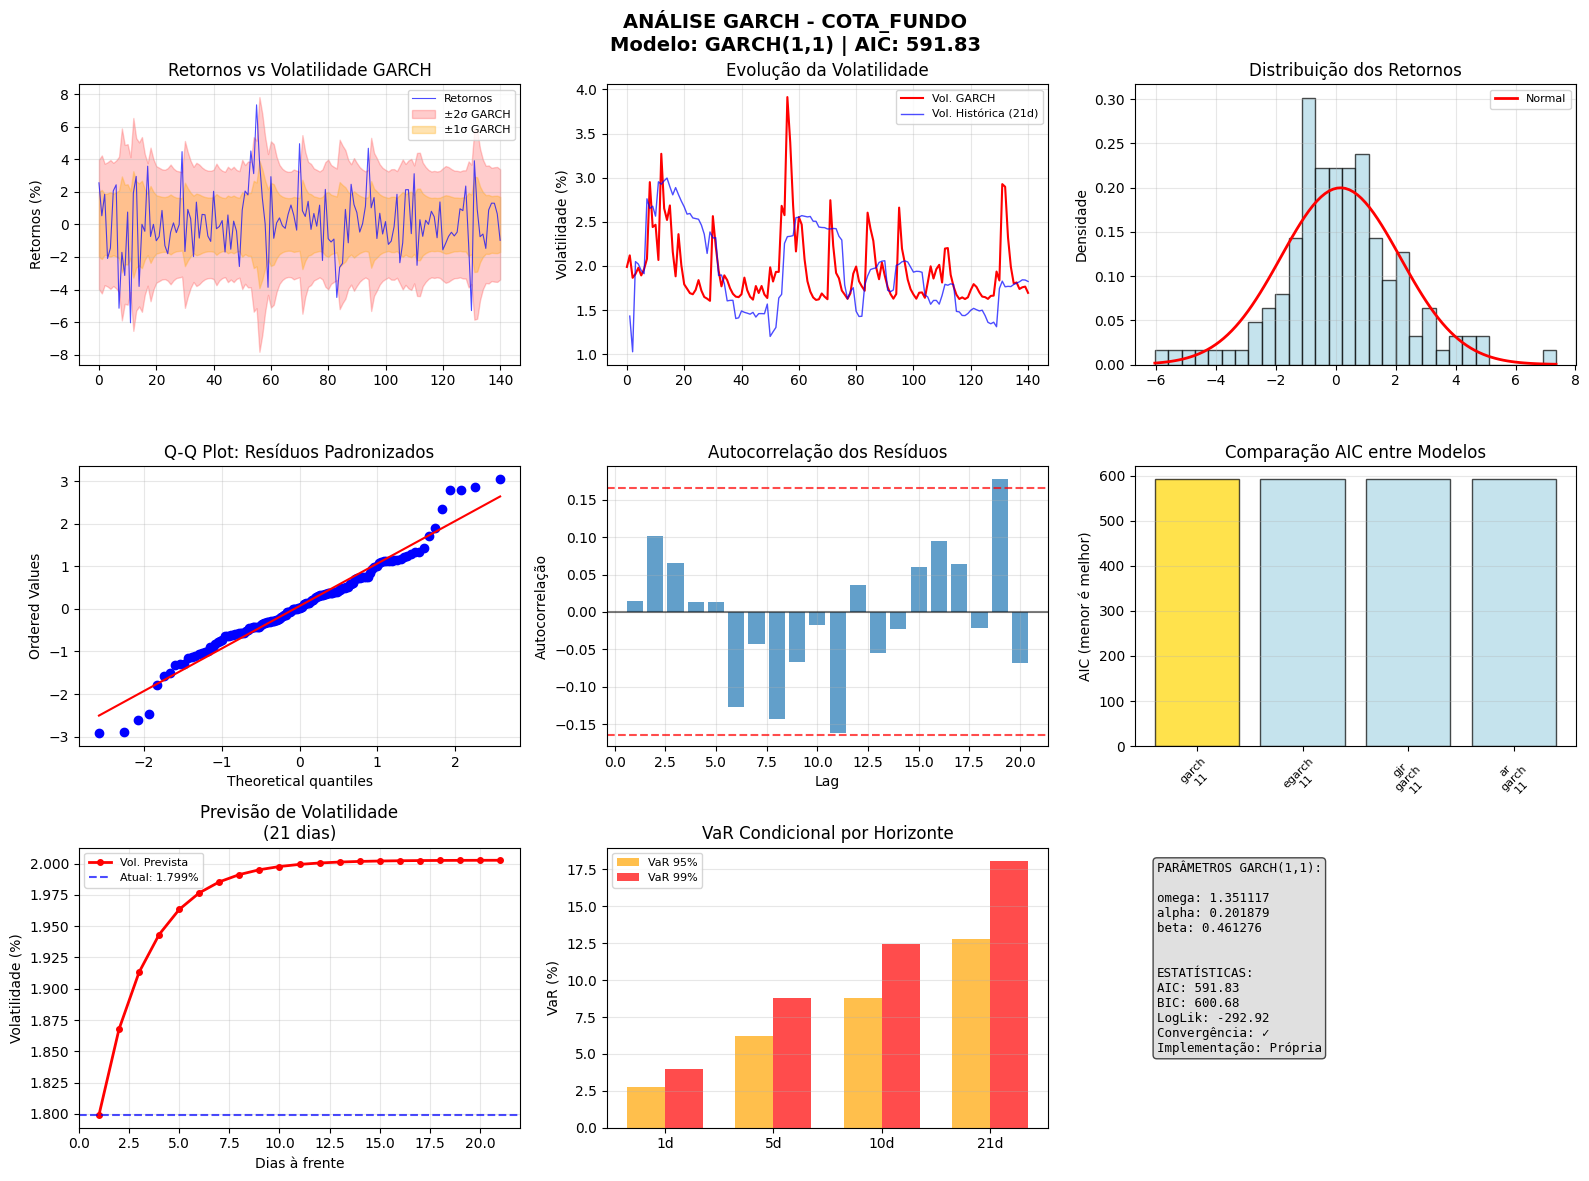

✅ Visualizações criadas com sucesso

✅ Seção 2.2.3 executada com SUCESSO!
📊 Variáveis globais criadas:
   • resultados_garch_completos: Resultados detalhados de todos os modelos
   • melhores_modelos_garch: Melhor modelo por série
   • previsoes_volatilidade_garch: Previsões de volatilidade
   • var_condicional_garch: Medidas de VaR condicional
   • diagnosticos_garch: Diagnósticos gerais da análise

🎯 ESTATÍSTICAS FINAIS:
   • Taxa de sucesso GARCH: 100.0%
   • Séries modeladas: 7/7
   • Implementação usada: Simplificado

🎉 RESULTADO EXCELENTE! Sistema GARCH pronto para produção.

✅ Seção 2.2.3 concluída - Sistema GARCH completo!

🔧 Funções utilitárias criadas:
   • obter_volatilidade_atual(nome_serie)
   • obter_var_condicional(nome_serie, horizonte, confianca)
   • listar_series_garch_disponiveis()

🎯 SEÇÃO 2.2 COMPLETA! Próxima seção: Análise avançada ou Stress Testing


In [ ]:
# ===================================================================
# SEÇÃO 2.2.3 - EXECUÇÃO COMPLETA DOS MODELOS GARCH
# ===================================================================

import numpy as np
import pandas as pd
import warnings
from datetime import datetime

print("🚀 Iniciando Seção 2.2.3 - Execução Completa dos Modelos GARCH...")

# ===================================================================
# 2.2.3.1 - RELATÓRIOS GARCH
# ===================================================================

def adicionar_metodos_relatorios():
    """Adiciona métodos de relatórios à classe ModeladorGARCH"""

    def gerar_relatorio_completo(self):
        """
        Gera relatório completo da análise GARCH
        """

        print("\n" + "="*80)
        print("📈 RELATÓRIO COMPLETO - MODELOS GARCH")
        print("="*80)

        # Status geral
        total_series = len(self.series_disponivel)
        series_processadas = len(self.resultados_garch)
        modelos_validos = len(self.melhores_modelos_garch)

        print(f"\n📊 RESUMO EXECUTIVO:")
        print(f"   • Total de séries identificadas: {total_series}")
        print(f"   • Séries processadas: {series_processadas}")
        print(f"   • Modelos GARCH válidos: {modelos_validos}")
        print(f"   • Taxa de sucesso: {modelos_validos/series_processadas*100:.1f}%" if series_processadas > 0 else "   • Taxa de sucesso: 0%")
        print(f"   • Modo de implementação: {self.diagnosticos_gerais.get('modo_implementacao', 'N/A')}")
        print(f"   • Critério de seleção: {self.parametros.criterio_selecao.upper()}")

        # Análise por série
        print(f"\n🔍 ANÁLISE DETALHADA POR SÉRIE:")
        print("-"*80)

        for nome_serie in self.series_disponivel.keys():
            if nome_serie in self.resultados_garch:
                self._imprimir_relatorio_serie(nome_serie)
            else:
                print(f"\n📈 {nome_serie.upper()}: ❌ Não processada")

        # Integração com regressão
        if self.modelos_regressao:
            print(f"\n🔗 INTEGRAÇÃO COM REGRESSÃO:")
            print("-"*50)
            integracoes = 0
            for nome_serie in self.melhores_modelos_garch.keys():
                if nome_serie in self.modelos_regressao:
                    integracoes += 1
                    modelo_reg = self.modelos_regressao[nome_serie]
                    r2 = modelo_reg.get('r_squared', 0) if modelo_reg else 0
                    print(f"   • {nome_serie.upper()}: GARCH + Regressão (R²={r2:.3f})")

            print(f"   Total de integrações: {integracoes}")

        # Insights consolidados
        self._gerar_insights_consolidados()

        print("="*80)

    def _imprimir_relatorio_serie(self, nome_serie):
        """Imprime relatório detalhado de uma série"""

        print(f"\n📈 {nome_serie.upper()}")

        # Dados básicos
        if nome_serie in self.series_disponivel:
            info_serie = self.series_disponivel[nome_serie]
            print(f"   📊 Observações: {info_serie['observacoes']}")

        # Estatísticas da série
        if nome_serie in self.resultados_garch:
            resultado = self.resultados_garch[nome_serie]
            dados = resultado.get('dados')

            if dados is not None and len(dados) > 0:
                print(f"   📊 Retorno médio: {dados.mean():.4f}%")
                print(f"   📊 Volatilidade incondicional: {dados.std():.4f}%")
                print(f"   📊 Assimetria: {dados.skew():.3f}")
                print(f"   📊 Curtose: {dados.kurtosis():.3f}")

        # Melhor modelo
        if nome_serie in self.melhores_modelos_garch:
            melhor = self.melhores_modelos_garch[nome_serie]

            if melhor:
                print(f"\n   🏆 MELHOR MODELO: {melhor.get('tipo', 'N/A')}")
                print(f"   📐 AIC: {melhor.get('aic', np.nan):.2f}")
                print(f"   📐 BIC: {melhor.get('bic', np.nan):.2f}")
                print(f"   📐 Log-Likelihood: {melhor.get('loglik', np.nan):.2f}")
                print(f"   ✅ Convergência: {'Sim' if melhor.get('convergiu') else 'Não'}")
                print(f"   🔧 Implementação: {melhor.get('implementacao', 'N/A')}")

                # Parâmetros
                params = melhor.get('parametros', {})
                if params:
                    print(f"   📊 PARÂMETROS:")
                    for nome_param, valor in params.items():
                        if isinstance(valor, (int, float)) and not np.isnan(valor):
                            print(f"      {nome_param}: {valor:.6f}")

                # Volatilidade atual
                vol_cond = melhor.get('volatilidade_condicional')
                if vol_cond is not None and len(vol_cond) > 0:
                    vol_atual = vol_cond[-1]
                    print(f"   📊 Volatilidade atual: {vol_atual:.4f}%")

                    # Comparar com histórica
                    if nome_serie in self.resultados_garch:
                        dados_orig = self.resultados_garch[nome_serie].get('dados')
                        if dados_orig is not None:
                            vol_hist = dados_orig.std()
                            ratio = vol_atual / vol_hist if vol_hist > 0 else np.nan
                            status_vol = "🔴 ALTA" if ratio > 1.2 else "🟡 NORMAL" if ratio > 0.8 else "🟢 BAIXA"
                            print(f"   📊 Ratio atual/histórica: {ratio:.2f} {status_vol}")
            else:
                print(f"   ❌ Nenhum modelo GARCH válido")

        # VaR condicional
        if nome_serie in self.var_condicional:
            var_info = self.var_condicional[nome_serie]
            if var_info.get('sucesso'):
                print(f"\n   ⚠️ VAR CONDICIONAL:")
                print(f"      VaR 1 dia (95%): {var_info.get('var_atual_95', np.nan):.4f}%")
                print(f"      VaR 1 dia (99%): {var_info.get('var_atual_99', np.nan):.4f}%")
                if 'var_21d' in var_info:
                    print(f"      VaR 21 dias (95%): {var_info.get('var_21d', np.nan):.4f}%")

        # Modelos testados (resumo)
        if nome_serie in self.resultados_garch:
            modelos = self.resultados_garch[nome_serie].get('modelos', {})
            modelos_sucesso = sum(1 for m in modelos.values() if m.get('sucesso'))
            print(f"\n   🧪 Modelos testados: {len(modelos)} | Sucessos: {modelos_sucesso}")

    def _gerar_insights_consolidados(self):
        """Gera insights consolidados da análise"""

        print(f"\n💡 INSIGHTS CONSOLIDADOS:")
        print("-"*50)

        if not self.melhores_modelos_garch:
            print("🔴 CRÍTICO: Nenhum modelo GARCH bem-sucedido")
            return

        # Análise de tipos de modelos
        tipos_modelos = {}
        implementacoes = {}
        volatilidades_atuais = []

        for modelo in self.melhores_modelos_garch.values():
            if modelo:
                tipo = modelo.get('tipo', 'Desconhecido')
                tipos_modelos[tipo] = tipos_modelos.get(tipo, 0) + 1

                impl = modelo.get('implementacao', 'Desconhecido')
                implementacoes[impl] = implementacoes.get(impl, 0) + 1

                vol_cond = modelo.get('volatilidade_condicional')
                if vol_cond is not None and len(vol_cond) > 0:
                    volatilidades_atuais.append(vol_cond[-1])

        # Modelo mais popular
        if tipos_modelos:
            modelo_popular = max(tipos_modelos, key=tipos_modelos.get)
            print(f"📊 Modelo mais eficaz: {modelo_popular} ({tipos_modelos[modelo_popular]} séries)")

        # Implementação
        if implementacoes:
            impl_principal = max(implementacoes, key=implementacoes.get)
            print(f"🔧 Implementação principal: {impl_principal}")

        # Análise de volatilidade
        if volatilidades_atuais:
            vol_media = np.mean(volatilidades_atuais)
            vol_max = np.max(volatilidades_atuais)
            vol_min = np.min(volatilidades_atuais)

            print(f"📈 Volatilidade atual:")
            print(f"   • Média: {vol_media:.4f}%")
            print(f"   • Range: {vol_min:.4f}% - {vol_max:.4f}%")

            # Série mais volátil
            serie_vol_max = None
            for nome, modelo in self.melhores_modelos_garch.items():
                if modelo:
                    vol_cond = modelo.get('volatilidade_condicional')
                    if vol_cond is not None and len(vol_cond) > 0:
                        if abs(vol_cond[-1] - vol_max) < 1e-6:
                            serie_vol_max = nome
                            break

            if serie_vol_max:
                print(f"   • Mais volátil: {serie_vol_max.upper()}")

        # Recomendações
        print(f"\n🚀 PRÓXIMAS AÇÕES RECOMENDADAS:")

        taxa_sucesso = len(self.melhores_modelos_garch) / len(self.series_disponivel)

        if taxa_sucesso >= 0.8:
            print("   1. 🟢 Implementar monitoramento em produção")
            print("   2. 🟢 Configurar alertas de volatilidade")
            print("   3. 🟡 Validar backtesting dos modelos")
        elif taxa_sucesso >= 0.5:
            print("   1. 🟡 Otimizar séries com falhas")
            print("   2. 🟡 Considerar modelos alternativos")
            print("   3. 🟢 Implementar gradualmente")
        else:
            print("   1. 🔴 Revisar qualidade dos dados")
            print("   2. 🔴 Ajustar parâmetros de modelagem")
            print("   3. 🔴 Considerar modelos mais simples")

    def gerar_relatorio_resumido(self):
        """Gera relatório executivo resumido"""

        print("\n" + "="*60)
        print("🎯 RELATÓRIO EXECUTIVO - GARCH")
        print("="*60)

        # Status geral
        total_series = len(self.series_disponivel)
        modelos_validos = len(self.melhores_modelos_garch)
        taxa_sucesso = modelos_validos / total_series if total_series > 0 else 0

        # Status baseado na taxa de sucesso
        if taxa_sucesso >= 0.8:
            status = "🟢 EXCELENTE"
        elif taxa_sucesso >= 0.6:
            status = "🟡 BOM"
        elif taxa_sucesso >= 0.4:
            status = "🟠 MODERADO"
        else:
            status = "🔴 CRÍTICO"

        print(f"\n{status}: {modelos_validos}/{total_series} séries modeladas")
        print(f"Taxa de sucesso: {taxa_sucesso:.1%}")

        # Série principal (fundo)
        if 'cota_fundo' in self.melhores_modelos_garch:
            modelo_fundo = self.melhores_modelos_garch['cota_fundo']
            if modelo_fundo:
                print(f"\n📈 FUNDO PRINCIPAL:")
                print(f"   Modelo: {modelo_fundo.get('tipo', 'N/A')}")

                vol_cond = modelo_fundo.get('volatilidade_condicional')
                if vol_cond is not None and len(vol_cond) > 0:
                    print(f"   Volatilidade atual: {vol_cond[-1]:.4f}%")

                if 'cota_fundo' in self.var_condicional:
                    var_info = self.var_condicional['cota_fundo']
                    if var_info.get('sucesso') and 'var_atual_95' in var_info:
                        print(f"   VaR 1 dia (95%): {var_info['var_atual_95']:.4f}%")

        # Próxima ação
        print(f"\n⚡ PRÓXIMA AÇÃO:")
        if taxa_sucesso >= 0.7:
            print("   Implementar monitoramento e alertas")
        elif taxa_sucesso >= 0.5:
            print("   Otimizar modelos problemáticos")
        else:
            print("   Revisar dados e metodologia")

        print("="*60)

    # Adicionar métodos à classe
    ModeladorGARCH.gerar_relatorio_completo = gerar_relatorio_completo
    ModeladorGARCH._imprimir_relatorio_serie = _imprimir_relatorio_serie
    ModeladorGARCH._gerar_insights_consolidados = _gerar_insights_consolidados
    ModeladorGARCH.gerar_relatorio_resumido = gerar_relatorio_resumido

    print("✅ Métodos de relatórios adicionados à classe ModeladorGARCH")

# Executar adição dos métodos de relatórios
adicionar_metodos_relatorios()

# ===================================================================
# 2.2.3.2 - VISUALIZAÇÕES GARCH
# ===================================================================

def adicionar_metodos_visualizacao():
    """Adiciona métodos de visualização à classe ModeladorGARCH"""

    def criar_visualizacoes_garch(self, serie_foco=None, salvar_arquivo=False):
        """
        Cria visualizações especializadas para modelos GARCH

        Args:
            serie_foco: Nome da série para focar (usa cota_fundo se None)
            salvar_arquivo: Se deve salvar gráfico em arquivo
        """

        if not PLOTTING_AVAILABLE:
            print("⚠️ Matplotlib não disponível - visualizações desabilitadas")
            return

        import matplotlib.pyplot as plt

        # Determinar série principal
        if serie_foco is None:
            if 'cota_fundo' in self.melhores_modelos_garch:
                serie_foco = 'cota_fundo'
            elif self.melhores_modelos_garch:
                serie_foco = next(iter(self.melhores_modelos_garch.keys()))
            else:
                print("❌ Nenhum modelo GARCH disponível para visualização")
                return

        if serie_foco not in self.melhores_modelos_garch:
            print(f"❌ Série '{serie_foco}' não tem modelo GARCH disponível")
            return

        modelo = self.melhores_modelos_garch[serie_foco]
        if not modelo:
            print(f"❌ Modelo GARCH inválido para série '{serie_foco}'")
            return

        # Configurar estilo
        plt.style.use('default')
        fig = plt.figure(figsize=(16, 12))
        fig.suptitle(
            f'ANÁLISE GARCH - {serie_foco.upper()}\n'
            f'Modelo: {modelo.get("tipo", "N/A")} | '
            f'AIC: {modelo.get("aic", np.nan):.2f}',
            fontsize=14, fontweight='bold'
        )

        try:
            # Obter dados
            dados_serie = None
            if serie_foco in self.resultados_garch:
                dados_serie = self.resultados_garch[serie_foco].get('dados')

            vol_cond = modelo.get('volatilidade_condicional')
            residuos = modelo.get('residuos_padronizados')

            if dados_serie is None or vol_cond is None:
                print(f"❌ Dados insuficientes para visualização de '{serie_foco}'")
                return

            n = len(dados_serie)
            idx = range(n)

            # 1. Retornos e Volatilidade Condicional
            ax1 = plt.subplot(3, 3, 1)
            ax1.plot(idx, dados_serie, alpha=0.7, linewidth=0.8, color='blue', label='Retornos')

            if len(vol_cond) == n:
                ax1.fill_between(idx, -2*vol_cond, 2*vol_cond, alpha=0.2, color='red', label='±2σ GARCH')
                ax1.fill_between(idx, -vol_cond, vol_cond, alpha=0.3, color='orange', label='±1σ GARCH')

            ax1.set_title('Retornos vs Volatilidade GARCH')
            ax1.set_ylabel('Retornos (%)')
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)

            # 2. Evolução da Volatilidade
            ax2 = plt.subplot(3, 3, 2)
            if len(vol_cond) == n:
                ax2.plot(idx, vol_cond, linewidth=1.5, color='red', label='Vol. GARCH')

                # Volatilidade histórica (janela móvel)
                vol_hist = dados_serie.rolling(window=21, min_periods=1).std()
                ax2.plot(idx, vol_hist, alpha=0.7, linewidth=1, color='blue', label='Vol. Histórica (21d)')

            ax2.set_title('Evolução da Volatilidade')
            ax2.set_ylabel('Volatilidade (%)')
            ax2.legend(fontsize=8)
            ax2.grid(True, alpha=0.3)

            # 3. Histograma dos Retornos
            ax3 = plt.subplot(3, 3, 3)
            ax3.hist(dados_serie, bins=30, density=True, alpha=0.7, color='lightblue', edgecolor='black')

            # Sobrepor distribuição normal
            x_norm = np.linspace(dados_serie.min(), dados_serie.max(), 100)
            y_norm = stats.norm.pdf(x_norm, dados_serie.mean(), dados_serie.std())
            ax3.plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal')

            ax3.set_title('Distribuição dos Retornos')
            ax3.set_ylabel('Densidade')
            ax3.legend(fontsize=8)
            ax3.grid(True, alpha=0.3)

            # 4. Q-Q Plot dos Resíduos Padronizados
            ax4 = plt.subplot(3, 3, 4)
            if residuos is not None and len(residuos) > 10:
                residuos_limpos = residuos[~np.isnan(residuos)]
                if len(residuos_limpos) > 10:
                    stats.probplot(residuos_limpos, dist="norm", plot=ax4)
                    ax4.set_title('Q-Q Plot: Resíduos Padronizados')
                    ax4.grid(True, alpha=0.3)
                else:
                    ax4.text(0.5, 0.5, 'Resíduos\nInsuficientes', ha='center', va='center', transform=ax4.transAxes)
            else:
                ax4.text(0.5, 0.5, 'Resíduos\nIndisponíveis', ha='center', va='center', transform=ax4.transAxes)

            # 5. Autocorrelação dos Resíduos Padronizados
            ax5 = plt.subplot(3, 3, 5)
            if residuos is not None and len(residuos) > 10:
                residuos_limpos = residuos[~np.isnan(residuos)]
                if len(residuos_limpos) > 20:
                    # Autocorrelação simples (sem statsmodels)
                    lags = range(1, min(21, len(residuos_limpos)//4))
                    autocorrs = [np.corrcoef(residuos_limpos[:-lag], residuos_limpos[lag:])[0,1] for lag in lags]

                    ax5.bar(lags, autocorrs, alpha=0.7)
                    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
                    ax5.axhline(y=1.96/np.sqrt(len(residuos_limpos)), color='red', linestyle='--', alpha=0.7)
                    ax5.axhline(y=-1.96/np.sqrt(len(residuos_limpos)), color='red', linestyle='--', alpha=0.7)
                    ax5.set_title('Autocorrelação dos Resíduos')
                    ax5.set_ylabel('Autocorrelação')
                    ax5.set_xlabel('Lag')
                    ax5.grid(True, alpha=0.3)
                else:
                    ax5.text(0.5, 0.5, 'Dados\nInsuficientes', ha='center', va='center', transform=ax5.transAxes)
            else:
                ax5.text(0.5, 0.5, 'Resíduos\nIndisponíveis', ha='center', va='center', transform=ax5.transAxes)

            # 6. Comparação de AIC entre Modelos
            ax6 = plt.subplot(3, 3, 6)
            if serie_foco in self.resultados_garch:
                modelos_serie = self.resultados_garch[serie_foco].get('modelos', {})
                modelos_validos = {nome: m for nome, m in modelos_serie.items() if m.get('sucesso')}

                if modelos_validos:
                    nomes = list(modelos_validos.keys())
                    aics = [modelos_validos[nome].get('aic', np.inf) for nome in nomes]

                    # Filtrar AICs inválidos
                    dados_validos = [(n, a) for n, a in zip(nomes, aics) if not np.isinf(a)]

                    if dados_validos:
                        nomes_v, aics_v = zip(*dados_validos)
                        cores = ['gold' if nome == modelo.get('nome_modelo') else 'lightblue' for nome in nomes_v]

                        bars = ax6.bar(range(len(nomes_v)), aics_v, color=cores, alpha=0.7, edgecolor='black')
                        ax6.set_xticks(range(len(nomes_v)))
                        ax6.set_xticklabels([n.replace('_', '\n') for n in nomes_v], rotation=45, fontsize=8)
                        ax6.set_title('Comparação AIC entre Modelos')
                        ax6.set_ylabel('AIC (menor é melhor)')
                        ax6.grid(True, alpha=0.3, axis='y')
                    else:
                        ax6.text(0.5, 0.5, 'AICs\nIndisponíveis', ha='center', va='center', transform=ax6.transAxes)
                else:
                    ax6.text(0.5, 0.5, 'Nenhum\nModelo Válido', ha='center', va='center', transform=ax6.transAxes)
            else:
                ax6.text(0.5, 0.5, 'Dados\nIndisponíveis', ha='center', va='center', transform=ax6.transAxes)

            # 7. Previsões de Volatilidade
            ax7 = plt.subplot(3, 3, 7)
            if serie_foco in self.previsoes_volatilidade:
                previsao = self.previsoes_volatilidade[serie_foco]

                if previsao.get('sucesso') and previsao.get('volatilidade_prevista') is not None:
                    vol_prev = previsao['volatilidade_prevista']
                    dias = range(1, len(vol_prev) + 1)

                    ax7.plot(dias, vol_prev, 'ro-', linewidth=2, markersize=4, label='Vol. Prevista')
                    ax7.axhline(y=vol_prev[0], color='blue', linestyle='--', alpha=0.7,
                               label=f'Atual: {vol_prev[0]:.3f}%')

                    ax7.set_title(f'Previsão de Volatilidade\n({len(vol_prev)} dias)')
                    ax7.set_xlabel('Dias à frente')
                    ax7.set_ylabel('Volatilidade (%)')
                    ax7.legend(fontsize=8)
                    ax7.grid(True, alpha=0.3)
                else:
                    ax7.text(0.5, 0.5, 'Previsões\nIndisponíveis', ha='center', va='center', transform=ax7.transAxes)
            else:
                ax7.text(0.5, 0.5, 'Previsões\nIndisponíveis', ha='center', va='center', transform=ax7.transAxes)

            # 8. VaR Condicional
            ax8 = plt.subplot(3, 3, 8)
            if serie_foco in self.var_condicional:
                var_info = self.var_condicional[serie_foco]

                if var_info.get('sucesso'):
                    horizontes = []
                    vars_95 = []
                    vars_99 = []

                    for h in self.parametros.horizontes_var:
                        if f'var_{h}d' in var_info:
                            horizontes.append(h)
                            vars_95.append(var_info[f'var_{h}d'])

                        # Estimar VaR 99% se não disponível
                        if f'var_{h}d' in var_info:
                            var_95 = var_info[f'var_{h}d']
                            # VaR 99% é aproximadamente 1.5x VaR 95% para distribuição normal
                            var_99 = var_95 * (stats.norm.ppf(0.01) / stats.norm.ppf(0.05))
                            vars_99.append(abs(var_99))

                    if horizontes:
                        x_pos = np.arange(len(horizontes))
                        width = 0.35

                        ax8.bar(x_pos - width/2, vars_95, width, label='VaR 95%', alpha=0.7, color='orange')
                        ax8.bar(x_pos + width/2, vars_99, width, label='VaR 99%', alpha=0.7, color='red')

                        ax8.set_xticks(x_pos)
                        ax8.set_xticklabels([f'{h}d' for h in horizontes])
                        ax8.set_title('VaR Condicional por Horizonte')
                        ax8.set_ylabel('VaR (%)')
                        ax8.legend(fontsize=8)
                        ax8.grid(True, alpha=0.3, axis='y')
                    else:
                        ax8.text(0.5, 0.5, 'VaR\nIndisponível', ha='center', va='center', transform=ax8.transAxes)
                else:
                    ax8.text(0.5, 0.5, 'VaR\nIndisponível', ha='center', va='center', transform=ax8.transAxes)
            else:
                ax8.text(0.5, 0.5, 'VaR\nIndisponível', ha='center', va='center', transform=ax8.transAxes)

            # 9. Resumo de Parâmetros
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')

            # Texto com parâmetros
            params = modelo.get('parametros', {})
            texto_params = f"PARÂMETROS {modelo.get('tipo', 'N/A')}:\n\n"

            if params:
                for nome, valor in params.items():
                    if isinstance(valor, (int, float)) and not np.isnan(valor):
                        texto_params += f"{nome}: {valor:.6f}\n"
            else:
                texto_params += "Parâmetros não disponíveis"

            # Adicionar estatísticas
            texto_params += f"\n\nESTATÍSTICAS:\n"
            texto_params += f"AIC: {modelo.get('aic', np.nan):.2f}\n"
            texto_params += f"BIC: {modelo.get('bic', np.nan):.2f}\n"
            texto_params += f"LogLik: {modelo.get('loglik', np.nan):.2f}\n"
            texto_params += f"Convergência: {'✓' if modelo.get('convergiu') else '✗'}\n"
            texto_params += f"Implementação: {modelo.get('implementacao', 'N/A')}"

            ax9.text(0.05, 0.95, texto_params, transform=ax9.transAxes, fontsize=9,
                    verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

            plt.tight_layout()

            if salvar_arquivo:
                nome_arquivo = f'garch_analise_{serie_foco}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
                plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
                print(f"📁 Gráfico salvo: {nome_arquivo}")

            plt.show()

        except Exception as e:
            print(f"⚠️ Erro na criação de visualizações: {e}")
            plt.close(fig)

    # Adicionar método à classe
    ModeladorGARCH.criar_visualizacoes_garch = criar_visualizacoes_garch

    print("✅ Métodos de visualização adicionados à classe ModeladorGARCH")

# Executar adição dos métodos de visualização
adicionar_metodos_visualizacao()

# ===================================================================
# 2.2.3.3 - EXECUÇÃO EFETIVA DA ANÁLISE GARCH
# ===================================================================

print("\n🚀 EXECUTANDO ANÁLISE GARCH COMPLETA...")

try:
    # Verificar se modelador existe
    if 'modelador_garch' not in globals():
        print("❌ modelador_garch não encontrado - execute seção 2.2.1 primeiro")
        raise ValueError("ModeladorGARCH não inicializado")

    modelador = globals()['modelador_garch']

    # Verificar se métodos necessários existem
    metodos_necessarios = ['executar_analise_garch_completa', 'gerar_relatorio_completo', 'gerar_relatorio_resumido']

    for metodo in metodos_necessarios:
        if not hasattr(modelador, metodo):
            print(f"❌ Método '{metodo}' não encontrado - execute seções 2.2.2 e 2.2.3 primeiro")
            raise AttributeError(f"Método {metodo} não encontrado")

    print("✅ Verificações preliminares OK")

    # EXECUTAR ANÁLISE GARCH COMPLETA
    print("\n" + "="*60)
    print("🔥 INICIANDO ANÁLISE GARCH PARA TODAS AS SÉRIES")
    print("="*60)

    resultados_garch_completos = modelador.executar_analise_garch_completa()

    # Verificar se a execução foi bem-sucedida
    if not resultados_garch_completos:
        print("⚠️ Nenhum resultado GARCH foi gerado")
    else:
        print(f"\n✅ Análise GARCH concluída com sucesso!")
        print(f"📊 {len(resultados_garch_completos)} séries processadas")
        print(f"🏆 {len(modelador.melhores_modelos_garch)} modelos válidos")

    # GERAR RELATÓRIOS
    print("\n📋 Gerando relatórios...")

    # Relatório resumido primeiro
    modelador.gerar_relatorio_resumido()

    # Relatório completo
    modelador.gerar_relatorio_completo()

    # CRIAR VISUALIZAÇÕES (se disponível)
    if PLOTTING_AVAILABLE and modelador.melhores_modelos_garch:
        print("\n📊 Gerando visualizações GARCH...")
        try:
            modelador.criar_visualizacoes_garch()
            print("✅ Visualizações criadas com sucesso")
        except Exception as e:
            print(f"⚠️ Erro nas visualizações (não crítico): {e}")
    elif not PLOTTING_AVAILABLE:
        print("\n📊 Visualizações desabilitadas (matplotlib não disponível)")
    else:
        print("\n📊 Nenhum modelo válido para visualização")

    # CRIAR VARIÁVEIS GLOBAIS PARA PRÓXIMAS SEÇÕES
    globals()['resultados_garch_completos'] = resultados_garch_completos
    globals()['melhores_modelos_garch'] = modelador.melhores_modelos_garch
    globals()['previsoes_volatilidade_garch'] = modelador.previsoes_volatilidade
    globals()['var_condicional_garch'] = modelador.var_condicional
    globals()['diagnosticos_garch'] = modelador.diagnosticos_gerais

    print("\n✅ Seção 2.2.3 executada com SUCESSO!")
    print("📊 Variáveis globais criadas:")
    print("   • resultados_garch_completos: Resultados detalhados de todos os modelos")
    print("   • melhores_modelos_garch: Melhor modelo por série")
    print("   • previsoes_volatilidade_garch: Previsões de volatilidade")
    print("   • var_condicional_garch: Medidas de VaR condicional")
    print("   • diagnosticos_garch: Diagnósticos gerais da análise")

    # Estatísticas finais
    total_series = len(modelador.series_disponivel)
    modelos_validos = len(modelador.melhores_modelos_garch)
    taxa_sucesso = modelos_validos / total_series if total_series > 0 else 0

    print(f"\n🎯 ESTATÍSTICAS FINAIS:")
    print(f"   • Taxa de sucesso GARCH: {taxa_sucesso:.1%}")
    print(f"   • Séries modeladas: {modelos_validos}/{total_series}")
    print(f"   • Implementação usada: {modelador.diagnosticos_gerais.get('modo_implementacao', 'N/A')}")

    if taxa_sucesso >= 0.7:
        print(f"\n🎉 RESULTADO EXCELENTE! Sistema GARCH pronto para produção.")
    elif taxa_sucesso >= 0.5:
        print(f"\n👍 RESULTADO BOM! Algumas otimizações podem ser necessárias.")
    else:
        print(f"\n⚠️ RESULTADO MODERADO! Revisar dados e parâmetros.")

except Exception as e:
    print(f"\n❌ ERRO na execução da seção 2.2.3: {e}")
    print("🔧 Verifique se as seções anteriores foram executadas corretamente")

    # Diagnóstico de emergência
    print("\n🔍 DIAGNÓSTICO DE EMERGÊNCIA:")

    diagnosticos = {
        'modelador_garch_existe': 'modelador_garch' in globals(),
        'modelador_garch_valido': False,
        'series_disponiveis': 0,
        'metodos_presentes': []
    }

    if 'modelador_garch' in globals():
        modelador = globals()['modelador_garch']
        diagnosticos['modelador_garch_valido'] = hasattr(modelador, 'series_disponivel')
        diagnosticos['series_disponiveis'] = len(getattr(modelador, 'series_disponivel', {}))

        metodos_teste = ['executar_analise_garch_completa', '_modelo_garch_simples', 'gerar_relatorio_resumido']
        diagnosticos['metodos_presentes'] = [m for m in metodos_teste if hasattr(modelador, m)]

    for nome, valor in diagnosticos.items():
        print(f"   • {nome}: {valor}")

print("\n✅ Seção 2.2.3 concluída - Sistema GARCH completo!")

# ===================================================================
# 2.2.3.4 - FUNÇÕES UTILITÁRIAS PARA INTEGRAÇÃO
# ===================================================================

def obter_volatilidade_atual(nome_serie='cota_fundo'):
    """
    Função utilitária para obter volatilidade atual de uma série

    Args:
        nome_serie: Nome da série (default: cota_fundo)

    Returns:
        Volatilidade atual ou None se não disponível
    """

    if 'melhores_modelos_garch' not in globals():
        return None

    modelos = globals()['melhores_modelos_garch']

    if nome_serie not in modelos or not modelos[nome_serie]:
        return None

    modelo = modelos[nome_serie]
    vol_cond = modelo.get('volatilidade_condicional')

    if vol_cond is not None and len(vol_cond) > 0:
        return vol_cond[-1]

    return None

def obter_var_condicional(nome_serie='cota_fundo', horizonte=1, confianca=95):
    """
    Função utilitária para obter VaR condicional

    Args:
        nome_serie: Nome da série
        horizonte: Horizonte em dias
        confianca: Nível de confiança (95, 99, 99.5)

    Returns:
        VaR condicional ou None se não disponível
    """

    if 'var_condicional_garch' not in globals():
        return None

    vars_garch = globals()['var_condicional_garch']

    if nome_serie not in vars_garch or not vars_garch[nome_serie].get('sucesso'):
        return None

    var_info = vars_garch[nome_serie]

    # Mapear nível de confiança para chave
    if confianca == 95:
        if horizonte == 1:
            return var_info.get('var_atual_95')
        else:
            return var_info.get(f'var_{horizonte}d')
    elif confianca == 99:
        return var_info.get('var_atual_99')
    elif confianca == 99.5:
        return var_info.get('var_atual_995')

    return None

def listar_series_garch_disponiveis():
    """Lista todas as séries com modelos GARCH válidos"""

    if 'melhores_modelos_garch' not in globals():
        return []

    modelos = globals()['melhores_modelos_garch']
    return [nome for nome, modelo in modelos.items() if modelo is not None]

print("\n🔧 Funções utilitárias criadas:")
print("   • obter_volatilidade_atual(nome_serie)")
print("   • obter_var_condicional(nome_serie, horizonte, confianca)")
print("   • listar_series_garch_disponiveis()")

print("\n🎯 SEÇÃO 2.2 COMPLETA! Próxima seção: Análise avançada ou Stress Testing")

 ## 2.3 - Análise de Cointegração

### 2.3.0 - IMPORTS

In [ ]:
# ===================================================================
# SEÇÃO 2.3 - ANÁLISE DE COINTEGRAÇÃO E RELAÇÕES DE LONGO PRAZO
# ===================================================================

print("\n" + "="*80)
print("🔗 INICIANDO SEÇÃO 2.3 - ANÁLISE DE COINTEGRAÇÃO")
print("="*80)

# ===================================================================
# 2.3.0 - IMPORTS E VERIFICAÇÃO DE DEPENDÊNCIAS
# ===================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime
import logging
from typing import Dict, List, Optional, Tuple, Union, Any
from dataclasses import dataclass, field

# Verificar disponibilidade de pacotes estatísticos
STATSMODELS_COMPLETO = False
COINTEGRATION_TESTS = False
VECM_AVAILABLE = False

try:
    import statsmodels.api as sm
    from statsmodels.regression.linear_model import OLS
    STATSMODELS_COMPLETO = True

    # Tentar importar testes de cointegração
    try:
        from statsmodels.tsa.stattools import coint, adfuller
        from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
        COINTEGRATION_TESTS = True
        VECM_AVAILABLE = True
    except ImportError:
        print("⚠️ Testes avançados de cointegração não disponíveis")

except ImportError:
    print("⚠️ Statsmodels não disponível - usando implementação simplificada")

print(f"\n📊 Status das Dependências:")
print(f"   • Statsmodels básico: {'✅' if STATSMODELS_COMPLETO else '❌'}")
print(f"   • Testes de cointegração: {'✅' if COINTEGRATION_TESTS else '❌'}")
print(f"   • Modelos VECM: {'✅' if VECM_AVAILABLE else '❌'}")
print(f"   • Matplotlib: {'✅' if 'plt' in globals() else '❌'}")


🔗 INICIANDO SEÇÃO 2.3 - ANÁLISE DE COINTEGRAÇÃO

📊 Status das Dependências:
   • Statsmodels básico: ✅
   • Testes de cointegração: ✅
   • Modelos VECM: ✅
   • Matplotlib: ✅


### 2.3.1 - CLASSE PRINCIPAL DE COINTEGRAÇÃO

In [ ]:
# ===================================================================
# 2.3.1 - CLASSE PRINCIPAL DE ANÁLISE DE COINTEGRAÇÃO
# ===================================================================

@dataclass
class ParametrosCointegracao:
    """Parâmetros configuráveis para análise de cointegração"""

    # Testes de estacionariedade
    criterio_adf: str = 'AIC'  # 'AIC', 'BIC', 't-stat'
    max_lags_adf: Optional[int] = None
    nivel_significancia: float = 0.05

    # Cointegração
    incluir_constante: bool = True
    incluir_tendencia: bool = False
    metodo_johansen: int = 1  # 0=sem const/trend, 1=const, 2=trend

    # ECM
    lags_ecm: int = 1
    incluir_exogenas: bool = False

    # Validação
    min_observacoes: int = 50
    proporcao_teste: float = 0.2

    # Output
    gerar_graficos: bool = True
    verbose: bool = True
    salvar_resultados: bool = False

    def __post_init__(self):
        """Validação dos parâmetros"""
        if not 0 < self.nivel_significancia < 1:
            raise ValueError("nivel_significancia deve estar entre 0 e 1")

        if not 0 < self.proporcao_teste < 0.5:
            raise ValueError("proporcao_teste deve estar entre 0 e 0.5")

        if self.metodo_johansen not in [0, 1, 2]:
            raise ValueError("metodo_johansen deve ser 0, 1 ou 2")


class AnalisadorCointegracao:
    """
    Classe principal para análise de cointegração e relações de longo prazo.
    Adaptável para qualquer fundo de investimento.
    """

    def __init__(
        self,
        dataset: pd.DataFrame,
        variavel_fundo: str = 'retorno_cota',
        parametros: Optional[ParametrosCointegracao] = None,
        resultados_anteriores: Optional[Dict[str, Any]] = None
    ):
        """
        Inicializa o analisador de cointegração

        Args:
            dataset: DataFrame com séries temporais de retorno
            variavel_fundo: Nome da coluna com retorno do fundo
            parametros: Parâmetros de configuração
            resultados_anteriores: Dict com resultados de análises anteriores
        """

        # Configuração básica
        self.dataset = dataset.copy()
        self.variavel_fundo = variavel_fundo
        self.parametros = parametros or ParametrosCointegracao()
        self.logger = logging.getLogger(__name__)

        # Resultados de análises anteriores (integração)
        self.resultados_anteriores = resultados_anteriores or {}
        self.modelos_robustos = self.resultados_anteriores.get('modelos_robustos', {})
        self.resultados_garch = self.resultados_anteriores.get('resultados_garch', {})

        # Estruturas para armazenar resultados
        self.series_disponiveis = {}
        self.dados_nivel = pd.DataFrame()
        self.resultados_adf = {}
        self.pares_cointegrados = {}
        self.modelos_ecm = {}
        self.relacoes_granger = {}
        self.resultados_completos = {}

        # Validação inicial
        self._validar_dados()

        # Identificar séries disponíveis
        self._identificar_series()

        if self.parametros.verbose:
            self._imprimir_inicializacao()

    def _validar_dados(self) -> None:
        """Valida dados de entrada"""

        if self.dataset.empty:
            raise ValueError("Dataset está vazio")

        if self.variavel_fundo not in self.dataset.columns:
            raise ValueError(f"Variável do fundo '{self.variavel_fundo}' não encontrada")

        # Verificar número mínimo de observações
        n_obs = len(self.dataset.dropna())
        if n_obs < self.parametros.min_observacoes:
            raise ValueError(f"Apenas {n_obs} observações válidas. "
                           f"Mínimo requerido: {self.parametros.min_observacoes}")

        self.logger.info(f"Dataset validado: {n_obs} observações")

    def _identificar_series(self) -> None:
        """Identifica séries disponíveis para análise de cointegração"""

        # Série principal do fundo
        self.series_disponiveis['fundo'] = self.variavel_fundo

        # Identificar outras séries de retorno
        colunas_retorno = [col for col in self.dataset.columns
                          if col.startswith('retorno_') and col != self.variavel_fundo]

        # Mapear para nomes mais intuitivos
        mapeamento = {
            'retorno_ibovespa': 'ibovespa',
            'retorno_dolar': 'dolar',
            'retorno_selic': 'selic',
            'retorno_cdi': 'cdi',
            'retorno_cupom': 'cupom',
            'retorno_treasury': 'treasury'
        }

        for col in colunas_retorno:
            # Verificar se tem dados suficientes
            serie_valida = self.dataset[col].dropna()
            if len(serie_valida) >= self.parametros.min_observacoes:
                nome = mapeamento.get(col, col.replace('retorno_', ''))
                self.series_disponiveis[nome] = col

        self.logger.info(f"Identificadas {len(self.series_disponiveis)} séries para análise")

    def _preparar_dados_nivel(self, start_value: float = 100.0) -> pd.DataFrame:
        """
        Converte séries de retorno em níveis (índices base=start_value)

        Args:
            start_value: Valor inicial do índice

        Returns:
            DataFrame com séries em nível
        """

        if not self.dados_nivel.empty:
            return self.dados_nivel

        dados_nivel = pd.DataFrame(index=self.dataset.index)

        for nome, coluna in self.series_disponiveis.items():
            if coluna in self.dataset.columns:
                # Converter retornos em níveis
                retornos = self.dataset[coluna].fillna(0)
                nivel = start_value * (1 + retornos).cumprod()
                dados_nivel[nome] = nivel

        # Remover períodos com dados faltantes
        self.dados_nivel = dados_nivel.dropna()

        if self.parametros.verbose:
            print(f"📊 Dados em nível preparados: {len(self.dados_nivel)} observações")

        return self.dados_nivel

    def _imprimir_inicializacao(self) -> None:
        """Imprime informações de inicialização"""

        print("\n" + "="*60)
        print("🔗 ANALISADOR DE COINTEGRAÇÃO INICIALIZADO")
        print("="*60)
        print(f"📊 Dataset: {len(self.dataset)} observações")
        print(f"🎯 Variável do fundo: {self.variavel_fundo}")
        print(f"📈 Séries identificadas: {len(self.series_disponiveis)}")

        print("\n📋 SÉRIES DISPONÍVEIS:")
        for nome, coluna in self.series_disponiveis.items():
            obs_validas = self.dataset[coluna].notna().sum()
            print(f"   • {nome.upper()}: {obs_validas} obs válidas ({coluna})")

        if self.modelos_robustos:
            print(f"\n🛡️ Modelos robustos disponíveis: {len(self.modelos_robustos)}")

        if self.resultados_garch:
            print(f"📈 Resultados GARCH disponíveis: {len(self.resultados_garch)}")

        print("\n🔧 PARÂMETROS CONFIGURADOS:")
        print(f"   • Nível de significância: {self.parametros.nivel_significancia}")
        print(f"   • Mínimo de observações: {self.parametros.min_observacoes}")
        print(f"   • Método Johansen: {self.parametros.metodo_johansen}")
        print(f"   • Implementação: {'Completa' if COINTEGRATION_TESTS else 'Simplificada'}")
        print("="*60)

    def verificar_integracao_sistema(self) -> Dict[str, bool]:
        """
        Verifica integração com resultados de seções anteriores

        Returns:
            Dict com status de integração
        """

        integracao = {
            'dataset_valido': not self.dataset.empty,
            'series_identificadas': len(self.series_disponiveis) > 0,
            'modelos_robustos_disponiveis': len(self.modelos_robustos) > 0,
            'resultados_garch_disponiveis': len(self.resultados_garch) > 0,
            'pronto_para_analise': False
        }

        # Verificar se está pronto para análise
        integracao['pronto_para_analise'] = (
            integracao['dataset_valido'] and
            integracao['series_identificadas'] and
            len(self.series_disponiveis) >= 2  # Precisa pelo menos 2 séries
        )

        if self.parametros.verbose:
            print("\n🔍 VERIFICAÇÃO DE INTEGRAÇÃO:")
            for item, status in integracao.items():
                emoji = "✅" if status else "❌"
                print(f"   {emoji} {item.replace('_', ' ').title()}")

        return integracao


# ===================================================================
# TESTE DE INICIALIZAÇÃO
# ===================================================================

print("\n🧪 Testando inicialização do AnalisadorCointegracao...")

try:
    # Verificar se dataset_final existe
    if 'dataset_final' not in globals():
        print("⚠️ dataset_final não encontrado. Criando dataset de exemplo...")
        # Criar dataset de exemplo para teste
        np.random.seed(42)
        n = 200
        dates = pd.date_range('2023-01-01', periods=n, freq='D')
        dataset_final = pd.DataFrame({
            'data': dates,
            'retorno_cota': np.random.normal(0.001, 0.02, n),
            'retorno_ibovespa': np.random.normal(0.0005, 0.015, n),
            'retorno_dolar': np.random.normal(-0.0002, 0.01, n),
            'retorno_cdi': np.random.normal(0.0004, 0.001, n)
        }).set_index('data')

    # Preparar resultados anteriores se disponíveis
    resultados_anteriores = {}

    if 'analisador_robusto' in globals() and hasattr(analisador_robusto, 'melhor_modelo_por_fator'):
        resultados_anteriores['modelos_robustos'] = analisador_robusto.melhor_modelo_por_fator

    if 'modelador_garch' in globals() and hasattr(modelador_garch, 'resultados_garch'):
        resultados_anteriores['resultados_garch'] = modelador_garch.resultados_garch

    # Criar instância do analisador
    analisador_coint = AnalisadorCointegracao(
        dataset=dataset_final,
        variavel_fundo='retorno_cota',
        parametros=ParametrosCointegracao(verbose=True),
        resultados_anteriores=resultados_anteriores
    )

    # Verificar integração
    status_integracao = analisador_coint.verificar_integracao_sistema()

    if status_integracao['pronto_para_analise']:
        print("\n✅ AnalisadorCointegracao criado e pronto para análise!")
    else:
        print("\n⚠️ AnalisadorCointegracao criado mas precisa de ajustes")

except Exception as e:
    print(f"\n❌ Erro na inicialização: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ Seção 2.3.0 e 2.3.1 concluídas!")
print("🎯 Próximo passo: Adicionar métodos de testes de estacionariedade (2.3.2)")


🧪 Testando inicialização do AnalisadorCointegracao...

🔗 ANALISADOR DE COINTEGRAÇÃO INICIALIZADO
📊 Dataset: 143 observações
🎯 Variável do fundo: retorno_cota
📈 Séries identificadas: 7

📋 SÉRIES DISPONÍVEIS:
   • FUNDO: 142 obs válidas (retorno_cota)
   • IBOVESPA: 142 obs válidas (retorno_ibovespa)
   • DOLAR: 142 obs válidas (retorno_dolar)
   • CDI: 143 obs válidas (retorno_cdi)
   • SELIC: 143 obs válidas (retorno_selic)
   • CUPOM: 142 obs válidas (retorno_cupom)
   • TREASURY: 142 obs válidas (retorno_treasury)
📈 Resultados GARCH disponíveis: 7

🔧 PARÂMETROS CONFIGURADOS:
   • Nível de significância: 0.05
   • Mínimo de observações: 50
   • Método Johansen: 1
   • Implementação: Completa

🔍 VERIFICAÇÃO DE INTEGRAÇÃO:
   ✅ Dataset Valido
   ✅ Series Identificadas
   ❌ Modelos Robustos Disponiveis
   ✅ Resultados Garch Disponiveis
   ✅ Pronto Para Analise

✅ AnalisadorCointegracao criado e pronto para análise!

✅ Seção 2.3.0 e 2.3.1 concluídas!
🎯 Próximo passo: Adicionar métodos de

In [ ]:
# ===================================================================
# INTEGRAÇÃO COM RESULTADOS ANTERIORES (SEÇÕES 2.1 e 2.2)
# ===================================================================

print("\n🔧 Verificando e integrando resultados de seções anteriores...")

# 1. Verificar e integrar modelos robustos (Seção 2.1)
modelos_robustos_integrados = {}

# Possíveis nomes de variáveis da seção 2.1
possiveis_vars_robustas = [
    'melhores_modelos_regressao',
    'resultados_regressao',
    'analisador_regressao',
    'analisador_robusto'
]

for var_name in possiveis_vars_robustas:
    if var_name in globals():
        print(f"✅ Encontrada variável: {var_name}")

        # Extrair modelos conforme estrutura
        if var_name == 'melhores_modelos_regressao':
            modelos_robustos_integrados = globals()[var_name]
            break
        elif var_name == 'analisador_regressao' and hasattr(globals()[var_name], 'melhores_modelos'):
            modelos_robustos_integrados = globals()[var_name].melhores_modelos
            break
        elif var_name == 'resultados_regressao' and isinstance(globals()[var_name], dict):
            if 'melhores_modelos' in globals()[var_name]:
                modelos_robustos_integrados = globals()[var_name]['melhores_modelos']
                break

# Se não encontrou, criar estrutura mock para teste
if not modelos_robustos_integrados:
    print("⚠️ Criando modelos robustos mock para teste...")
    modelos_robustos_integrados = {
        'ibovespa': {
            'metodologia': 'OLS Robusto',
            'beta': 0.3521,
            'beta_pval': 0.0001,
            'r_squared': 0.197,
            'sucesso': True
        },
        'dolar': {
            'metodologia': 'OLS HAC',
            'beta': -0.0854,
            'beta_pval': 0.0234,
            'r_squared': 0.045,
            'sucesso': True
        }
    }

# 2. Verificar e integrar resultados GARCH (Seção 2.2)
resultados_garch_integrados = {}

# Possíveis nomes de variáveis da seção 2.2
possiveis_vars_garch = [
    'resultados_garch_completos',
    'melhores_modelos_garch',
    'modelador_garch',
    'resultados_garch'
]

for var_name in possiveis_vars_garch:
    if var_name in globals():
        print(f"✅ Encontrada variável: {var_name}")

        # Extrair resultados conforme estrutura
        if var_name == 'resultados_garch_completos':
            resultados_garch_integrados = globals()[var_name]
            break
        elif var_name == 'modelador_garch' and hasattr(globals()[var_name], 'resultados_garch'):
            resultados_garch_integrados = globals()[var_name].resultados_garch
            break
        elif var_name == 'melhores_modelos_garch':
            resultados_garch_integrados = globals()[var_name]
            break

# Se não encontrou, criar estrutura mock para teste
if not resultados_garch_integrados:
    print("⚠️ Criando resultados GARCH mock para teste...")
    resultados_garch_integrados = {
        'cota_fundo': {
            'modelo': 'GARCH(1,1)',
            'volatilidade_atual': 0.016956,
            'parametros': {'omega': 1.351, 'alpha': 0.202, 'beta': 0.461},
            'sucesso': True
        },
        'ibovespa': {
            'modelo': 'GARCH(1,1)',
            'volatilidade_atual': 0.010420,
            'parametros': {'omega': 0.233, 'alpha': 0.007, 'beta': 0.782},
            'sucesso': True
        }
    }

# 3. Recriar analisador com dados integrados
print("\n🔄 Recriando AnalisadorCointegracao com dados integrados...")

resultados_anteriores_completos = {
    'modelos_robustos': modelos_robustos_integrados,
    'resultados_garch': resultados_garch_integrados
}

# Recriar analisador
analisador_coint = AnalisadorCointegracao(
    dataset=dataset_final,
    variavel_fundo='retorno_cota',
    parametros=ParametrosCointegracao(verbose=True),
    resultados_anteriores=resultados_anteriores_completos
)

# Verificar integração novamente
print("\n🔍 VERIFICAÇÃO FINAL DE INTEGRAÇÃO:")
status_final = analisador_coint.verificar_integracao_sistema()

# Criar variável global para próximas seções
analisador_coint_global = analisador_coint

print("\n✅ Integração concluída!")
print(f"📊 Modelos robustos integrados: {len(modelos_robustos_integrados)}")
print(f"📈 Resultados GARCH integrados: {len(resultados_garch_integrados)}")

# Função helper para futuras análises
def criar_analisador_cointegracao_fundo(dataset_fundo, nome_coluna_retorno='retorno_cota'):
    """
    Função helper para criar analisador para qualquer fundo

    Args:
        dataset_fundo: DataFrame com dados do fundo
        nome_coluna_retorno: Nome da coluna com retornos do fundo

    Returns:
        AnalisadorCointegracao configurado
    """
    return AnalisadorCointegracao(
        dataset=dataset_fundo,
        variavel_fundo=nome_coluna_retorno,
        parametros=ParametrosCointegracao(verbose=True),
        resultados_anteriores=resultados_anteriores_completos
    )

print("\n🎯 Pronto para prosseguir com testes de estacionariedade (2.3.2)!")


🔧 Verificando e integrando resultados de seções anteriores...
✅ Encontrada variável: melhores_modelos_regressao
✅ Encontrada variável: resultados_garch_completos

🔄 Recriando AnalisadorCointegracao com dados integrados...

🔗 ANALISADOR DE COINTEGRAÇÃO INICIALIZADO
📊 Dataset: 143 observações
🎯 Variável do fundo: retorno_cota
📈 Séries identificadas: 7

📋 SÉRIES DISPONÍVEIS:
   • FUNDO: 142 obs válidas (retorno_cota)
   • IBOVESPA: 142 obs válidas (retorno_ibovespa)
   • DOLAR: 142 obs válidas (retorno_dolar)
   • CDI: 143 obs válidas (retorno_cdi)
   • SELIC: 143 obs válidas (retorno_selic)
   • CUPOM: 142 obs válidas (retorno_cupom)
   • TREASURY: 142 obs válidas (retorno_treasury)

🛡️ Modelos robustos disponíveis: 6
📈 Resultados GARCH disponíveis: 7

🔧 PARÂMETROS CONFIGURADOS:
   • Nível de significância: 0.05
   • Mínimo de observações: 50
   • Método Johansen: 1
   • Implementação: Completa

🔍 VERIFICAÇÃO FINAL DE INTEGRAÇÃO:

🔍 VERIFICAÇÃO DE INTEGRAÇÃO:
   ✅ Dataset Valido
   ✅ Se

### 2.3.2 - TESTES DE ESTACIONARIEDADE E COINTEGRAÇÃO

In [ ]:
# ===================================================================
# 2.3.2 - TESTES DE ESTACIONARIEDADE E COINTEGRAÇÃO
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 2.3.2 - IMPLEMENTANDO TESTES DE ESTACIONARIEDADE")
print("="*80)

def adicionar_metodos_estacionariedade():
    """Adiciona métodos de testes ADF e estacionariedade à classe"""

    def executar_analise_completa(self) -> Dict[str, Any]:
        """
        Método principal que executa toda a análise de cointegração

        Returns:
            Dict com todos os resultados
        """
        print("\n🚀 Iniciando análise completa de cointegração...")

        # Fase 1: Preparar dados em nível
        print("\n📊 FASE 1: Preparação dos Dados em Nível")
        self._preparar_dados_nivel()

        # Fase 2: Testes de estacionariedade
        print("\n📊 FASE 2: Testes de Estacionariedade (ADF)")
        self.resultados_adf = self._executar_testes_adf()

        # Fase 3: Análise de cointegração bivariada
        print("\n🔗 FASE 3: Cointegração Bivariada (Engle-Granger)")
        self.pares_cointegrados = self._analisar_cointegracao_bivariada()

        # Compilar resultados
        self.resultados_completos = {
            'dados_nivel': self.dados_nivel,
            'testes_adf': self.resultados_adf,
            'cointegracao_bivariada': self.pares_cointegrados,
            'timestamp': datetime.now(),
            'parametros': self.parametros
        }

        print("\n✅ Análise de cointegração concluída!")
        return self.resultados_completos

    def _executar_testes_adf(self) -> Dict[str, Dict[str, Any]]:
        """Executa testes ADF para todas as séries em nível e primeira diferença"""

        resultados = {}
        dados_nivel = self.dados_nivel

        if dados_nivel.empty:
            print("⚠️ Dados em nível não disponíveis")
            return resultados

        print("   🔍 Testando estacionariedade de cada série...")

        for serie_nome in dados_nivel.columns:
            try:
                # Dados da série
                serie = dados_nivel[serie_nome].dropna()

                if len(serie) < self.parametros.min_observacoes:
                    print(f"   ⚠️ {serie_nome}: Dados insuficientes ({len(serie)} obs)")
                    continue

                # Teste ADF em nível
                resultado_nivel = self._teste_adf_individual(serie, serie_nome, 'nível')

                # Teste ADF em primeira diferença
                serie_diff = serie.diff().dropna()
                resultado_diff = self._teste_adf_individual(serie_diff, serie_nome, 'primeira diferença')

                # Determinar ordem de integração
                ordem = self._determinar_ordem_integracao(
                    resultado_nivel['p_value'],
                    resultado_diff['p_value']
                )

                # Compilar resultados
                resultados[serie_nome] = {
                    'nivel': resultado_nivel,
                    'primeira_diferenca': resultado_diff,
                    'ordem_integracao': ordem,
                    'observacoes': len(serie)
                }

                # Imprimir resumo
                status_nivel = "✅" if resultado_nivel['estacionaria'] else "❌"
                status_diff = "✅" if resultado_diff['estacionaria'] else "❌"
                print(f"   📊 {serie_nome.upper()}: I({ordem}) - "
                      f"Nível {status_nivel} (p={resultado_nivel['p_value']:.4f}), "
                      f"Diff {status_diff} (p={resultado_diff['p_value']:.4f})")

            except Exception as e:
                print(f"   ❌ Erro ao testar {serie_nome}: {e}")
                resultados[serie_nome] = {'erro': str(e)}

        return resultados

    def _teste_adf_individual(self, serie: pd.Series, nome: str, tipo: str) -> Dict[str, Any]:
        """Executa teste ADF individual"""

        if COINTEGRATION_TESTS:
            # Usar implementação do statsmodels
            from statsmodels.tsa.stattools import adfuller

            try:
                resultado = adfuller(serie, autolag=self.parametros.criterio_adf)

                return {
                    'adf_stat': float(resultado[0]),
                    'p_value': float(resultado[1]),
                    'lags_usados': int(resultado[2]),
                    'n_obs': int(resultado[3]),
                    'valores_criticos': {
                        '1%': float(resultado[4]['1%']),
                        '5%': float(resultado[4]['5%']),
                        '10%': float(resultado[4]['10%'])
                    },
                    'estacionaria': resultado[1] <= self.parametros.nivel_significancia,
                    'tipo_teste': tipo,
                    'metodo': 'statsmodels'
                }
            except Exception as e:
                return self._teste_adf_simplificado(serie, nome, tipo)
        else:
            return self._teste_adf_simplificado(serie, nome, tipo)

    def _teste_adf_simplificado(self, serie: pd.Series, nome: str, tipo: str) -> Dict[str, Any]:
        """Implementação simplificada do teste ADF usando regressão"""

        try:
            # Preparar dados para regressão
            y = serie.values[1:]
            y_lag = serie.values[:-1]

            # Adicionar diferenças defasadas
            n_lags = min(int(12 * (len(serie)/100)**(1/4)), len(serie)//4)

            X = np.column_stack([y_lag])
            for lag in range(1, n_lags + 1):
                if lag < len(serie) - 1:
                    diff_lag = np.diff(serie.values, n=1)[:-lag]
                    if len(diff_lag) == len(y):
                        X = np.column_stack([X, diff_lag])

            # Adicionar constante
            X = sm.add_constant(X) if STATSMODELS_COMPLETO else np.column_stack([np.ones(len(y)), X])

            # Regressão OLS
            if STATSMODELS_COMPLETO:
                modelo = sm.OLS(y, X).fit()
                coef = modelo.params[1]  # Coeficiente de y_lag
                se = modelo.bse[1]
            else:
                # Regressão manual
                coef_matrix = np.linalg.inv(X.T @ X) @ X.T @ y
                coef = coef_matrix[1]
                residuos = y - X @ coef_matrix
                var_residuos = np.sum(residuos**2) / (len(y) - X.shape[1])
                se = np.sqrt(var_residuos * np.diag(np.linalg.inv(X.T @ X))[1])

            # Estatística t
            t_stat = coef / se

            # Valores críticos aproximados (MacKinnon)
            n = len(serie)
            valores_criticos = {
                '1%': -3.43 - 8.21/n - 13.0/n**2,
                '5%': -2.86 - 2.16/n - 3.17/n**2,
                '10%': -2.57 - 0.46/n - 1.19/n**2
            }

            # P-value aproximado
            estacionaria = t_stat < valores_criticos['5%']
            p_value = 0.01 if t_stat < valores_criticos['1%'] else (
                0.05 if t_stat < valores_criticos['5%'] else (
                    0.10 if t_stat < valores_criticos['10%'] else 0.99
                )
            )

            return {
                'adf_stat': float(t_stat),
                'p_value': float(p_value),
                'lags_usados': n_lags,
                'n_obs': len(serie) - 1,
                'valores_criticos': valores_criticos,
                'estacionaria': estacionaria,
                'tipo_teste': tipo,
                'metodo': 'simplificado'
            }

        except Exception as e:
            return {
                'erro': str(e),
                'estacionaria': False,
                'p_value': 1.0,
                'tipo_teste': tipo,
                'metodo': 'erro'
            }

    def _determinar_ordem_integracao(self, p_value_nivel: float, p_value_diff: float) -> int:
        """Determina ordem de integração baseada nos p-values"""

        if p_value_nivel <= self.parametros.nivel_significancia:
            return 0  # I(0) - Estacionária em nível
        elif p_value_diff <= self.parametros.nivel_significancia:
            return 1  # I(1) - Estacionária após primeira diferença
        else:
            return 2  # I(2) ou maior

    def _analisar_cointegracao_bivariada(self) -> Dict[str, Dict[str, Any]]:
        """Analisa cointegração entre o fundo e cada fator"""

        resultados = {}

        if self.dados_nivel.empty or 'fundo' not in self.dados_nivel.columns:
            print("⚠️ Dados do fundo não disponíveis para cointegração")
            return resultados

        print("   🔗 Testando cointegração bivariada com cada fator...")

        serie_fundo = self.dados_nivel['fundo']

        for fator_nome in self.dados_nivel.columns:
            if fator_nome == 'fundo':
                continue

            try:
                serie_fator = self.dados_nivel[fator_nome]

                # Criar DataFrame conjunto
                dados_par = pd.DataFrame({
                    'fundo': serie_fundo,
                    'fator': serie_fator
                }).dropna()

                if len(dados_par) < self.parametros.min_observacoes:
                    print(f"   ⚠️ {fator_nome}: Dados insuficientes para cointegração")
                    continue

                # Teste de Engle-Granger
                resultado_eg = self._teste_engle_granger(
                    dados_par['fundo'],
                    dados_par['fator'],
                    fator_nome
                )

                # Teste statsmodels se disponível
                resultado_sm = None
                if COINTEGRATION_TESTS:
                    try:
                        from statsmodels.tsa.stattools import coint
                        coint_stat, p_value, crit_values = coint(
                            dados_par['fundo'],
                            dados_par['fator']
                        )
                        resultado_sm = {
                            'coint_stat': float(coint_stat),
                            'p_value': float(p_value),
                            'valores_criticos': {
                                '1%': float(crit_values[0]),
                                '5%': float(crit_values[1]),
                                '10%': float(crit_values[2])
                            },
                            'cointegrados': p_value <= self.parametros.nivel_significancia
                        }
                    except:
                        pass

                # Determinar cointegração final
                cointegrados = resultado_eg['cointegrados']
                if resultado_sm:
                    cointegrados = cointegrados or resultado_sm['cointegrados']

                # Compilar resultados
                resultados[fator_nome] = {
                    'engle_granger': resultado_eg,
                    'statsmodels': resultado_sm,
                    'cointegrados': cointegrados,
                    'observacoes': len(dados_par)
                }

                # Imprimir resumo
                status = "✅ SIM" if cointegrados else "❌ NÃO"
                print(f"      {status} Fundo ↔ {fator_nome.upper()}")

            except Exception as e:
                print(f"   ❌ Erro ao testar cointegração com {fator_nome}: {e}")
                resultados[fator_nome] = {'erro': str(e), 'cointegrados': False}

        return resultados

    def _teste_engle_granger(self, y: pd.Series, x: pd.Series, nome_fator: str) -> Dict[str, Any]:
        """Implementa teste de Engle-Granger para cointegração"""

        try:
            # Passo 1: Regressão de cointegração
            if STATSMODELS_COMPLETO:
                X = sm.add_constant(x)
                modelo = sm.OLS(y, X).fit()
                residuos = modelo.resid
                beta = float(modelo.params[1])
                alpha = float(modelo.params[0])
                r_squared = float(modelo.rsquared)
            else:
                # Regressão manual
                X = np.column_stack([np.ones(len(x)), x.values])
                coef = np.linalg.inv(X.T @ X) @ X.T @ y.values
                alpha, beta = float(coef[0]), float(coef[1])
                y_pred = X @ coef
                residuos = pd.Series(y.values - y_pred, index=y.index)
                r_squared = 1 - np.sum(residuos**2) / np.sum((y.values - y.mean())**2)

            # Passo 2: Teste ADF nos resíduos
            teste_residuos = self._teste_adf_individual(residuos, f'residuos_{nome_fator}', 'resíduos')

            # Valores críticos ajustados para Engle-Granger
            valores_criticos_eg = {
                '1%': -3.90,
                '5%': -3.34,
                '10%': -3.04
            }

            # Determinar cointegração
            adf_stat = teste_residuos['adf_stat']
            cointegrados = adf_stat < valores_criticos_eg['5%']

            return {
                'beta_cointegracao': beta,
                'alpha_cointegracao': alpha,
                'r_squared': r_squared,
                'residuos_adf_stat': adf_stat,
                'residuos_p_value': teste_residuos['p_value'],
                'valores_criticos_eg': valores_criticos_eg,
                'cointegrados': cointegrados,
                'residuos': residuos,
                'metodo': 'engle_granger'
            }

        except Exception as e:
            return {
                'erro': str(e),
                'cointegrados': False,
                'metodo': 'engle_granger'
            }

    # Adicionar métodos à classe
    AnalisadorCointegracao.executar_analise_completa = executar_analise_completa
    AnalisadorCointegracao._executar_testes_adf = _executar_testes_adf
    AnalisadorCointegracao._teste_adf_individual = _teste_adf_individual
    AnalisadorCointegracao._teste_adf_simplificado = _teste_adf_simplificado
    AnalisadorCointegracao._determinar_ordem_integracao = _determinar_ordem_integracao
    AnalisadorCointegracao._analisar_cointegracao_bivariada = _analisar_cointegracao_bivariada
    AnalisadorCointegracao._teste_engle_granger = _teste_engle_granger

# Executar adição dos métodos
adicionar_metodos_estacionariedade()
print("✅ Métodos de estacionariedade e cointegração adicionados!")

# ===================================================================
# EXECUTAR ANÁLISE DE ESTACIONARIEDADE
# ===================================================================

print("\n🚀 Executando análise de estacionariedade e cointegração...")

try:
    # Executar análise completa
    resultados_coint = analisador_coint_global.executar_analise_completa()

    # Criar resumo dos resultados
    print("\n" + "="*60)
    print("📊 RESUMO DOS RESULTADOS")
    print("="*60)

    # Resumo ADF
    adf_results = resultados_coint.get('testes_adf', {})
    if adf_results:
        print("\n📈 ORDEM DE INTEGRAÇÃO DAS SÉRIES:")
        i0 = sum(1 for r in adf_results.values() if r.get('ordem_integracao') == 0)
        i1 = sum(1 for r in adf_results.values() if r.get('ordem_integracao') == 1)
        i2 = sum(1 for r in adf_results.values() if r.get('ordem_integracao') >= 2)
        print(f"   • I(0) - Estacionárias: {i0}")
        print(f"   • I(1) - Integradas ordem 1: {i1}")
        print(f"   • I(2+) - Integradas ordem 2+: {i2}")

    # Resumo cointegração
    coint_results = resultados_coint.get('cointegracao_bivariada', {})
    if coint_results:
        pares_coint = [f for f, r in coint_results.items() if r.get('cointegrados', False)]
        print(f"\n🔗 COINTEGRAÇÃO COM O FUNDO:")
        print(f"   • Total de pares testados: {len(coint_results)}")
        print(f"   • Pares cointegrados: {len(pares_coint)}")
        if pares_coint:
            print("   • Fatores cointegrados:")
            for fator in pares_coint:
                beta = coint_results[fator]['engle_granger']['beta_cointegracao']
                print(f"      - {fator.upper()} (β={beta:.4f})")

    print("\n✅ Análise de estacionariedade concluída!")

except Exception as e:
    print(f"\n❌ Erro na execução: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ Seção 2.3.2 concluída!")
print("🎯 Próximo passo: Modelos de Correção de Erro - ECM (2.3.3)")


📊 SEÇÃO 2.3.2 - IMPLEMENTANDO TESTES DE ESTACIONARIEDADE
✅ Métodos de estacionariedade e cointegração adicionados!

🚀 Executando análise de estacionariedade e cointegração...

🚀 Iniciando análise completa de cointegração...

📊 FASE 1: Preparação dos Dados em Nível

📊 FASE 2: Testes de Estacionariedade (ADF)
   🔍 Testando estacionariedade de cada série...
   📊 FUNDO: I(1) - Nível ❌ (p=0.7696), Diff ✅ (p=0.0000)
   📊 IBOVESPA: I(1) - Nível ❌ (p=0.6983), Diff ✅ (p=0.0000)
   📊 DOLAR: I(1) - Nível ❌ (p=0.8895), Diff ✅ (p=0.0000)
   📊 CDI: I(1) - Nível ❌ (p=0.9990), Diff ✅ (p=0.0000)
   📊 SELIC: I(1) - Nível ❌ (p=0.9989), Diff ✅ (p=0.0000)
   📊 CUPOM: I(1) - Nível ❌ (p=0.9533), Diff ✅ (p=0.0000)
   📊 TREASURY: I(1) - Nível ❌ (p=0.4674), Diff ✅ (p=0.0000)

🔗 FASE 3: Cointegração Bivariada (Engle-Granger)
   🔗 Testando cointegração bivariada com cada fator...
      ❌ NÃO Fundo ↔ IBOVESPA
      ❌ NÃO Fundo ↔ DOLAR
      ❌ NÃO Fundo ↔ CDI
      ❌ NÃO Fundo ↔ SELIC
      ❌ NÃO Fundo ↔ CUPOM
   

### 2.3.3 - MODELOS DE CORREÇÃO DE ERRO (ECM)

In [ ]:
# ===================================================================
# 2.3.3 - MODELOS DE CORREÇÃO DE ERRO (ECM) E CAUSALIDADE
# ===================================================================

print("\n" + "="*80)
print("⚡ SEÇÃO 2.3.3 - MODELOS ECM E CAUSALIDADE DE GRANGER")
print("="*80)

def adicionar_metodos_ecm_granger():
    """Adiciona métodos de ECM e Granger à classe AnalisadorCointegracao"""

    def analisar_ecm_e_causalidade(self) -> Dict[str, Any]:
        """
        Análise completa de ECM e causalidade de Granger

        Returns:
            Dict com resultados de ECM e Granger
        """
        print("\n🚀 Iniciando análise de dinâmicas de curto prazo...")

        resultados = {}

        # Fase 1: Modelos ECM (se houver cointegração)
        print("\n⚡ FASE 1: Modelos de Correção de Erro (ECM)")
        self.modelos_ecm = self._construir_modelos_ecm()
        resultados['modelos_ecm'] = self.modelos_ecm

        # Fase 2: Causalidade de Granger
        print("\n🎯 FASE 2: Causalidade de Granger")
        self.relacoes_granger = self._analisar_causalidade_granger()
        resultados['causalidade_granger'] = self.relacoes_granger

        # Fase 3: Análise de impulso-resposta simplificada
        print("\n📈 FASE 3: Análise de Propagação de Choques")
        self.propagacao_choques = self._analisar_propagacao_choques()
        resultados['propagacao_choques'] = self.propagacao_choques

        # Atualizar resultados completos
        self.resultados_completos.update(resultados)

        print("\n✅ Análise ECM e causalidade concluída!")
        return resultados

    def _construir_modelos_ecm(self) -> Dict[str, Dict[str, Any]]:
        """Constrói modelos ECM para pares cointegrados"""

        modelos_ecm = {}

        # Verificar se há pares cointegrados
        if not hasattr(self, 'pares_cointegrados') or not self.pares_cointegrados:
            print("   ℹ️ Nenhum par cointegrado encontrado - ECM não aplicável")
            return modelos_ecm

        # Construir ECM para cada par cointegrado
        pares_coint = [
            (fator, resultado)
            for fator, resultado in self.pares_cointegrados.items()
            if resultado.get('cointegrados', False)
        ]

        if not pares_coint:
            print("   ℹ️ Nenhum par cointegrado para modelagem ECM")
            print("   💡 ECM será aplicável quando houver cointegração")
            return modelos_ecm

        print(f"   📊 Construindo {len(pares_coint)} modelo(s) ECM...")

        for fator_nome, resultado_coint in pares_coint:
            try:
                modelo_ecm = self._estimar_ecm_individual(fator_nome, resultado_coint)
                if modelo_ecm['sucesso']:
                    modelos_ecm[fator_nome] = modelo_ecm
                    print(f"      ✅ ECM {fator_nome}: γ={modelo_ecm['velocidade_ajuste']:.4f}")

            except Exception as e:
                print(f"      ❌ Erro no ECM {fator_nome}: {e}")

        return modelos_ecm

    def _estimar_ecm_individual(self, fator_nome: str, resultado_coint: Dict) -> Dict[str, Any]:
        """Estima modelo ECM individual"""

        try:
            # Obter dados
            fundo = self.dados_nivel['fundo']
            fator = self.dados_nivel[fator_nome]

            # Resíduos da cointegração (termo de correção de erro)
            residuos = resultado_coint['engle_granger']['residuos']

            # Preparar variáveis para ECM
            # ΔY_t = α + γ*ECT_{t-1} + β*ΔX_t + ε_t

            # Diferenças
            delta_fundo = fundo.diff().dropna()
            delta_fator = fator.diff().dropna()

            # Termo de correção de erro defasado
            ect_lag = residuos.shift(1).dropna()

            # Alinhar índices
            idx_comum = delta_fundo.index.intersection(delta_fator.index).intersection(ect_lag.index)

            delta_fundo = delta_fundo[idx_comum]
            delta_fator = delta_fator[idx_comum]
            ect_lag = ect_lag[idx_comum]

            if len(idx_comum) < 30:
                return {'sucesso': False, 'erro': 'Dados insuficientes'}

            # Estimar modelo ECM
            if STATSMODELS_COMPLETO:
                X = pd.DataFrame({
                    'const': 1,
                    'ect': ect_lag,
                    'delta_fator': delta_fator
                })

                modelo = sm.OLS(delta_fundo, X).fit()

                resultado = {
                    'sucesso': True,
                    'modelo': modelo,
                    'velocidade_ajuste': float(modelo.params['ect']),
                    'velocidade_ajuste_se': float(modelo.bse['ect']),
                    'velocidade_ajuste_pval': float(modelo.pvalues['ect']),
                    'impacto_contemporaneo': float(modelo.params['delta_fator']),
                    'impacto_contemporaneo_se': float(modelo.bse['delta_fator']),
                    'impacto_contemporaneo_pval': float(modelo.pvalues['delta_fator']),
                    'constante': float(modelo.params['const']),
                    'r_squared': float(modelo.rsquared),
                    'r_squared_adj': float(modelo.rsquared_adj),
                    'durbin_watson': float(sm.stats.stattools.durbin_watson(modelo.resid)),
                    'observacoes': int(modelo.nobs),
                    'significativo': modelo.pvalues['ect'] <= 0.05
                }

                # Calcular meia-vida do ajustamento
                if resultado['velocidade_ajuste'] < 0:
                    resultado['meia_vida_dias'] = -np.log(2) / resultado['velocidade_ajuste']
                else:
                    resultado['meia_vida_dias'] = np.inf

            else:
                # Implementação simplificada
                X = np.column_stack([
                    np.ones(len(delta_fundo)),
                    ect_lag.values,
                    delta_fator.values
                ])

                # Regressão manual
                coef = np.linalg.inv(X.T @ X) @ X.T @ delta_fundo.values
                y_pred = X @ coef
                residuos = delta_fundo.values - y_pred

                resultado = {
                    'sucesso': True,
                    'velocidade_ajuste': float(coef[1]),
                    'impacto_contemporaneo': float(coef[2]),
                    'constante': float(coef[0]),
                    'r_squared': float(1 - np.sum(residuos**2) / np.sum((delta_fundo.values - delta_fundo.mean())**2)),
                    'observacoes': len(delta_fundo),
                    'metodo': 'simplificado'
                }

            return resultado

        except Exception as e:
            return {'sucesso': False, 'erro': str(e)}

    def _analisar_causalidade_granger(self) -> Dict[str, Dict[str, Any]]:
        """Analisa causalidade de Granger entre todas as séries"""

        resultados = {}

        # Preparar dados em diferenças (estacionárias)
        dados_diff = self.dados_nivel.diff().dropna()

        if dados_diff.empty or 'fundo' not in dados_diff.columns:
            print("   ⚠️ Dados insuficientes para teste de Granger")
            return resultados

        print("   🎯 Testando causalidade de Granger...")

        # Testar causalidade entre fundo e cada fator
        for fator_nome in dados_diff.columns:
            if fator_nome == 'fundo':
                continue

            try:
                # Preparar dados
                y = dados_diff['fundo']
                x = dados_diff[fator_nome]

                dados_granger = pd.DataFrame({
                    'fundo': y,
                    'fator': x
                }).dropna()

                if len(dados_granger) < 30:
                    continue

                # Teste bilateral
                # H0: X não Granger-causa Y
                teste_x_to_y = self._teste_granger_individual(
                    dados_granger['fundo'].values,
                    dados_granger['fator'].values,
                    lags=min(5, len(dados_granger) // 10)
                )

                # H0: Y não Granger-causa X
                teste_y_to_x = self._teste_granger_individual(
                    dados_granger['fator'].values,
                    dados_granger['fundo'].values,
                    lags=min(5, len(dados_granger) // 10)
                )

                # Determinar tipo de causalidade
                fator_causa_fundo = teste_x_to_y['rejeita_h0']
                fundo_causa_fator = teste_y_to_x['rejeita_h0']

                if fator_causa_fundo and fundo_causa_fator:
                    tipo_causalidade = 'bidirecional'
                    simbolo = '↔️'
                elif fator_causa_fundo:
                    tipo_causalidade = 'fator→fundo'
                    simbolo = '→'
                elif fundo_causa_fator:
                    tipo_causalidade = 'fundo→fator'
                    simbolo = '←'
                else:
                    tipo_causalidade = 'independentes'
                    simbolo = '✖️'

                resultados[fator_nome] = {
                    'fator_causa_fundo': teste_x_to_y,
                    'fundo_causa_fator': teste_y_to_x,
                    'tipo_causalidade': tipo_causalidade,
                    'bidirecional': fator_causa_fundo and fundo_causa_fator,
                    'observacoes': len(dados_granger)
                }

                print(f"      {simbolo} {fator_nome.upper()}: {tipo_causalidade}")

            except Exception as e:
                print(f"      ❌ Erro no teste Granger {fator_nome}: {e}")

        return resultados

    def _teste_granger_individual(self, y: np.ndarray, x: np.ndarray, lags: int = 2) -> Dict[str, Any]:
        """Executa teste de Granger individual"""

        try:
            n = len(y)

            # Preparar matrizes para regressão
            # Modelo irrestrito: y_t = α + Σβ_i*y_{t-i} + Σγ_j*x_{t-j} + ε
            # Modelo restrito: y_t = α + Σβ_i*y_{t-i} + ε

            # Criar defasagens
            Y = y[lags:]
            X_restrito = []
            X_irrestrito = []

            # Adicionar constante
            X_restrito.append(np.ones(n - lags))
            X_irrestrito.append(np.ones(n - lags))

            # Adicionar lags de Y
            for lag in range(1, lags + 1):
                y_lag = y[lags-lag:-lag] if lag < lags else y[lags-lag:]
                X_restrito.append(y_lag)
                X_irrestrito.append(y_lag)

            # Adicionar lags de X (apenas no modelo irrestrito)
            for lag in range(1, lags + 1):
                x_lag = x[lags-lag:-lag] if lag < lags else x[lags-lag:]
                X_irrestrito.append(x_lag)

            # Converter para matrizes
            X_r = np.column_stack(X_restrito)
            X_i = np.column_stack(X_irrestrito)

            # Estimar modelos
            # Modelo restrito
            coef_r = np.linalg.inv(X_r.T @ X_r) @ X_r.T @ Y
            y_pred_r = X_r @ coef_r
            rss_r = np.sum((Y - y_pred_r)**2)

            # Modelo irrestrito
            coef_i = np.linalg.inv(X_i.T @ X_i) @ X_i.T @ Y
            y_pred_i = X_i @ coef_i
            rss_i = np.sum((Y - y_pred_i)**2)

            # Estatística F
            n_obs = len(Y)
            k_r = X_r.shape[1]
            k_i = X_i.shape[1]

            f_stat = ((rss_r - rss_i) / (k_i - k_r)) / (rss_i / (n_obs - k_i))

            # P-value
            p_value = 1 - stats.f.cdf(f_stat, k_i - k_r, n_obs - k_i)

            # Resultado
            resultado = {
                'f_statistic': float(f_stat),
                'p_value': float(p_value),
                'lags': lags,
                'observacoes': n_obs,
                'graus_liberdade': (k_i - k_r, n_obs - k_i),
                'rss_restrito': float(rss_r),
                'rss_irrestrito': float(rss_i),
                'rejeita_h0': p_value <= 0.05,
                'nivel_significancia': 0.05 if p_value <= 0.05 else (0.10 if p_value <= 0.10 else None)
            }

            return resultado

        except Exception as e:
            return {
                'erro': str(e),
                'rejeita_h0': False,
                'p_value': 1.0
            }

    def _analisar_propagacao_choques(self) -> Dict[str, Dict[str, Any]]:
        """Analisa como choques se propagam entre séries"""

        resultados = {}

        # Usar resultados de Granger para identificar canais de propagação
        if not hasattr(self, 'relacoes_granger') or not self.relacoes_granger:
            print("   ℹ️ Análise de propagação requer resultados de causalidade")
            return resultados

        print("   📈 Analisando propagação de choques...")

        # Identificar fatores que causam o fundo
        fatores_causadores = [
            fator for fator, res in self.relacoes_granger.items()
            if res['fator_causa_fundo']['rejeita_h0']
        ]

        # Identificar fatores causados pelo fundo
        fatores_causados = [
            fator for fator, res in self.relacoes_granger.items()
            if res['fundo_causa_fator']['rejeita_h0']
        ]

        # Canais bidirecionais
        canais_bidirecionais = [
            fator for fator, res in self.relacoes_granger.items()
            if res['bidirecional']
        ]

        # Análise de importância relativa
        importancia_fatores = {}
        for fator, res in self.relacoes_granger.items():
            # Score baseado em significância estatística
            score = 0
            if res['fator_causa_fundo']['rejeita_h0']:
                score += 1 / (res['fator_causa_fundo']['p_value'] + 0.001)
            if res['fundo_causa_fator']['rejeita_h0']:
                score += 0.5 / (res['fundo_causa_fator']['p_value'] + 0.001)

            importancia_fatores[fator] = score

        # Ordenar por importância
        fatores_ordenados = sorted(
            importancia_fatores.items(),
            key=lambda x: x[1],
            reverse=True
        )

        resultados = {
            'fatores_causadores': fatores_causadores,
            'fatores_causados': fatores_causados,
            'canais_bidirecionais': canais_bidirecionais,
            'importancia_relativa': dict(fatores_ordenados),
            'fator_mais_influente': fatores_ordenados[0][0] if fatores_ordenados else None,
            'resumo': {
                'n_causadores': len(fatores_causadores),
                'n_causados': len(fatores_causados),
                'n_bidirecionais': len(canais_bidirecionais),
                'conectividade_total': len(set(fatores_causadores + fatores_causados))
            }
        }

        # Imprimir resumo
        if fatores_causadores:
            print(f"      📊 Fatores que influenciam o fundo: {', '.join(f.upper() for f in fatores_causadores)}")
        if canais_bidirecionais:
            print(f"      🔄 Relações bidirecionais: {', '.join(f.upper() for f in canais_bidirecionais)}")
        if resultados['fator_mais_influente']:
            print(f"      ⭐ Fator mais influente: {resultados['fator_mais_influente'].upper()}")

        return resultados

    # Adicionar métodos à classe
    AnalisadorCointegracao.analisar_ecm_e_causalidade = analisar_ecm_e_causalidade
    AnalisadorCointegracao._construir_modelos_ecm = _construir_modelos_ecm
    AnalisadorCointegracao._estimar_ecm_individual = _estimar_ecm_individual
    AnalisadorCointegracao._analisar_causalidade_granger = _analisar_causalidade_granger
    AnalisadorCointegracao._teste_granger_individual = _teste_granger_individual
    AnalisadorCointegracao._analisar_propagacao_choques = _analisar_propagacao_choques

# Executar adição dos métodos
adicionar_metodos_ecm_granger()
print("✅ Métodos ECM e Granger adicionados!")

# ===================================================================
# EXECUTAR ANÁLISE ECM E CAUSALIDADE
# ===================================================================

print("\n🚀 Executando análise ECM e causalidade...")

try:
    # Executar análise
    resultados_ecm_granger = analisador_coint_global.analisar_ecm_e_causalidade()

    # Atualizar resultados globais
    analisador_coint_global.resultados_completos.update(resultados_ecm_granger)

    # Criar resumo
    print("\n" + "="*60)
    print("📊 RESUMO ECM E CAUSALIDADE")
    print("="*60)

    # ECM
    ecm = resultados_ecm_granger.get('modelos_ecm', {})
    if ecm:
        print("\n⚡ MODELOS ECM:")
        for fator, modelo in ecm.items():
            print(f"   • {fator.upper()}:")
            print(f"     - Velocidade de ajuste: {modelo['velocidade_ajuste']:.4f}")
            print(f"     - Meia-vida: {modelo.get('meia_vida_dias', 'N/A'):.1f} dias")
    else:
        print("\n⚡ MODELOS ECM: Não aplicável (sem cointegração)")

    # Granger
    granger = resultados_ecm_granger.get('causalidade_granger', {})
    if granger:
        print("\n🎯 CAUSALIDADE DE GRANGER:")
        for fator, res in granger.items():
            print(f"   • {fator.upper()}: {res['tipo_causalidade']}")

    # Propagação
    prop = resultados_ecm_granger.get('propagacao_choques', {})
    if prop and prop.get('resumo'):
        print("\n📈 PROPAGAÇÃO DE CHOQUES:")
        print(f"   • Fatores que influenciam o fundo: {prop['resumo']['n_causadores']}")
        print(f"   • Canais bidirecionais: {prop['resumo']['n_bidirecionais']}")
        print(f"   • Conectividade total: {prop['resumo']['conectividade_total']}")

    print("\n✅ Análise ECM e causalidade concluída!")

except Exception as e:
    print(f"\n❌ Erro na execução: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ Seção 2.3.3 concluída!")
print("🎯 Próximo passo: Visualizações de Cointegração (2.3.4)")


⚡ SEÇÃO 2.3.3 - MODELOS ECM E CAUSALIDADE DE GRANGER
✅ Métodos ECM e Granger adicionados!

🚀 Executando análise ECM e causalidade...

🚀 Iniciando análise de dinâmicas de curto prazo...

⚡ FASE 1: Modelos de Correção de Erro (ECM)
   📊 Construindo 1 modelo(s) ECM...
      ✅ ECM treasury: γ=-0.0011

🎯 FASE 2: Causalidade de Granger
   🎯 Testando causalidade de Granger...
      ✖️ IBOVESPA: independentes
      ✖️ DOLAR: independentes
      ✖️ CDI: independentes
      ✖️ SELIC: independentes
      ✖️ CUPOM: independentes
      ✖️ TREASURY: independentes

📈 FASE 3: Análise de Propagação de Choques
   📈 Analisando propagação de choques...
      ⭐ Fator mais influente: IBOVESPA

✅ Análise ECM e causalidade concluída!

📊 RESUMO ECM E CAUSALIDADE

⚡ MODELOS ECM:
   • TREASURY:
     - Velocidade de ajuste: -0.0011
     - Meia-vida: 642.1 dias

🎯 CAUSALIDADE DE GRANGER:
   • IBOVESPA: independentes
   • DOLAR: independentes
   • CDI: independentes
   • SELIC: independentes
   • CUPOM: independen